In [140]:
import os
import sys

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle
from importlib import reload

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks/clean', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [141]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
# from funcs.viscontrasts import lgn_statistics
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

Run this to reload the functions without having to restart the entire kernel.

In [143]:
# doens't really work
def reload():
    import importlib
    import funcs.imgproc
    import funcs.rf_tools
    import funcs.utility
    import funcs.analyses
    import notebooks.alien_nbs.lgnpy.lgnpy.CEandSC

    # Reload the modules
    importlib.reload(funcs.imgproc)
    importlib.reload(funcs.rf_tools)
    importlib.reload(funcs.utility)
    importlib.reload(funcs.analyses)
    importlib.reload(notebooks.alien_nbs.lgnpy.lgnpy.CEandSC)

    # Re-import the functions
    from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
    from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
    from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
    from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
    from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
    from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

In [3]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

Load in the visual contrast features (currently only rms)

In [5]:
# Load in the original RMS dict (where RMS is calculated before cropping)
with open('./data/custom_files/all_visfeats_rms.pkl', 'rb') as fp:
   visfeats_rms = pickle.load(fp)
   
# Load in the new RMS dict (where RMS is calculated after cropping, thus cropping prior to RMS)
with open('./data/custom_files/all_visfeats_rms_crop_prior.pkl', 'rb') as fp:
   visfeats_rms_crop_prior = pickle.load(fp)
   
# Load in the Spatial Coherence and Contrast Energy dictionary (this is still where for both the pooling range was 1 degree visual angle)
with open('/home/rfpred/data/custom_files/all_visfeats_scce.pkl', 'rb') as fp:
    visfeats_scce = pickle.load(fp)
    
# Load in the Spatial Coherence and Contrast Energy dictionary (here the pooling range was 2.8 degrees of visual angle, so only look at SC)
with open('/home/rfpred/data/custom_files/all_visfeats_scce_large.pkl', 'rb') as fp:
    visfeats_scce_large = pickle.load(fp)

Load in the pRF based voxel selection masks. Important to notice is that these masks are different form the voxmasks created using the get_hrf_dict function, as those filter out even more voxels based on newly included restrictions. Thus, the prf_masks are more liberal than the voxmasks. The reason for this is because it allows us to do some precise voxel selection of an intitial relatively rough selection, without having to retrieve a completely new mask. 

In [6]:
# Load in the saved masks for selected voxels that have their prf inside the inner patch.
with open('./data/custom_files/subj01/prf_mask_center_strict.pkl', 'rb') as fp:
    prf_mask_center_strict = pickle.load(fp)
    
# Load in the saved masks for voxels with pRF inside central 1.25 degrees patch
with open('./data/custom_files/subj01/prf_mask_central_strict_l.pkl', 'rb') as fp:
   prf_mask_center_strict_l = pickle.load(fp)    

# Load in the saved masks for voxels with pRF loosely (at least 50%) inside central 1 degrees patch
with open('./data/custom_files/subj01/prf_mask_central_halfloose.pkl', 'rb') as fp:
   prf_mask_central_halfloose = pickle.load(fp)    

# Load in the saved masks for voxels with pRFs that have their center inside the central 1 degree patch
with open('./data/custom_files/subj01/prf_mask_central_loose.pkl', 'rb') as fp:
    prf_mask_central_loose = pickle.load(fp) 

# Load in the saved masks that have their pRFs exclusively outside the central 1 degree patch
with open('./data/custom_files/subj01/prf_mask_periphery_strict.pkl', 'rb') as fp:
   prf_mask_periphery_strict = pickle.load(fp)

Load in the HRF signal dictionaries for different voxel selections

### First finish up downloading all the betas from all participants using the .sh script and extracting the relevant voxel hrf betas, then put in some hours to make this all work with all subjects, shouldn't be that much work.

beta_dict0_2.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 2250
beta_dict3_5.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 4500
beta_dict6_10.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 8250
beta_dict11_15.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 12000
beta_dict16_20.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 15750
beta_dict21_27.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 21000
beta_dict28_35.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 27000
beta_dict36_39.pkl
	Amount of voxels: 180
	Amount of vox

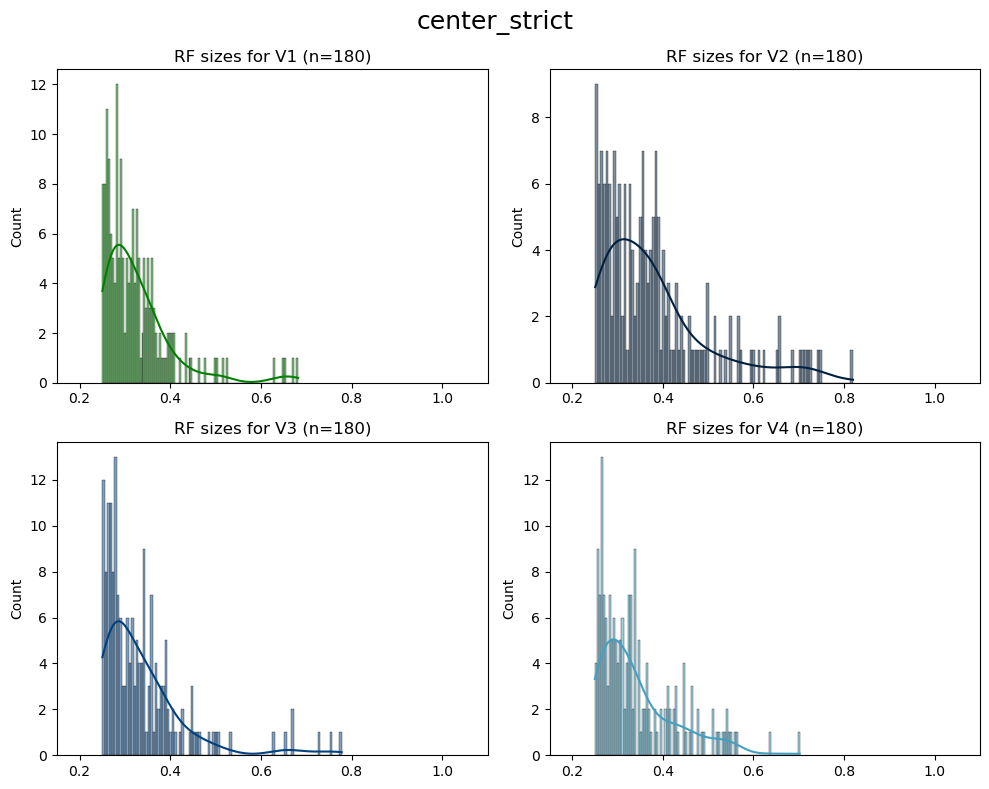

In [106]:
# 1 min
# hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
#                                              min_size = .25, max_size = 1, prf_proc_dict = prf_dict, vox_n_cutoff = 150,plot_sizes = 'y')

hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
                                             min_size = .25, max_size = 1, prf_proc_dict = prf_dict, vox_n_cutoff = 180 ,plot_sizes = 'y')



##### First tryout for subj02, all seems to work so far. For the other pRF selections I would need to run separate get_betas() sessions, which take rather long.

beta_dict0_1_center_strict.pkl
	Amount of voxels: 60
	Amount of voxels: 175
	Amount of voxels: 284
	Amount of voxels: 214
	Processed images: 1500
beta_dict2_39_center_strict.pkl
	Amount of voxels: 60
	Amount of voxels: 175
	Amount of voxels: 284
	Amount of voxels: 214
	Processed images: 30000


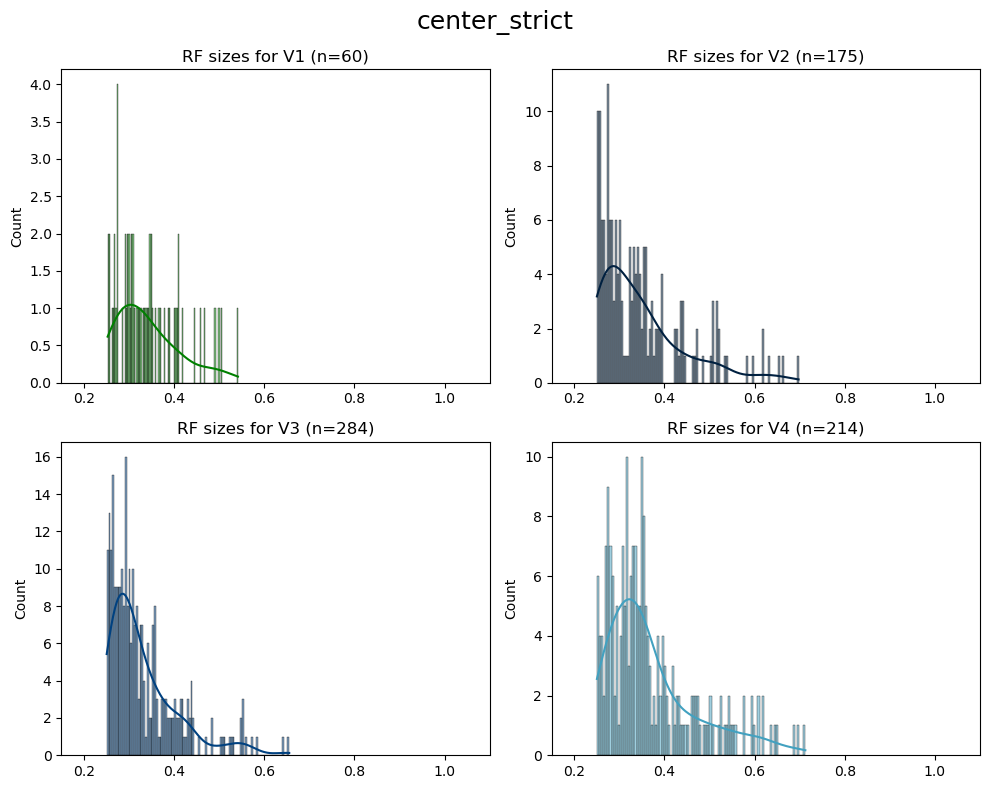

In [76]:
# 1 min
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
hrf_dict_tight, voxmask_tight, joint_voxs, sizes = get_hrf_dict('subj02', voxels = prf_mask_center_strict, 
                                                                prf_region = 'center_strict', 
                                                                min_size = .25, max_size = 1, 
                                                                prf_proc_dict = prf_dict, 
                                                                vox_n_cutoff = None,
                                                                plot_sizes = 'y')

beta_dict0_10_center_halfloose.pkl
	Amount of voxels: 412
	Amount of voxels: 722
	Amount of voxels: 770
	Amount of voxels: 841
	Processed images: 8250
beta_dict11_20_center_halfloose.pkl
	Amount of voxels: 412
	Amount of voxels: 722
	Amount of voxels: 770
	Amount of voxels: 841
	Processed images: 15750
beta_dict21_30_center_halfloose.pkl
	Amount of voxels: 412
	Amount of voxels: 722
	Amount of voxels: 770
	Amount of voxels: 841
	Processed images: 23250
beta_dict31_39_center_halfloose.pkl
	Amount of voxels: 412
	Amount of voxels: 722
	Amount of voxels: 770
	Amount of voxels: 841
	Processed images: 30000


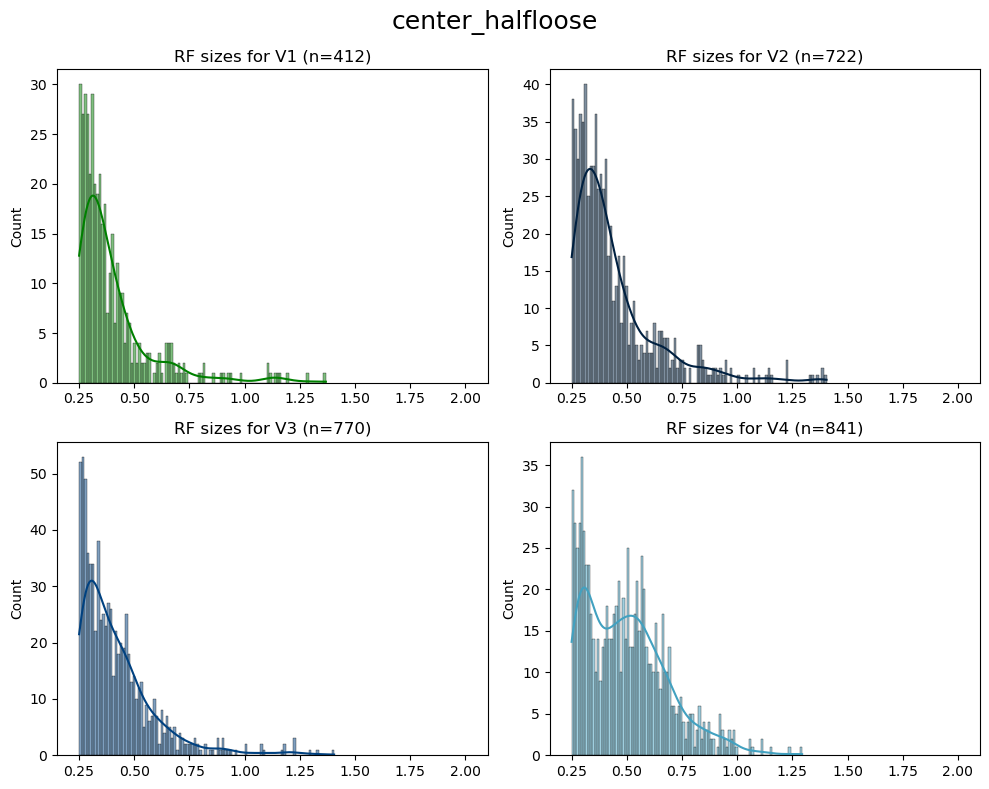

In [9]:
# 1 min
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
subj = 'subj01'

hrf_dict_halfloose, voxmask_halfloose, joint_voxs, sizes  = get_hrf_dict(subj, voxels = prf_mask_central_halfloose, prf_region = 'center_halfloose', 
                                             min_size = .25, max_size = 2, prf_proc_dict = prf_dict, vox_n_cutoff = None,plot_sizes = 'y')



beta_dict0_5_center_loose.pkl
	Amount of voxels: 157
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 4500
beta_dict6_15_center_loose.pkl
	Amount of voxels: 157
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 12000
beta_dict16_25_center_loose.pkl
	Amount of voxels: 157
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 19500
beta_dict26_35_center_loose.pkl
	Amount of voxels: 157
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 27000
beta_dict36_39_center_loose.pkl
	Amount of voxels: 157
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 30000


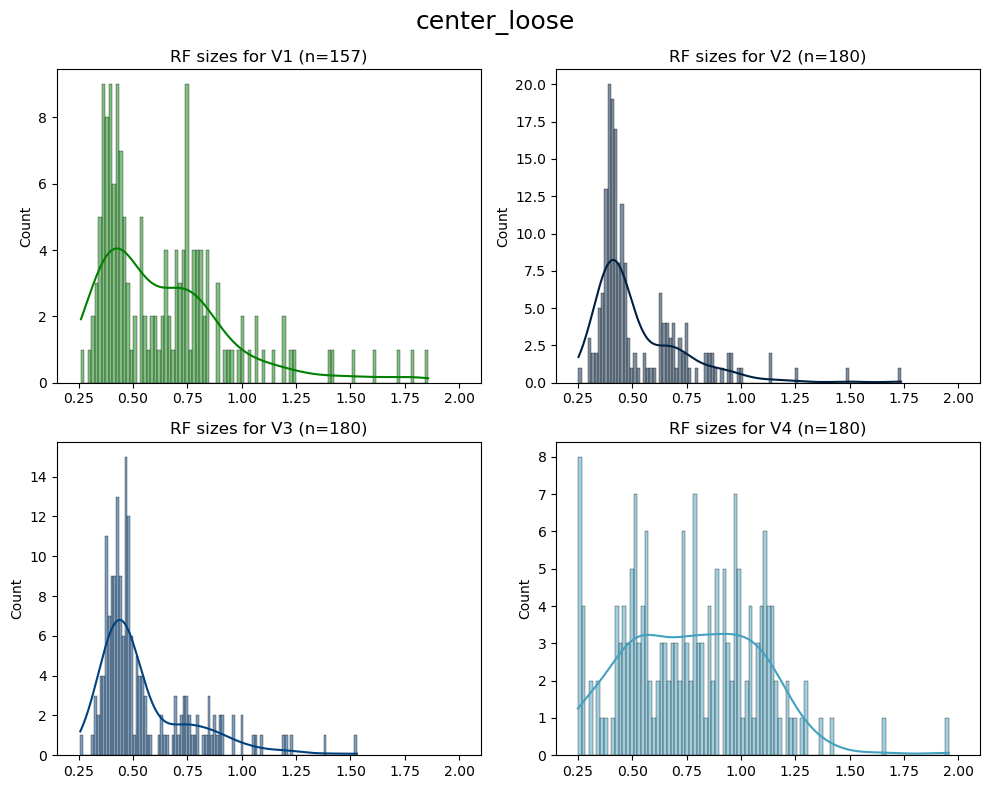

In [107]:
# Create the hrf_dict for the periphery with sizes .2 to 1
subj = 'subj01'
hrf_dict_central_loose, voxmask_central_loose, joint_voxs, sizes = get_hrf_dict(subj, prf_mask_central_loose, prf_region = 'center_loose', 
                                                                    min_size = .25, max_size = 2, prf_proc_dict = prf_dict, 
                                                                    vox_n_cutoff = 180, plot_sizes = 'y')

beta_dict0_5_periphery.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 4500
beta_dict6_15_periphery.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 12000
beta_dict16_25_periphery.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 19500
beta_dict26_35_periphery.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 27000
beta_dict36_39_periphery.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 30000


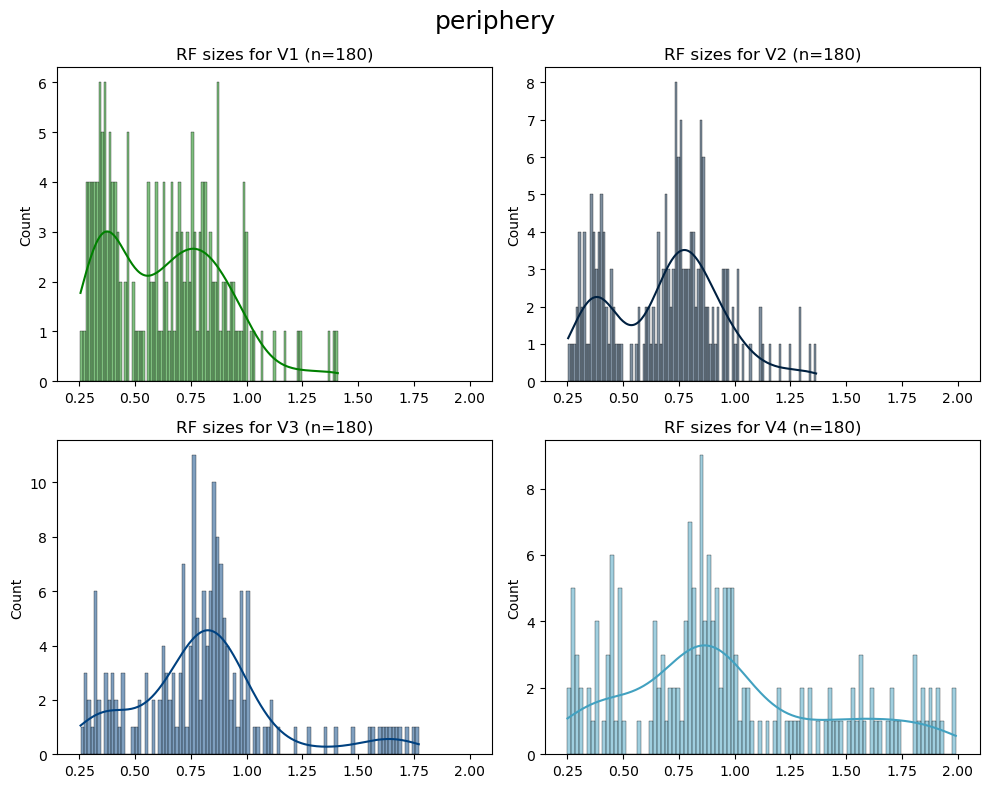

In [108]:
# Create the hrf_dict for the periphery with sizes .2 to 1
# The plot shows the ROI-specific distribution of RF sizes

subj = 'subj01'
hrf_dict_peri, voxmask_tight_peri, joint_voxs, sizes = get_hrf_dict(subj, prf_mask_periphery_strict, prf_region = 'periphery', 
                                                                    min_size = .25, max_size = 2, prf_proc_dict = prf_dict, 
                                                                    vox_n_cutoff = 180, plot_sizes = 'y')


beta_dict0_9_center_strict_l.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 7500
beta_dict10_20_center_strict_l.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 15750
beta_dict21_39_center_strict_l.pkl
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Amount of voxels: 180
	Processed images: 30000


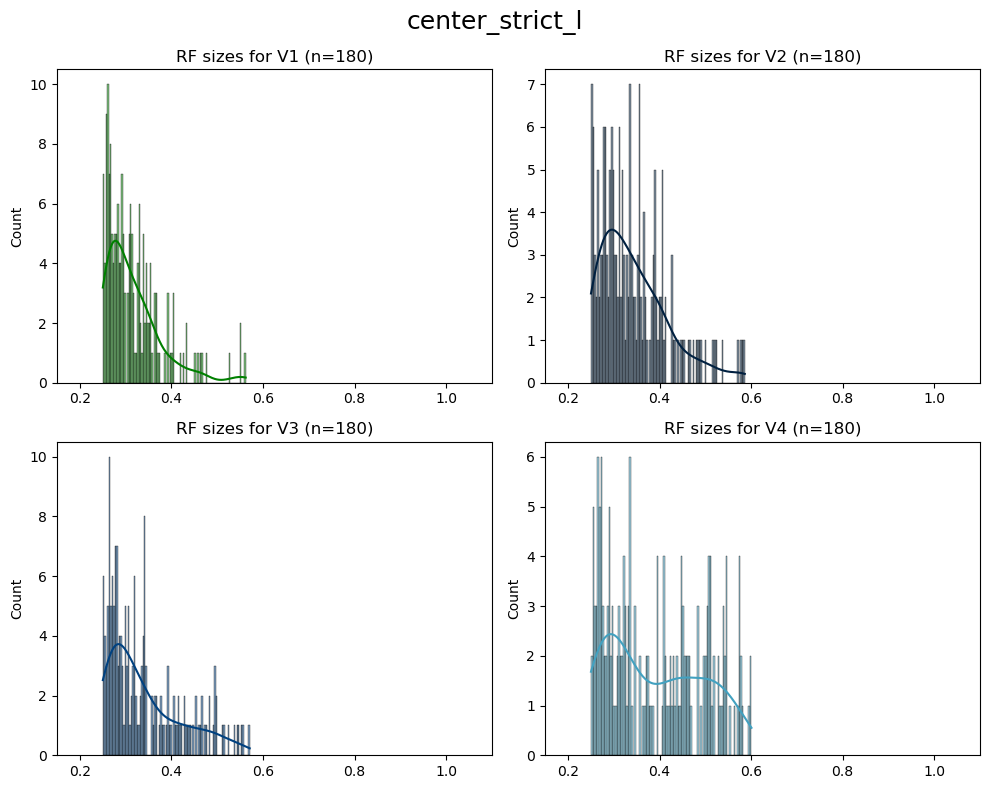

In [109]:
# 1 min
subj = 'subj01'
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
hrf_dict_tight_l, voxmask_tight_l, joint_voxs, sizes  = get_hrf_dict(subj, voxels = prf_mask_center_strict_l, prf_region = 'center_strict_l', 
                                             min_size = .25, max_size = 1, prf_proc_dict = prf_dict, vox_n_cutoff = 180, plot_sizes = 'y')



In [110]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery = True,)

regdict_prfc_tight_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)

regdict_prfc_loose_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

regstash_mcmc = {}

regstash_mcmc['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_mcmc,
        'irrel': regdict_prfc_tight_rmsirrel_mcmc
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_mcmc,
        'irrel': regdict_prfc_loose_rmsirrel_mcmc
    }

}

regstash_mcmc['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_mcmc,
        'irrel': regdict_prfp_tight_rmsirrel_mcmc
    }
}

In [111]:
# The old z-score (over total)
# regdict_prfc_tight_rmsrel_z['V1_mask']['y_matrix']

# array([[-0.43006, -0.29205, -0.08803, ..., -0.48806, -0.8481 , -1.86018],
#        [-1.00411, -0.72609, -0.24604, ..., -0.21204, -0.27405, -1.19013],
#        [-1.15012, -0.31005, -0.23404, ..., -0.10803, -2.73426,  0.69804],
#        ...,
#        [-0.9241 ,  0.286  ,  0.15999, ...,  0.212  , -3.1403 ,  1.4061 ],
#        [-0.02802,  0.13399,  0.51402, ...,  0.238  , -3.50033,  0.80805],
#        [-0.73609,  0.14799,  0.06198, ..., -0.17804, -5.4525 ,  1.61012]])


In [112]:
# The new z-score (per session)
# regdict_prfc_tight_rmsrel_z['V1_mask']['y_matrix']

# array([[-0.65082, -0.50525, -0.29005, ..., -0.71201, -1.09177, -2.15934],
#        [-1.25634, -0.96308, -0.45672, ..., -0.42085, -0.48626, -1.45255],
#        [-1.41036, -0.52424, -0.44406, ..., -0.31114, -3.08133,  0.53911],
#        ...,
#        [-0.9747 ,  0.42263,  0.27712, ...,  0.33717, -3.53376,  1.71602],
#        [ 0.06002,  0.2471 ,  0.68592, ...,  0.3672 , -3.94949,  1.02544],
#        [-0.75759,  0.26326,  0.16395, ..., -0.11321, -6.20368,  1.9516 ]])


In [113]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery = True,)

regdict_prfc_tight_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)

regdict_prfc_loose_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.

regdict_prfp_tight_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

regstash_mc = {}

regstash_mc['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_mc,
        'irrel': regdict_prfc_tight_rmsirrel_mc
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_mc,
        'irrel': regdict_prfc_loose_rmsirrel_mc
    }

}

regstash_mc['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_mc,
        'irrel': regdict_prfp_tight_rmsirrel_mc
    }
}

In [114]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)


# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_l_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_l, hrf_dict_tight_l, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_l_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_l, hrf_dict_tight_l, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)


# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_loose_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)

regstash_z = {}

regstash_z['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_z,
        'irrel': regdict_prfc_tight_rmsirrel_z
    },
    'tight_l': {
        'rel': regdict_prfc_tight_l_rmsrel_z,
        'irrel': regdict_prfc_tight_l_rmsirrel_z
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_z,
        'irrel': regdict_prfc_loose_rmsirrel_z
    }
}

regstash_z['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_z,
        'irrel': regdict_prfp_tight_rmsirrel_z
    }
}

#### Here I create yet another dictionary to check whether it matters if images are cropped prior or post calculating RMS. This is for cropping it prior to calculating, the original crops post calculating RMS (potentially impacting results).

In [115]:
# hrf_dict_halfloose, voxmask_halfloose
subj = 'subj02'
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate(subj, 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior[subj]['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior[subj]['rms_irrelevant'], n_imgs=30000, z_scorey = True)

regstash_z_crop_prior_subj2 = {}

regstash_z_crop_prior_subj2['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_z,
        'irrel': regdict_prfc_tight_rmsirrel_z
    }
}



KeyError: 'subj02'

In [116]:
# hrf_dict_halfloose, voxmask_halfloose
subj = 'subj01'
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate(subj, 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior[subj]['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior[subj]['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_l_rmsrel_z, X_subj1_rel = regression_dict_multivariate(subj, 'rms_z',voxmask_tight_l, hrf_dict_tight_l, 
                                                                                            visfeats_rms_crop_prior[subj]['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_l_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'rms_z', voxmask_tight_l, hrf_dict_tight_l, 
                                                                                            visfeats_rms_crop_prior[subj]['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_halfloose_rmsrel_z, X_subj1_rel = regression_dict_multivariate(subj, 'rms_z',voxmask_halfloose, hrf_dict_halfloose, 
                                                                                            visfeats_rms_crop_prior[subj]['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_halfloose_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms_crop_prior[subj]['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_z, X_subj1_rel = regression_dict_multivariate(subj, 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms_crop_prior[subj]['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_loose_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms_crop_prior[subj]['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate(subj, 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms_crop_prior[subj]['rms'], n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms_crop_prior[subj]['rms_irrelevant'], n_imgs=30000, z_scorey = True)

regstash_z_crop_prior = {}

regstash_z_crop_prior['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_z,
        'irrel': regdict_prfc_tight_rmsirrel_z
    },
    'tight_l': {
        'rel': regdict_prfc_tight_l_rmsrel_z,
        'irrel': regdict_prfc_tight_l_rmsirrel_z
    },
    'halfloose':{
        'rel': regdict_prfc_halfloose_rmsrel_z,
        'irrel': regdict_prfc_halfloose_rmsirrel_z
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_z,
        'irrel': regdict_prfc_loose_rmsirrel_z
    }
}

regstash_z_crop_prior['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_z,
        'irrel': regdict_prfp_tight_rmsirrel_z
    }
}

### Spatial Coherence (SC) and Contrast Energy (CE)

In [117]:
# Contrast energy (1 degrees)
subj = 'subj01' # Uncomment the two sections for peripheral pRFs when switching to subj01. All other subjects probably don't really need those sanity check selections,
# Only when I'll implement Steven's idea at some point of looking at an aggregate of peripheral pRFs based on multiple fixed eccentricity scores. 

regdict_prfc_tight_cerel_z, X_subj1_rel = regression_dict_multivariate(subj, 'ce_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_ceirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'ce_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'], n_imgs=30000, z_scorey = True)


# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_cerel_z, X_subj1_rel = regression_dict_multivariate(subj, 'ce_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_scce[subj]['scce'], n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_ceirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'ce_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'], n_imgs=30000, z_scorey = True)

regstash_ce_z = {}

regstash_ce_z['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_cerel_z,
        'irrel': regdict_prfc_tight_ceirrel_z
    }
}

regstash_ce_z['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_cerel_z,
        'irrel': regdict_prfp_tight_ceirrel_z
    }
}

In [118]:
# Contrast energy large (2.8 degrees)
subj = 'subj01' # Uncomment the two sections for peripheral pRFs when switching to subj01. All other subjects probably don't really need those sanity check selections,
# Only when I'll implement Steven's idea at some point of looking at an aggregate of peripheral pRFs based on multiple fixed eccentricity scores. 

regdict_prfc_tight_cerel_large_z, X_subj1_rel = regression_dict_multivariate(subj, 'ce_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_ceirrel_large_z, X_subj1_irrel = regression_dict_multivariate(subj, 'ce_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce_irrelevant'], n_imgs=30000, z_scorey = True)


# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_cerel_z, X_subj1_rel = regression_dict_multivariate(subj, 'ce_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_scce[subj]['scce'], n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_ceirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'ce_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'], n_imgs=30000, z_scorey = True)

regstash_ce_large_z = {}

regstash_ce_large_z['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_cerel_large_z,
        'irrel': regdict_prfc_tight_ceirrel_large_z
    }
}

regstash_ce_z['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_cerel_z,
        'irrel': regdict_prfp_tight_ceirrel_z
    }
}

In [119]:
# Spatial Coherence
subj = 'subj01'

regdict_prfc_tight_screl_z, X_subj1_rel = regression_dict_multivariate(subj, 'sc_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)

regdict_prfc_tight_scirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'sc_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_screl_z, X_subj1_rel = regression_dict_multivariate(subj, 'sc_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_scce[subj]['scce'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_scirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'sc_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'].replace([np.nan, np.NINF], 0.0000000001), n_imgs=30000, z_scorey = True)

regstash_sc_z = {}

regstash_sc_z['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_screl_z,
        'irrel': regdict_prfc_tight_scirrel_z
    }
}

regstash_sc_z['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_screl_z,
        'irrel': regdict_prfp_tight_scirrel_z
    }
}

In [120]:
# Spatial Coherence
subj = 'subj01'

regdict_prfc_tight_screl_large_z, X_subj1_rel = regression_dict_multivariate(subj, 'sc_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)

regdict_prfc_tight_scirrel_large_z, X_subj1_irrel = regression_dict_multivariate(subj, 'sc_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce_irrelevant'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)

# # Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_screl_z, X_subj1_rel = regression_dict_multivariate(subj, 'sc_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_scce[subj]['scce'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_scirrel_z, X_subj1_irrel = regression_dict_multivariate(subj, 'sc_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'].replace([np.nan, np.NINF], 0.0000000001), n_imgs=30000, z_scorey = True)

regstash_sc_large_z = {}

regstash_sc_large_z['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_screl_large_z,
        'irrel': regdict_prfc_tight_scirrel_large_z
    }
}

regstash_sc_z['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_screl_z,
        'irrel': regdict_prfp_tight_scirrel_z
    }
}

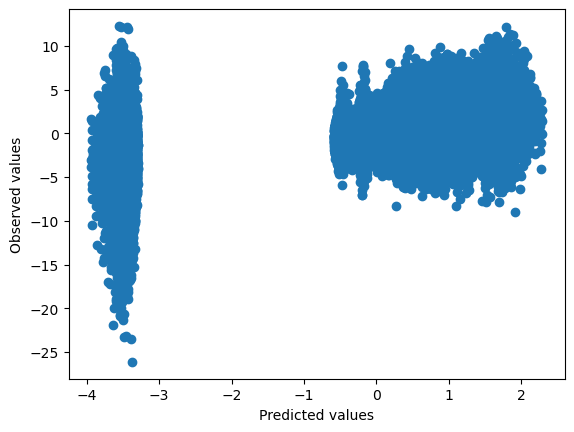

In [21]:
import matplotlib.pyplot as plt

# Predicted values
y_pred = um.predict(uX)

plt.scatter(y_pred, uy)
plt.xlabel('Predicted values')
plt.ylabel('Observed values')
plt.show()

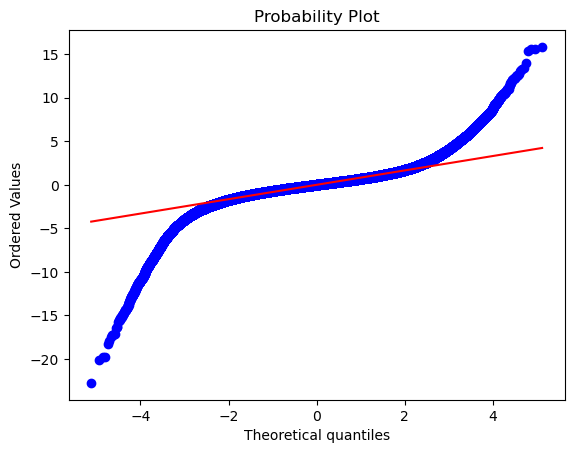

In [22]:
import scipy.stats as stats

residuals = uy - y_pred

stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.show()

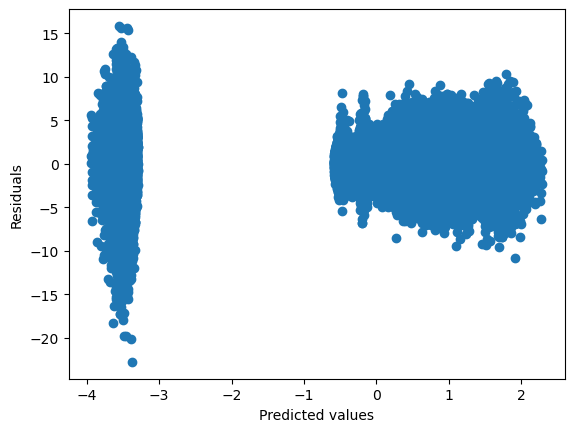

In [23]:
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

In [17]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)

regdict_prfc_tight_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)

regdict_prfc_loose_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)

# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)



Stash the different regression dictionaries in another dictionary to make access more intuitive.

In [18]:
regstash = {}

regstash['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel,
        'irrel': regdict_prfc_tight_rmsirrel
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel,
        'irrel': regdict_prfc_loose_rmsirrel
    }

}

regstash['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel,
        'irrel': regdict_prfp_tight_rmsirrel
    }
}

### Raw vs. Z-score vs. Mean centering

In [72]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs (non-standardized)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

NameError: name 'regstash' is not defined

### NEW CHECK FOR CROP POSTERIOR SHIT, IF IT SEEMS TO MATTER, CHANGE ALL RMS VALUES INTO NEW ONES

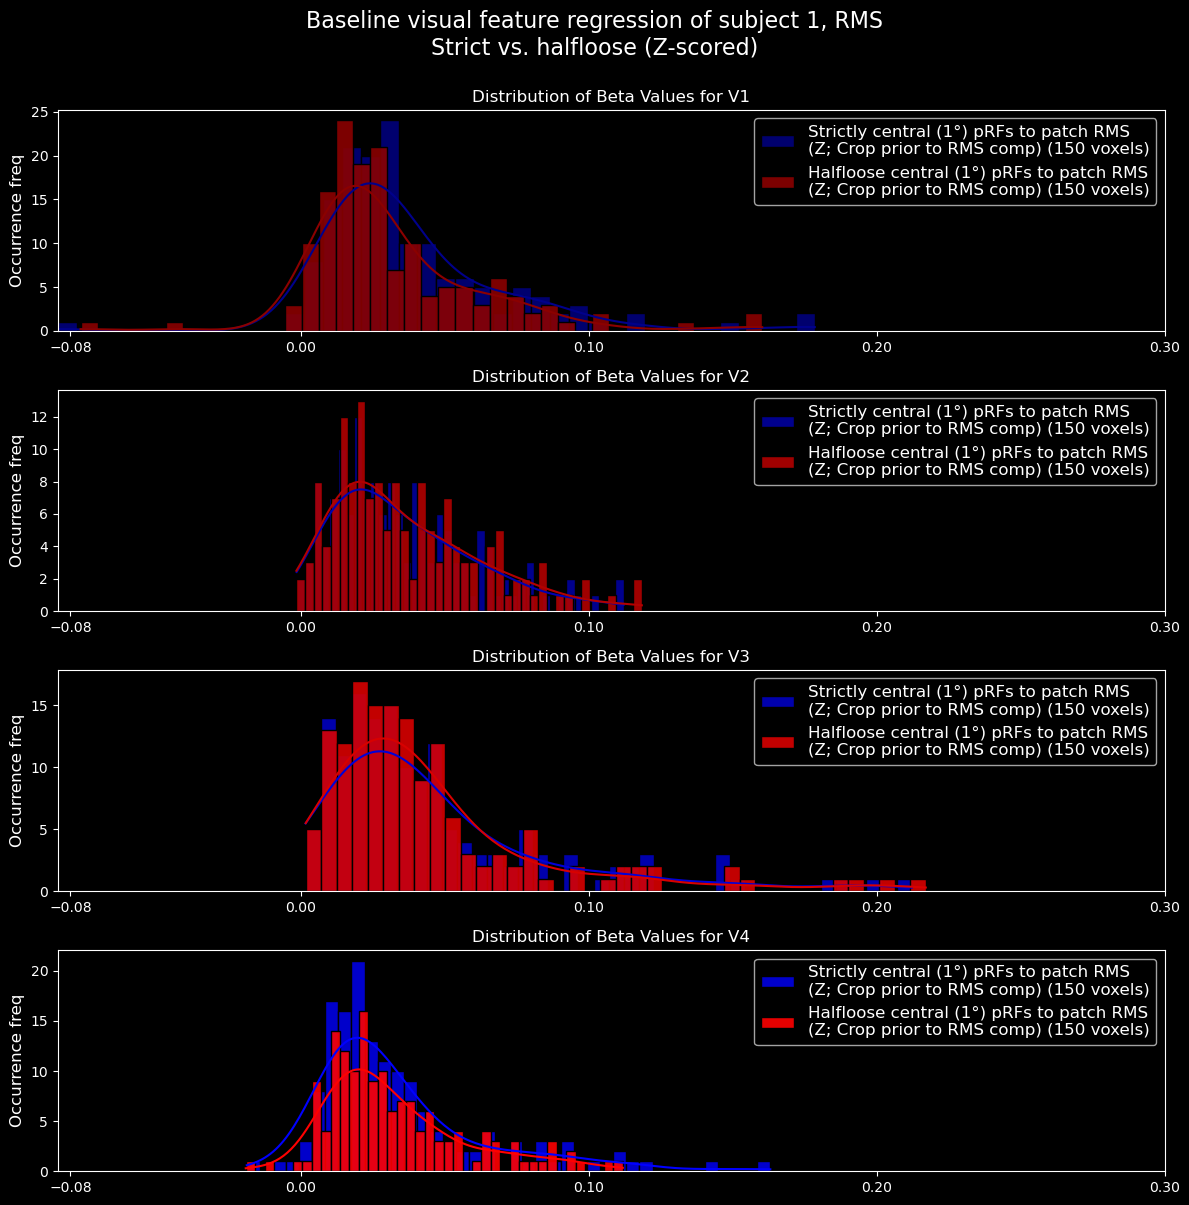

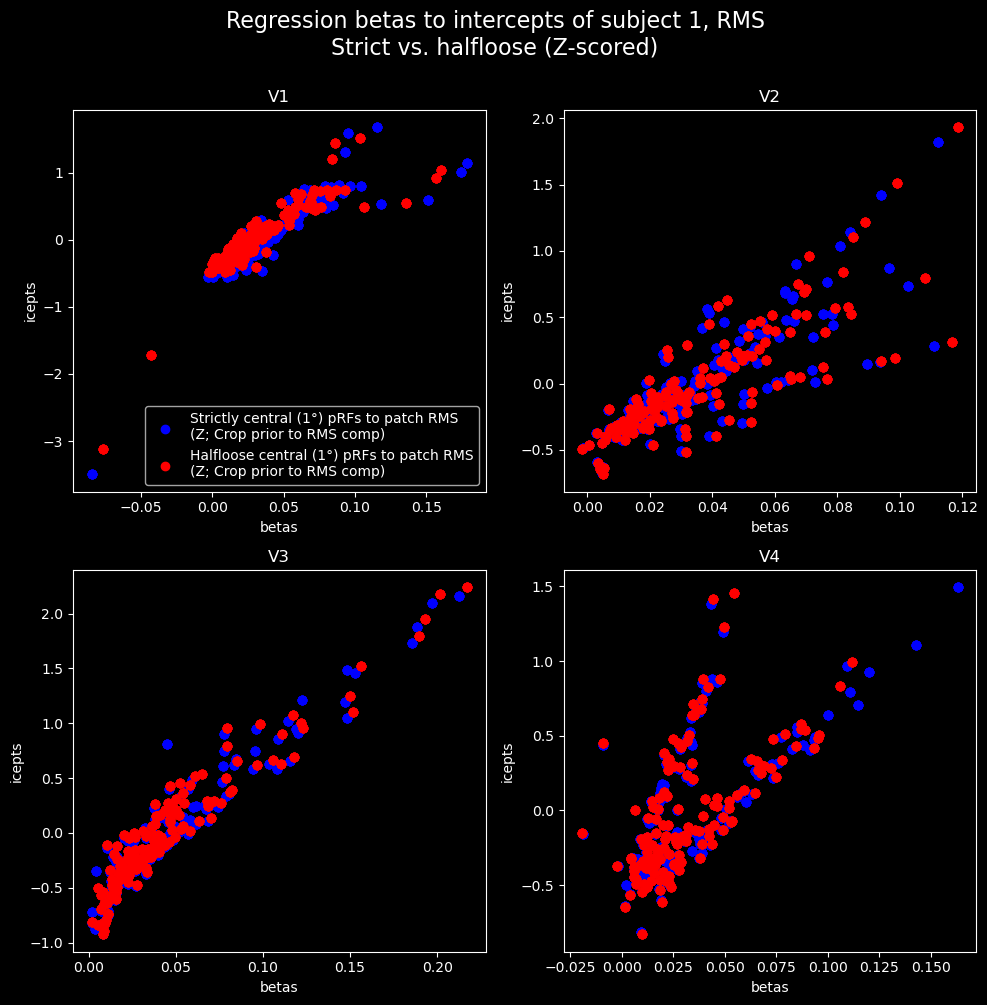

In [36]:

# ORIGINAL SIZE STRICT CENTRAL VS 1.25 RADIUS CENTRAL STRICT
# CHECK WHETHER OG SIZE IS FINE, WHAT IS ADDED VALUE OF EXTRA VOXELS


reg_plots(regstash_z_crop_prior['centralprfs']['tight']['rel'], dictdescrip1 = 'Strictly central (1°) pRFs to patch RMS\n(Z; Crop prior to RMS comp)', comptype = 'Strict vs. halfloose (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z_crop_prior['centralprfs']['halfloose']['rel'], 
                           dictdescrip2 = 'Halfloose central (1°) pRFs to patch RMS\n(Z; Crop prior to RMS comp)', beta_hist = True, beta_icept = True)

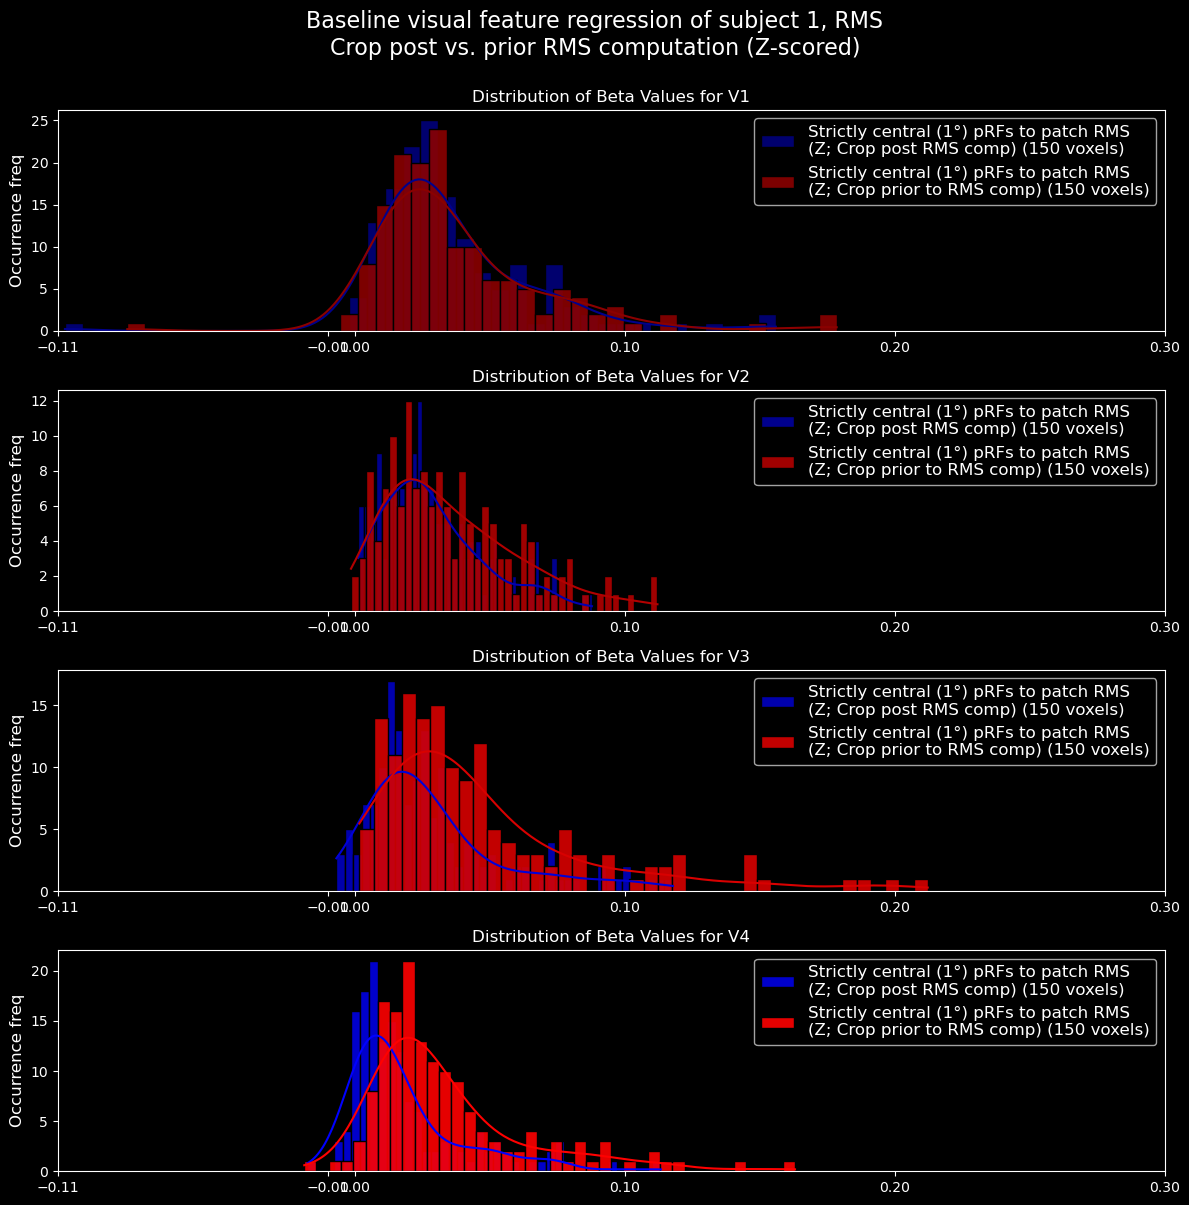

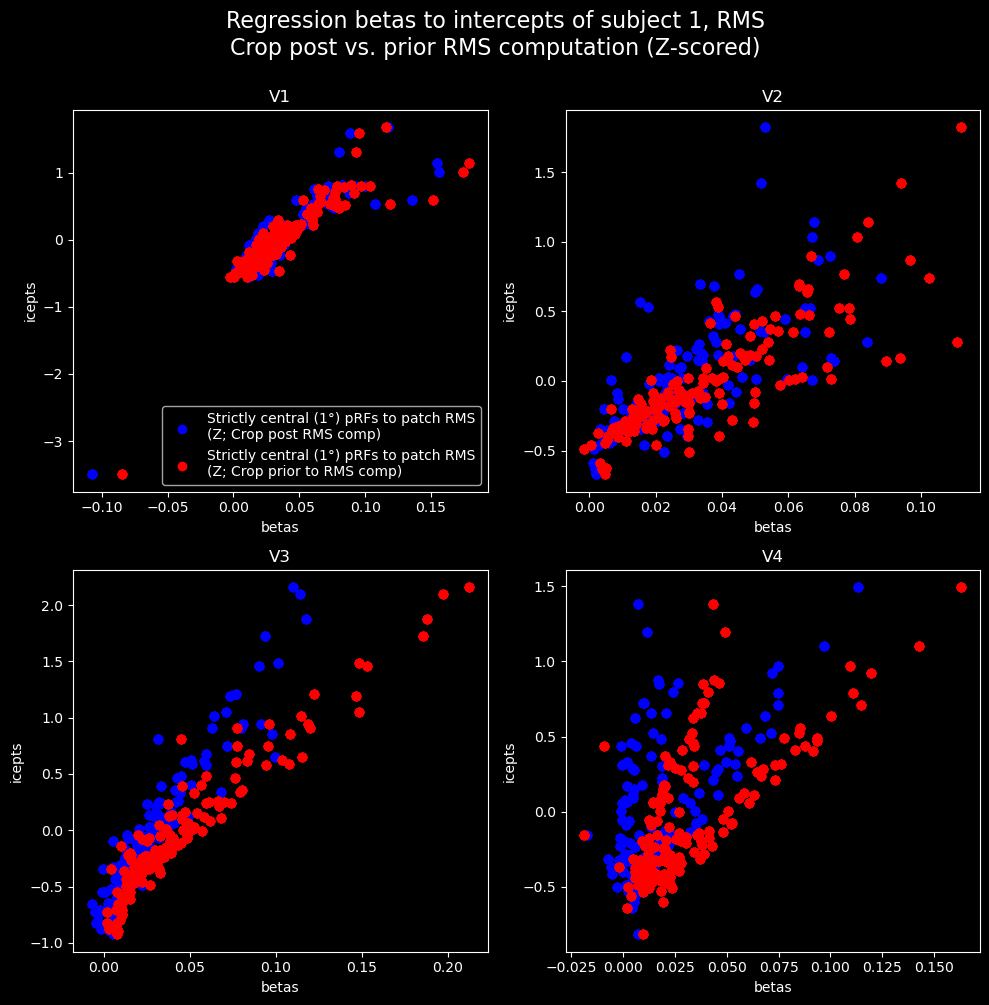

In [153]:

# ORIGINAL SIZE STRICT CENTRAL VS 1.25 RADIUS CENTRAL STRICT
# CHECK WHETHER OG SIZE IS FINE, WHAT IS ADDED VALUE OF EXTRA VOXELS


reg_plots(regstash_z['centralprfs']['tight']['rel'], dictdescrip1 = 'Strictly central (1°) pRFs to patch RMS\n(Z; Crop post RMS comp)', comptype = 'Crop post vs. prior RMS computation (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z_crop_prior['centralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly central (1°) pRFs to patch RMS\n(Z; Crop prior to RMS comp)', beta_hist = True, beta_icept = True)

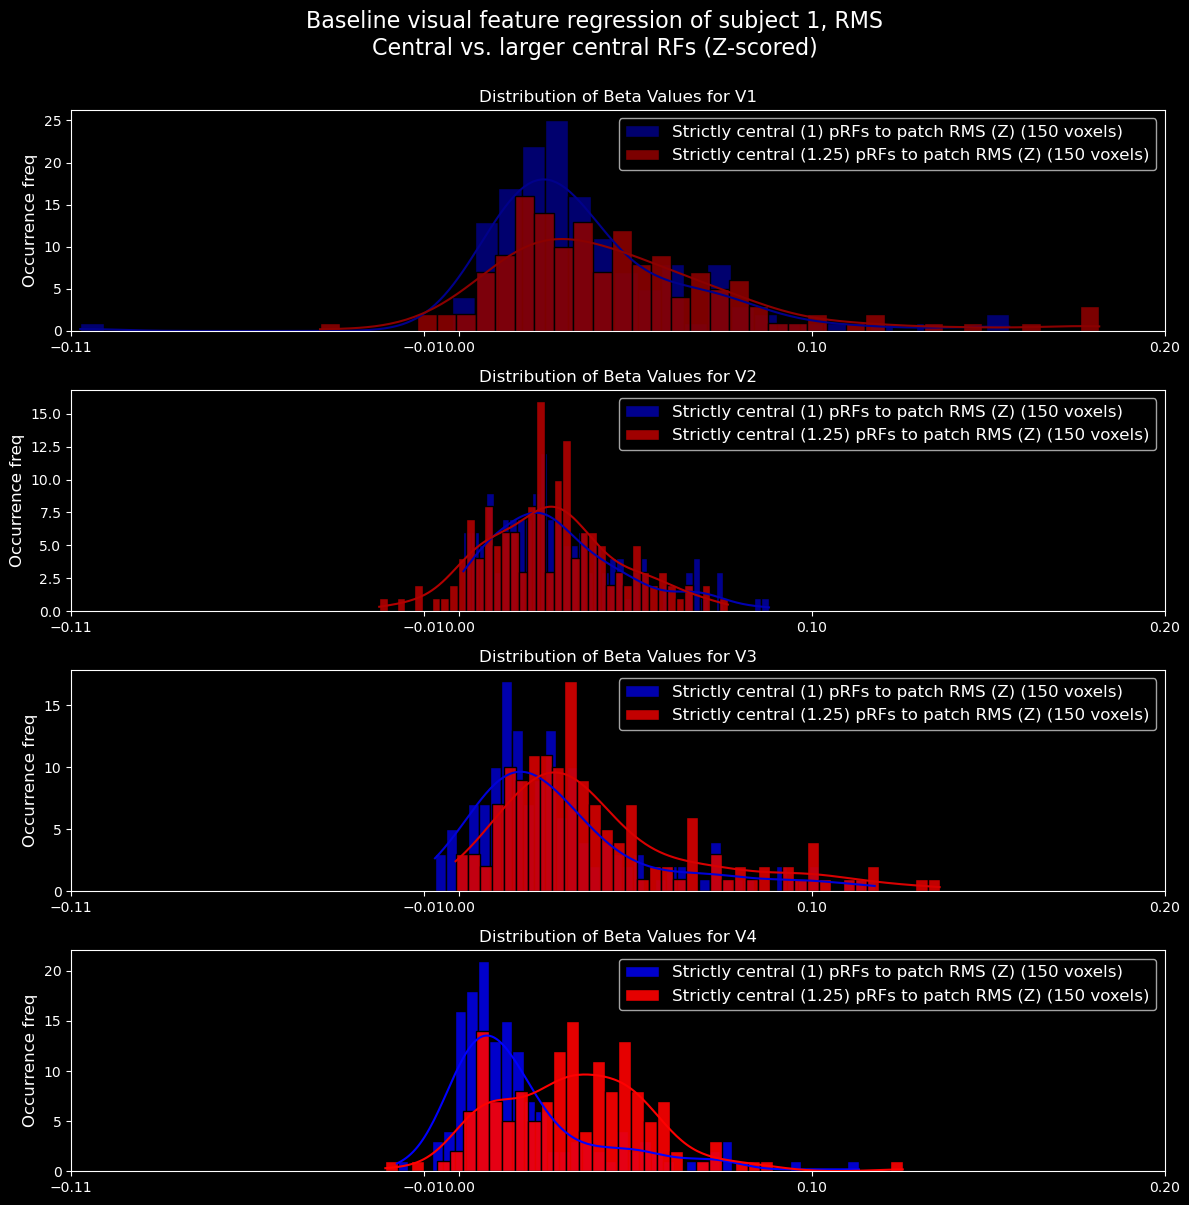

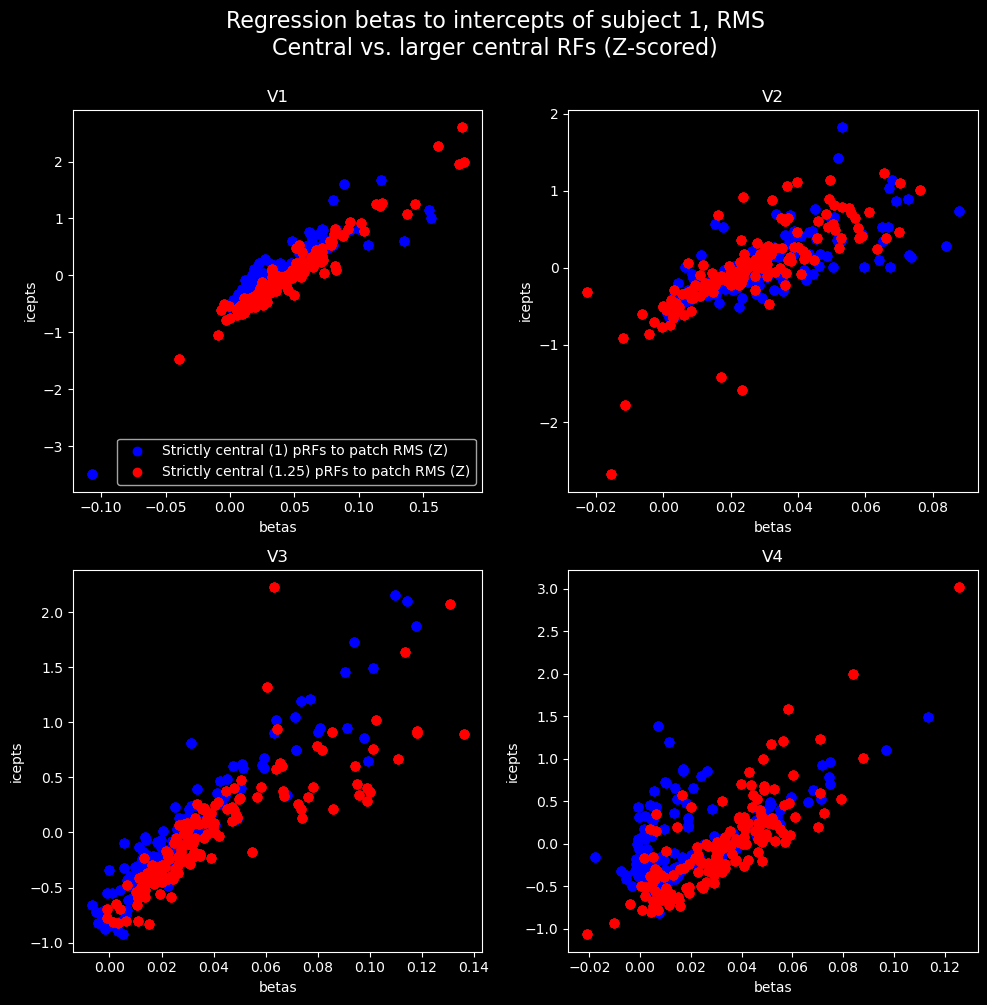

In [108]:
# ORIGINAL SIZE STRICT CENTRAL VS 1.25 RADIUS CENTRAL STRICT
# CHECK WHETHER OG SIZE IS FINE, WHAT IS ADDED VALUE OF EXTRA VOXELS


reg_plots(regstash_z['centralprfs']['tight']['rel'], dictdescrip1 = 'Strictly central (1) pRFs to patch RMS (Z)', comptype = 'Central vs. larger central RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['tight_l']['rel'], 
                           dictdescrip2 = 'Strictly central (1.25) pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

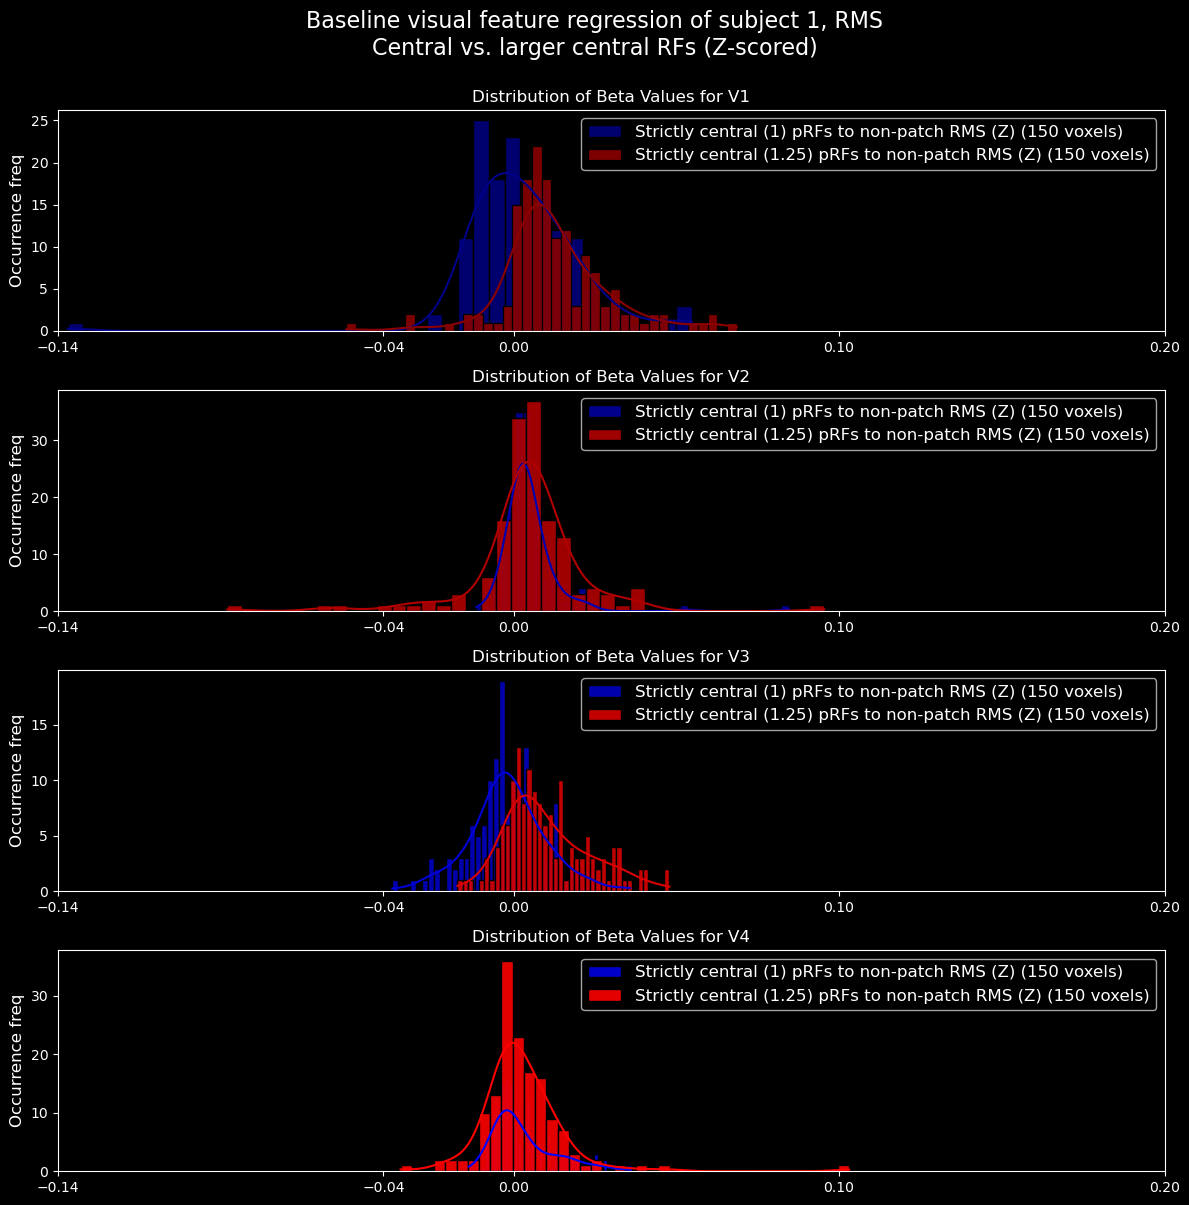

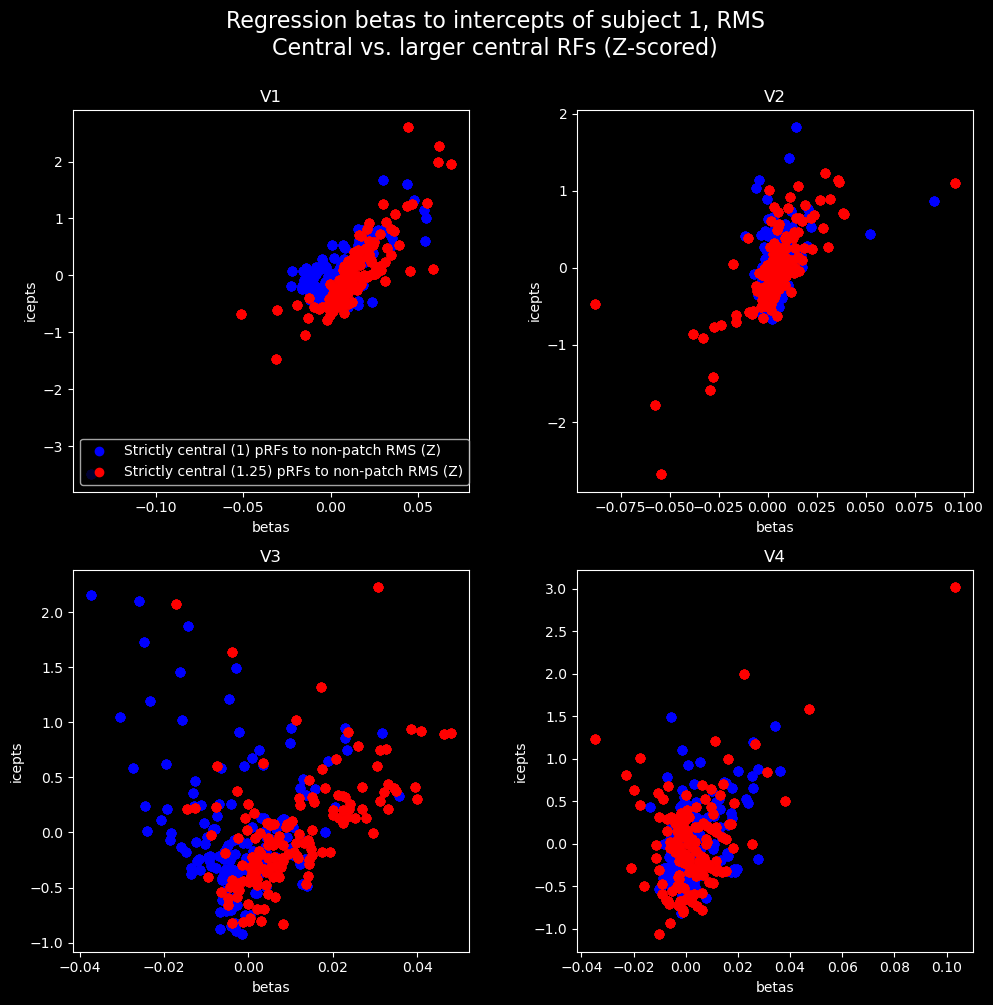

In [109]:
# ORIGINAL SIZE STRICT CENTRAL VS 1.25 RADIUS CENTRAL STRICT
# HERE THE 1 RADIUS SEEMS TO BE BETTER, AS IT IS NON RESPONSIVE TO THE IRRELEVANT RMS VALUES


reg_plots(regstash_z['centralprfs']['tight']['irrel'], dictdescrip1 = 'Strictly central (1) pRFs to non-patch RMS (Z)', comptype = 'Central vs. larger central RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['tight_l']['irrel'], 
                           dictdescrip2 = 'Strictly central (1.25) pRFs to non-patch RMS (Z)', beta_hist = True, beta_icept = True)

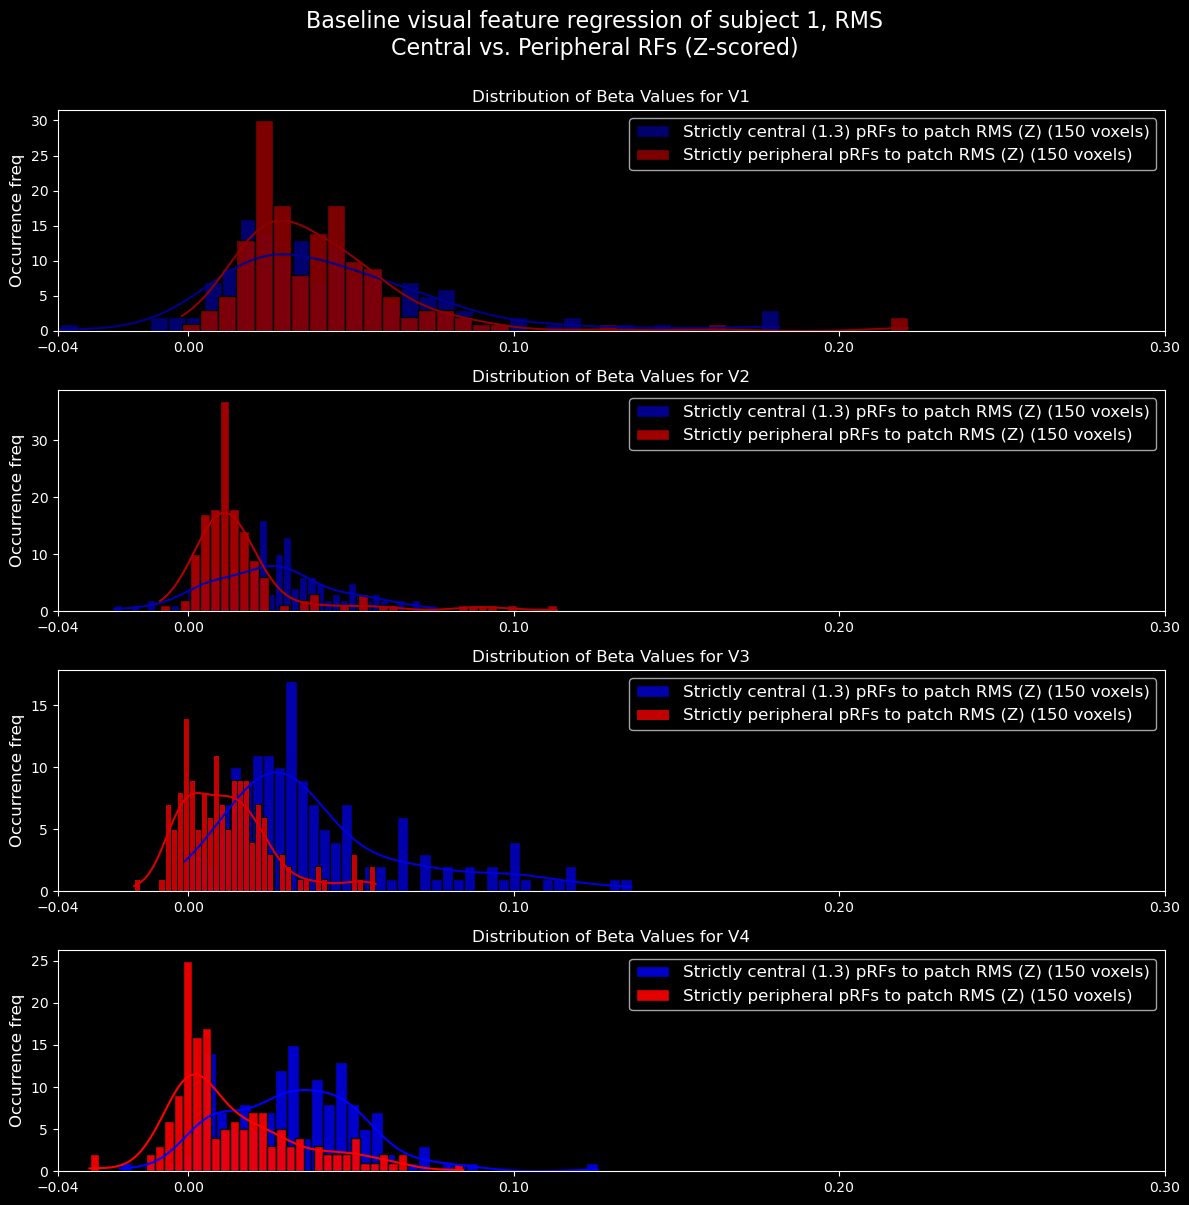

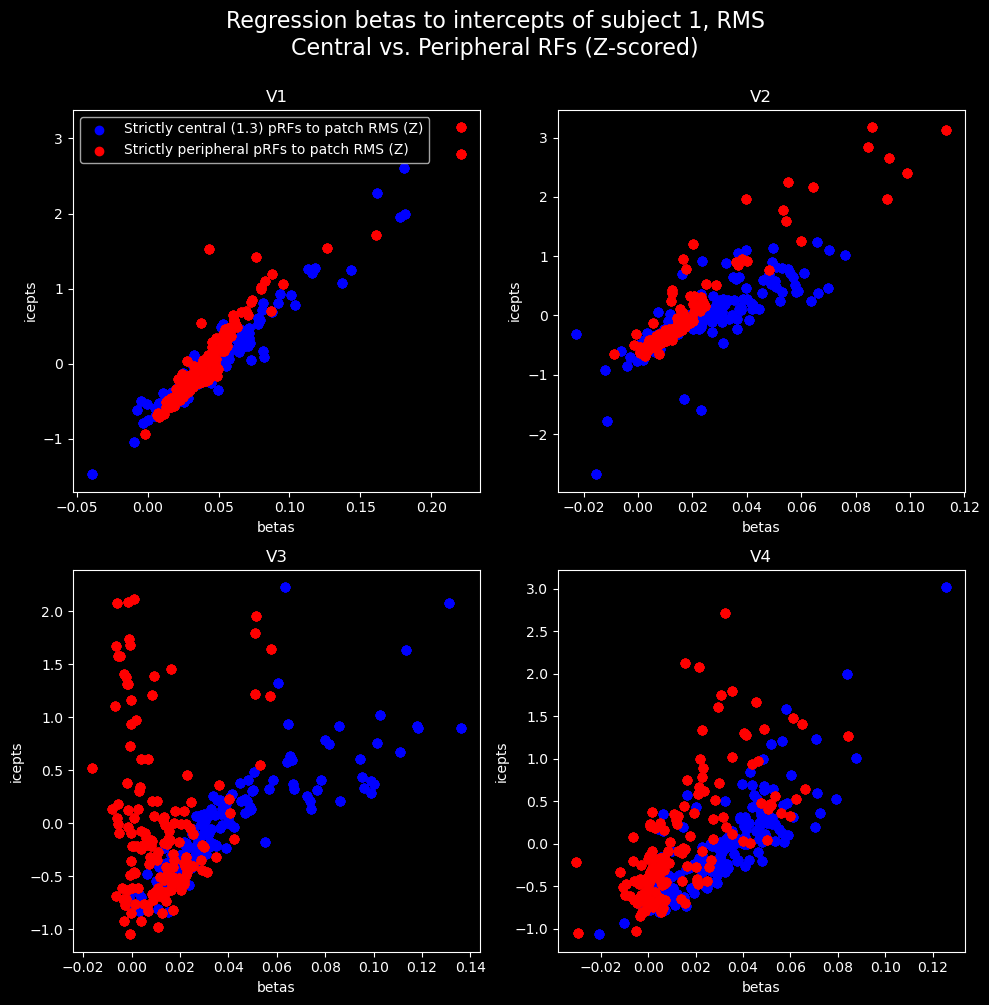

In [112]:
# Comparing the larger central strict RFs to the peripheral strict RFs
reg_plots(regstash_z['centralprfs']['tight_l']['rel'], dictdescrip1 = 'Strictly central (1.3) pRFs to patch RMS (Z)', comptype = 'Central vs. Peripheral RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

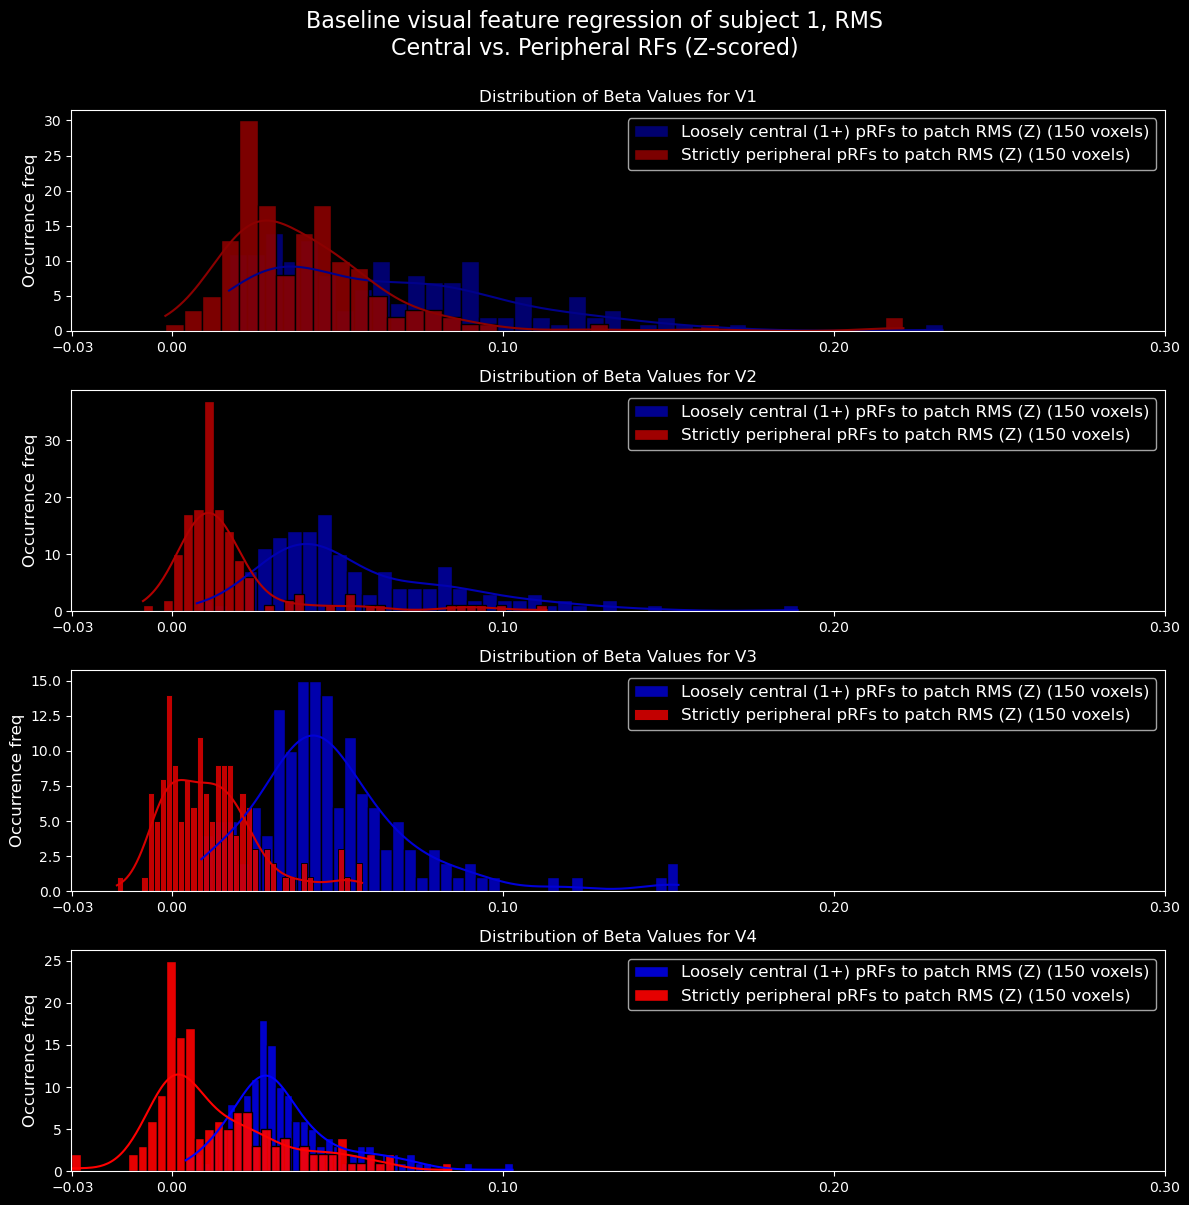

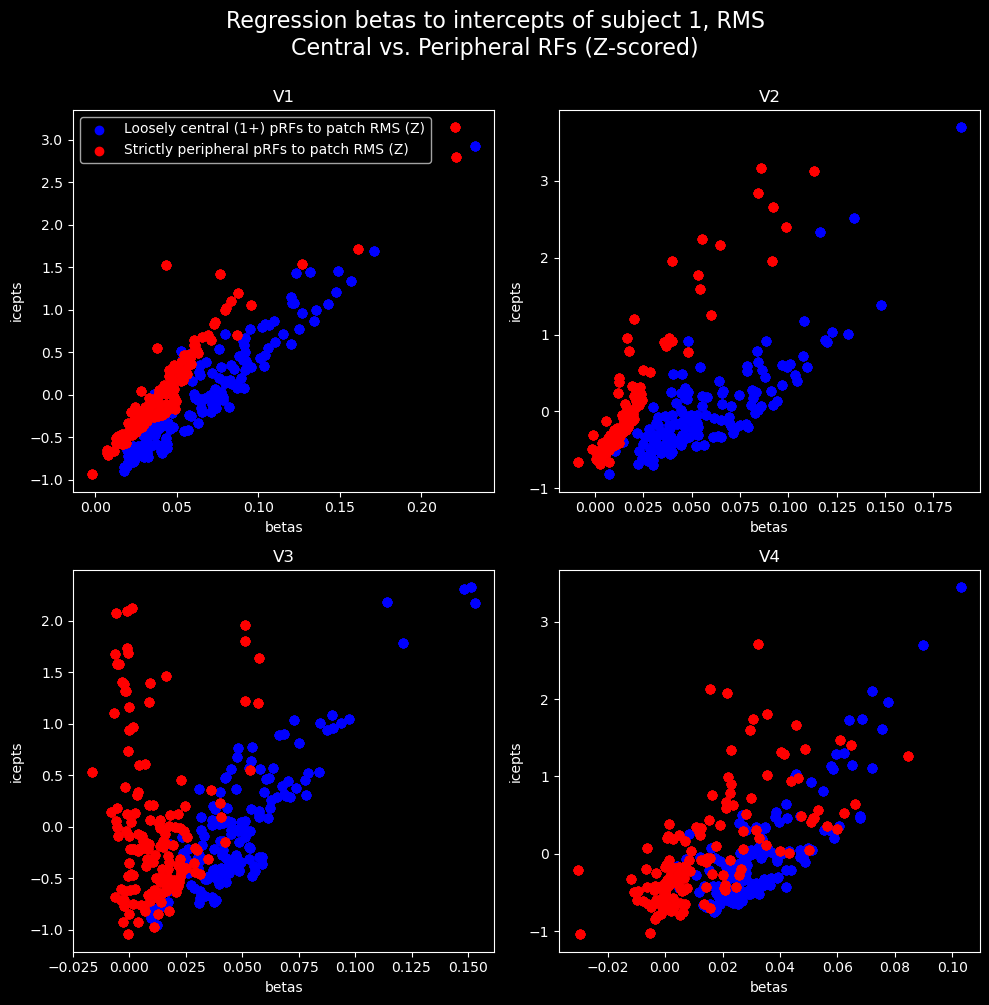

In [114]:
# NEW 
reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central (1+) pRFs to patch RMS (Z)', comptype = 'Central vs. Peripheral RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

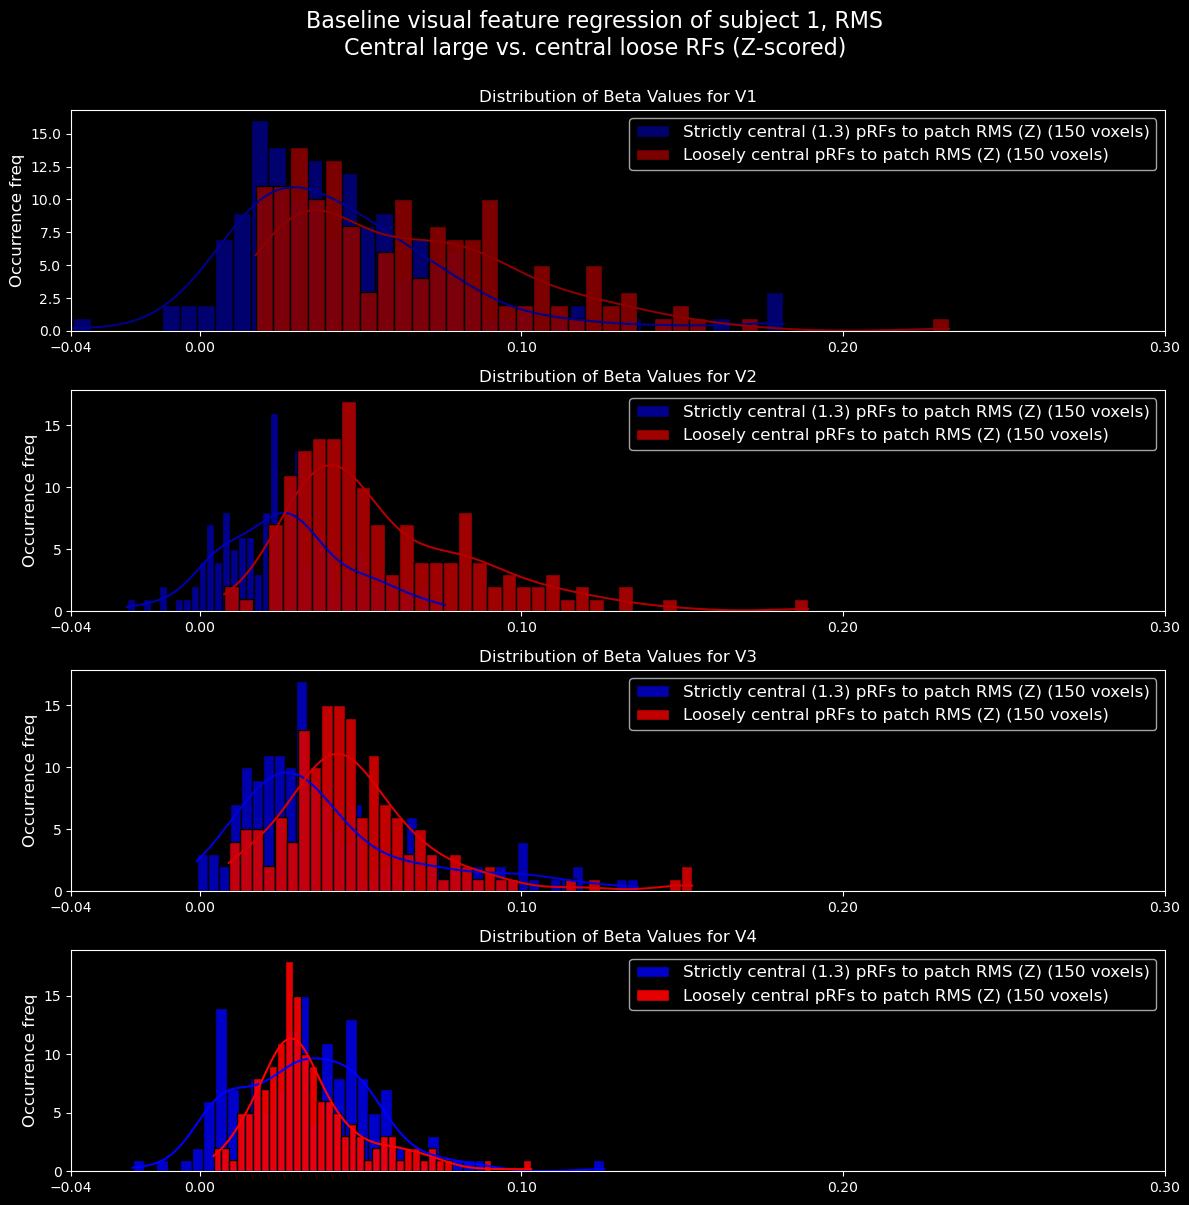

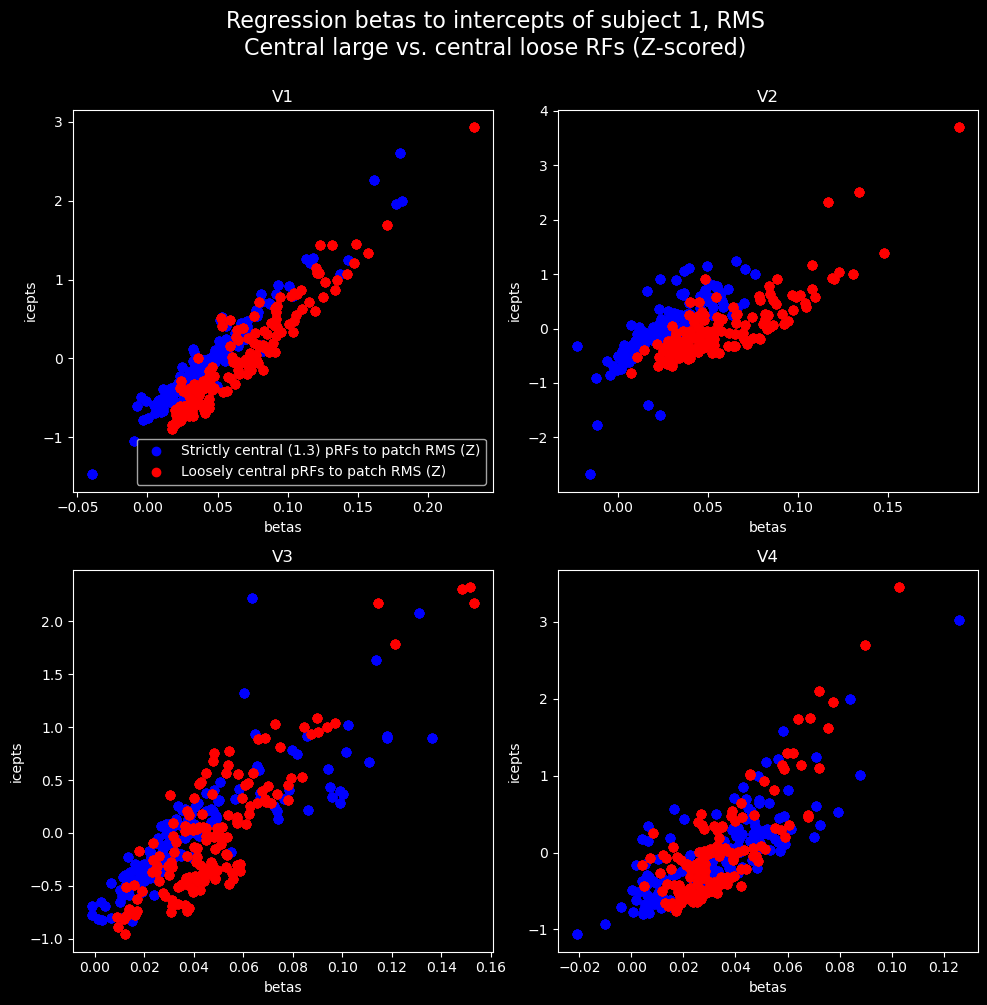

In [115]:
# NEW 
reg_plots(regstash_z['centralprfs']['tight_l']['rel'], dictdescrip1 = 'Strictly central (1.3) pRFs to patch RMS (Z)', comptype = 'Central large vs. central loose RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['loose']['rel'], 
                           dictdescrip2 = 'Loosely central pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

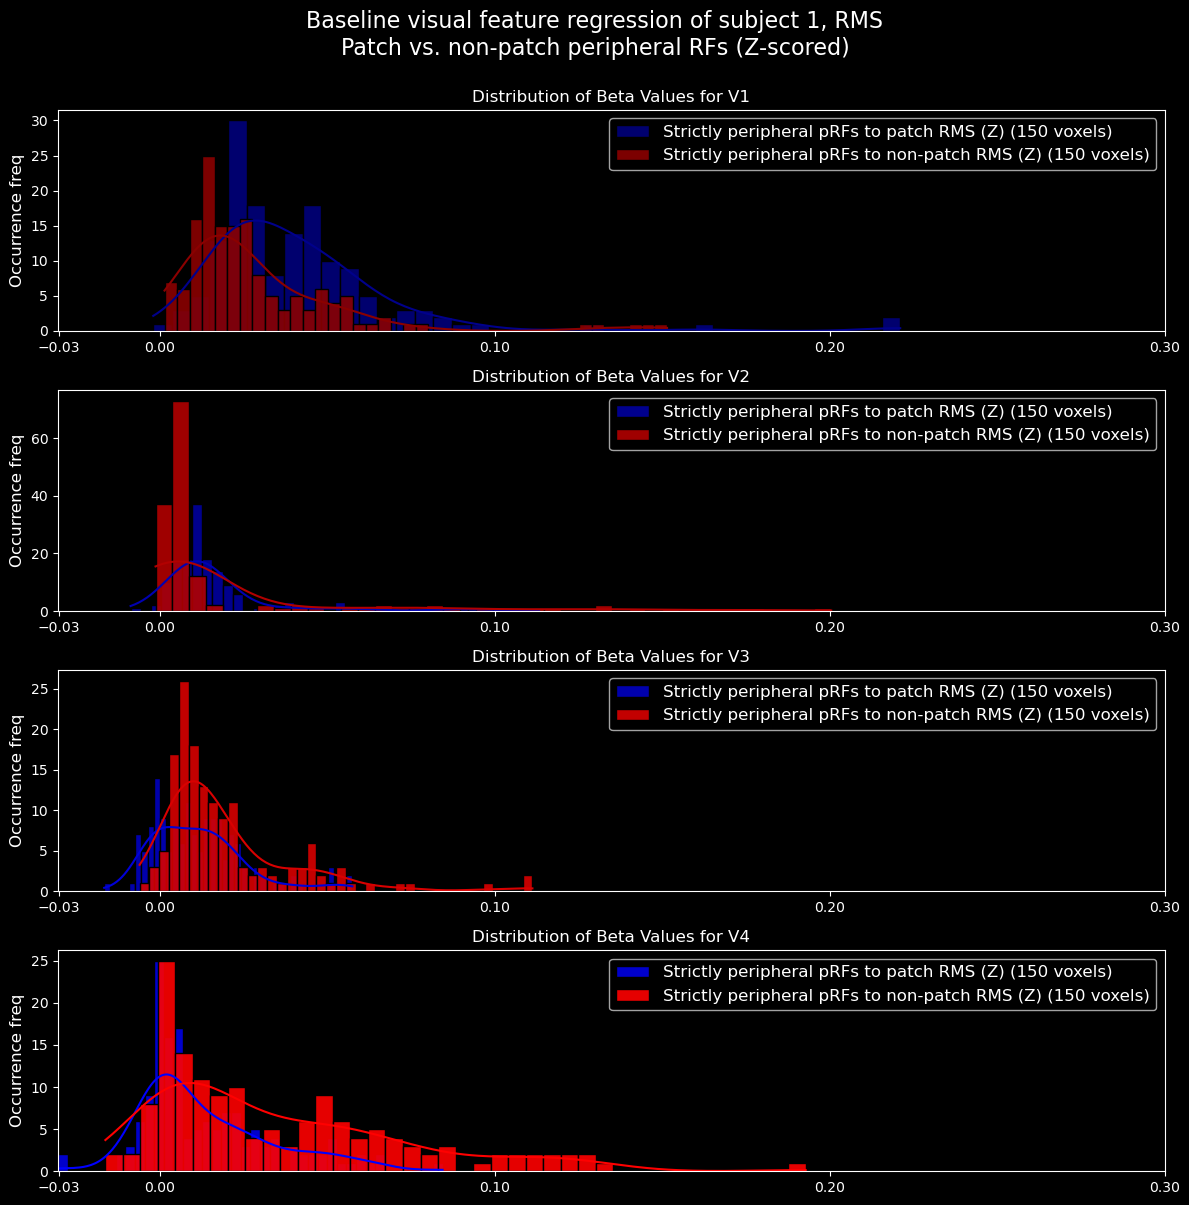

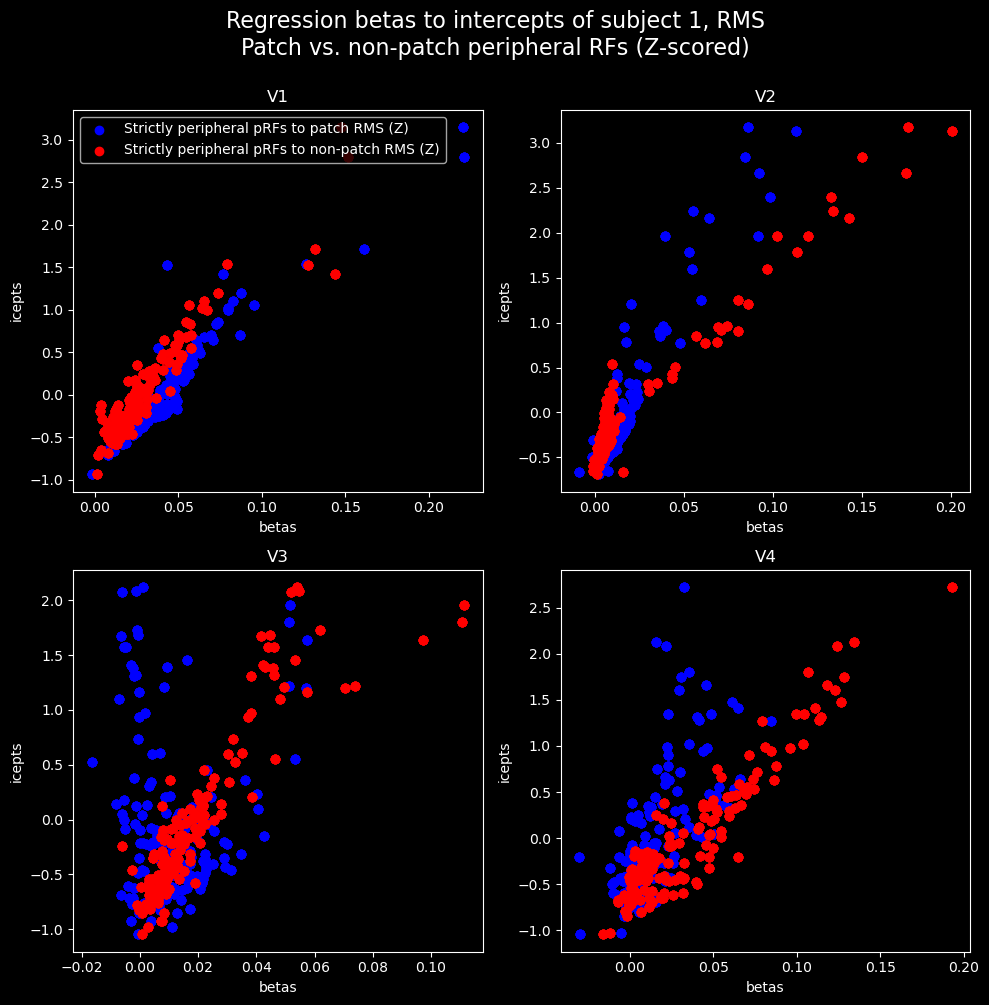

In [116]:
# NEW 
reg_plots(regstash_z['peripheralprfs']['tight']['rel'], dictdescrip1 = 'Strictly peripheral pRFs to patch RMS (Z)', comptype = 'Patch vs. non-patch peripheral RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to non-patch RMS (Z)', beta_hist = True, beta_icept = True)

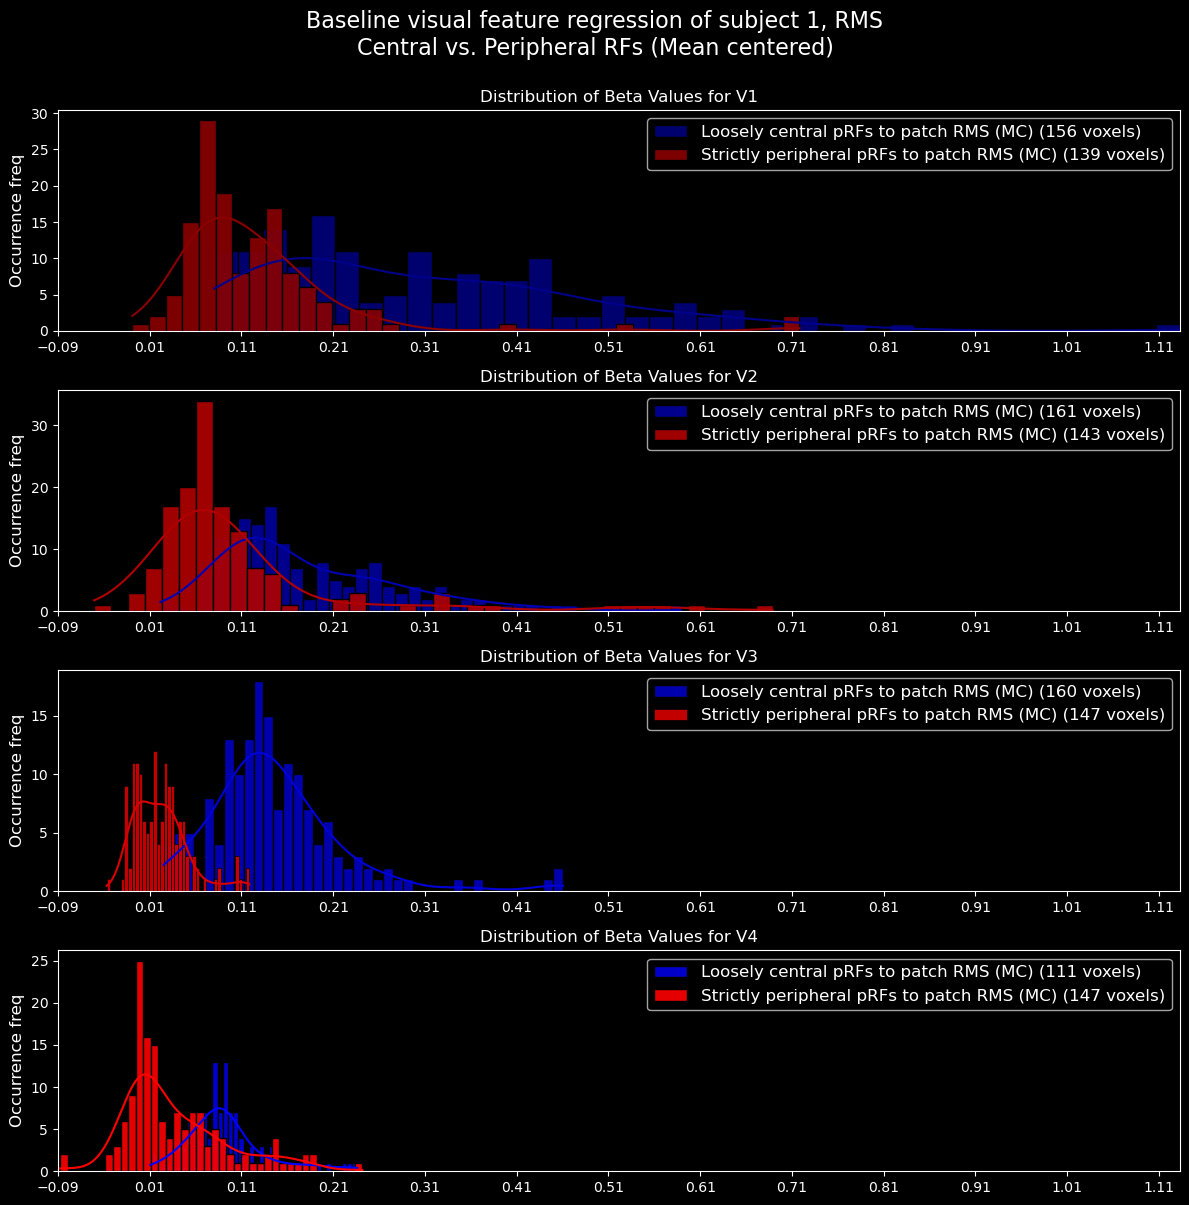

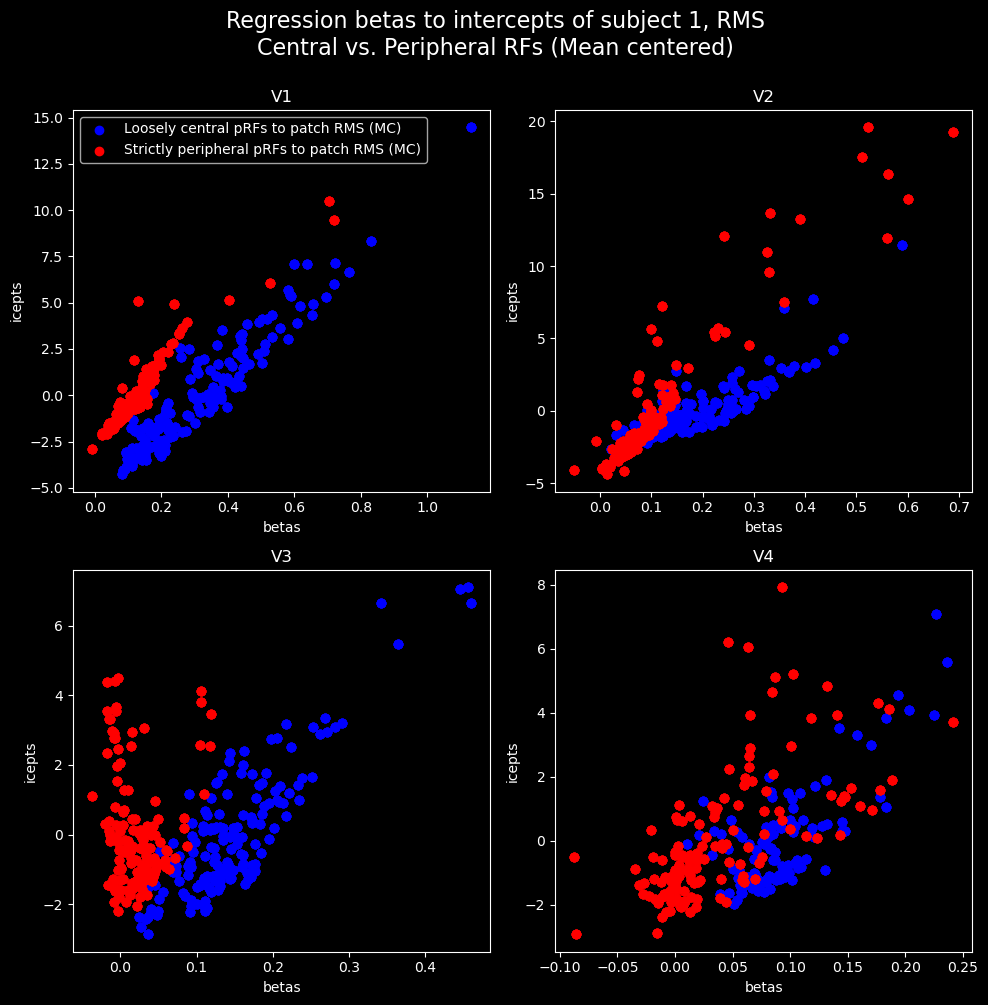

In [55]:

reg_plots(regstash_mc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MC)', comptype = 'Central vs. Peripheral RFs (Mean centered)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)

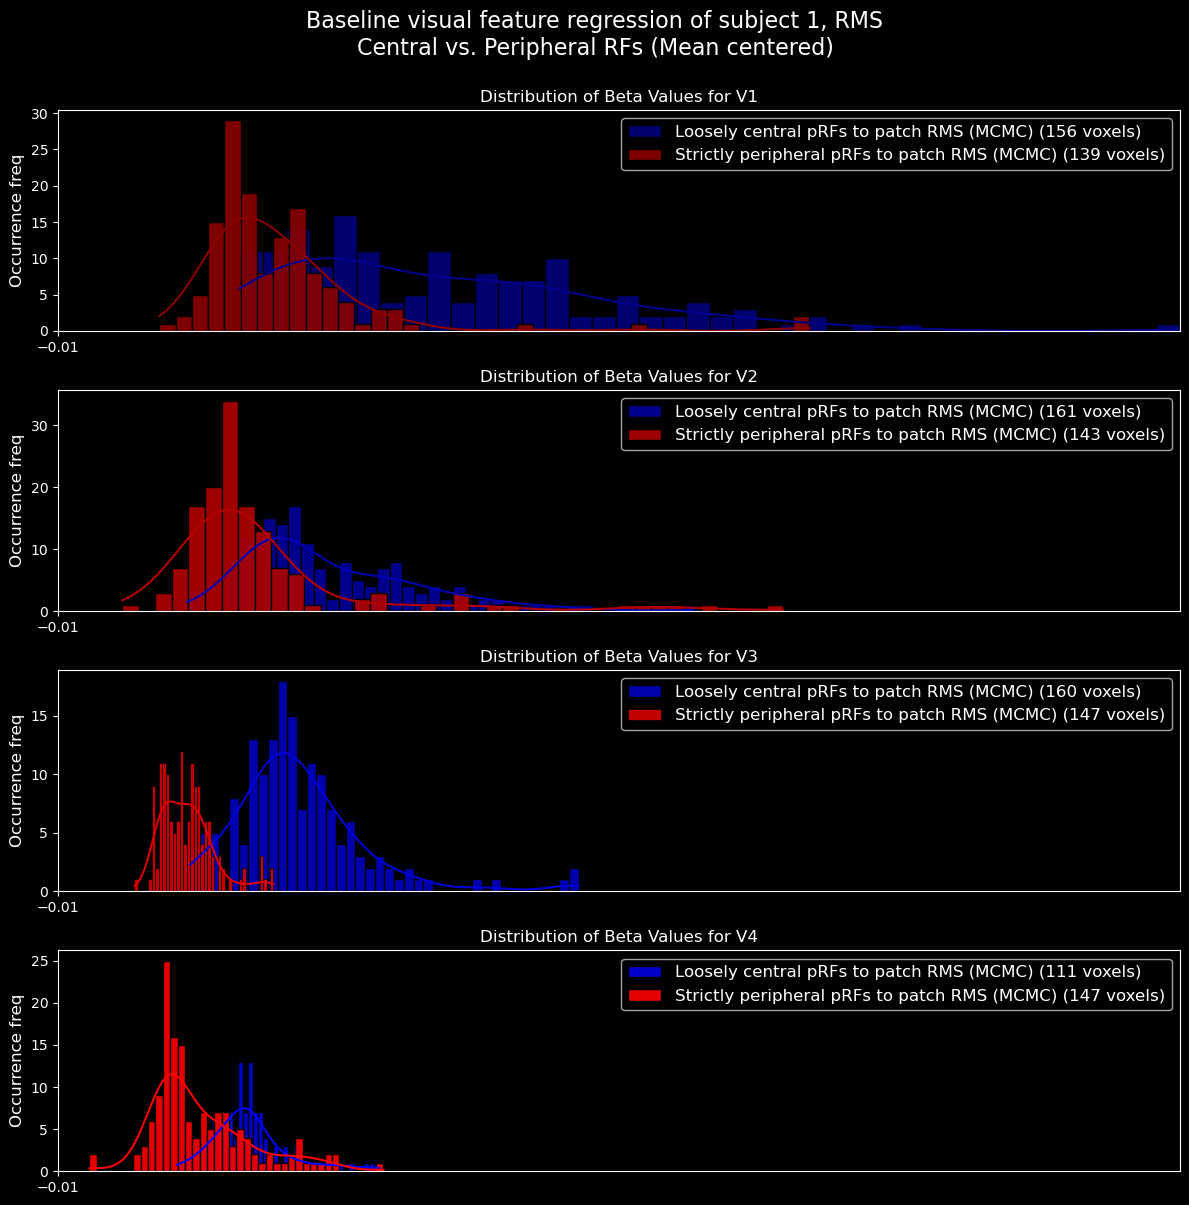

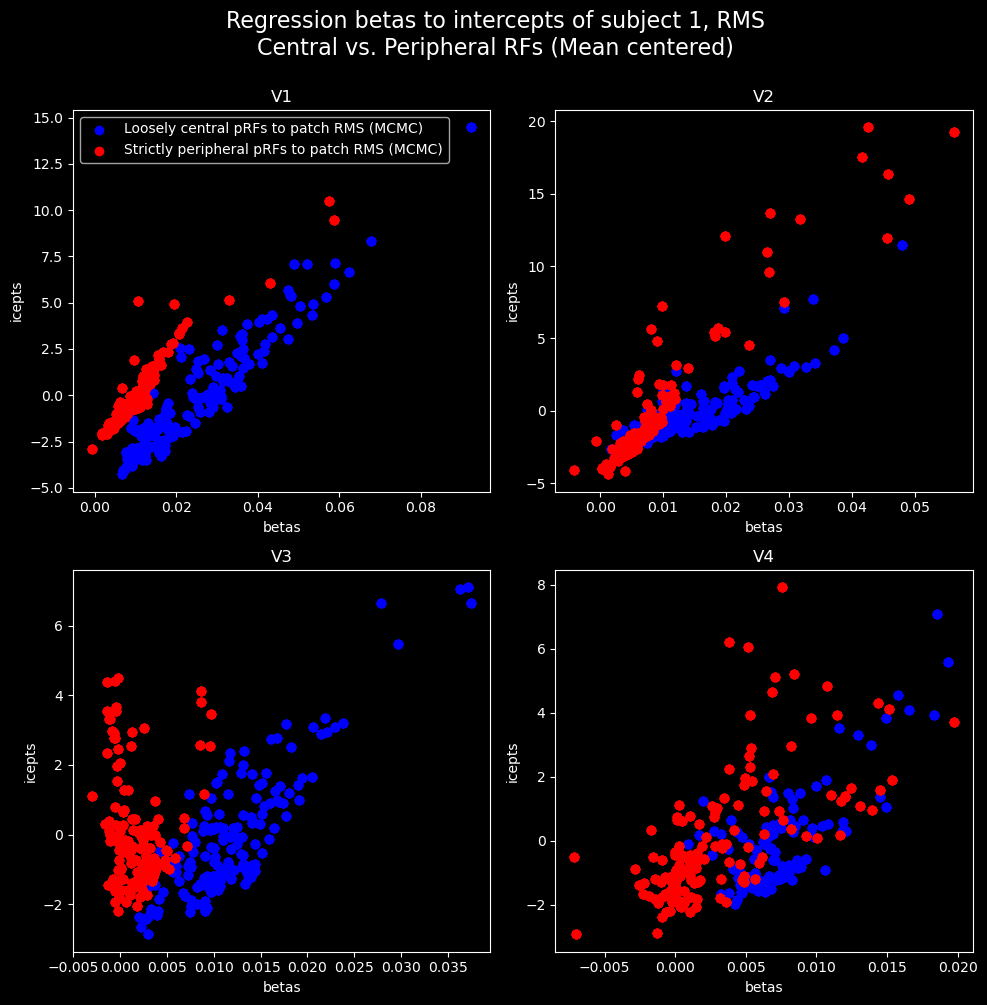

In [56]:

reg_plots(regstash_mcmc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MCMC)', comptype = 'Central vs. Peripheral RFs (Mean centered)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mcmc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MCMC)', beta_hist = True, beta_icept = True)

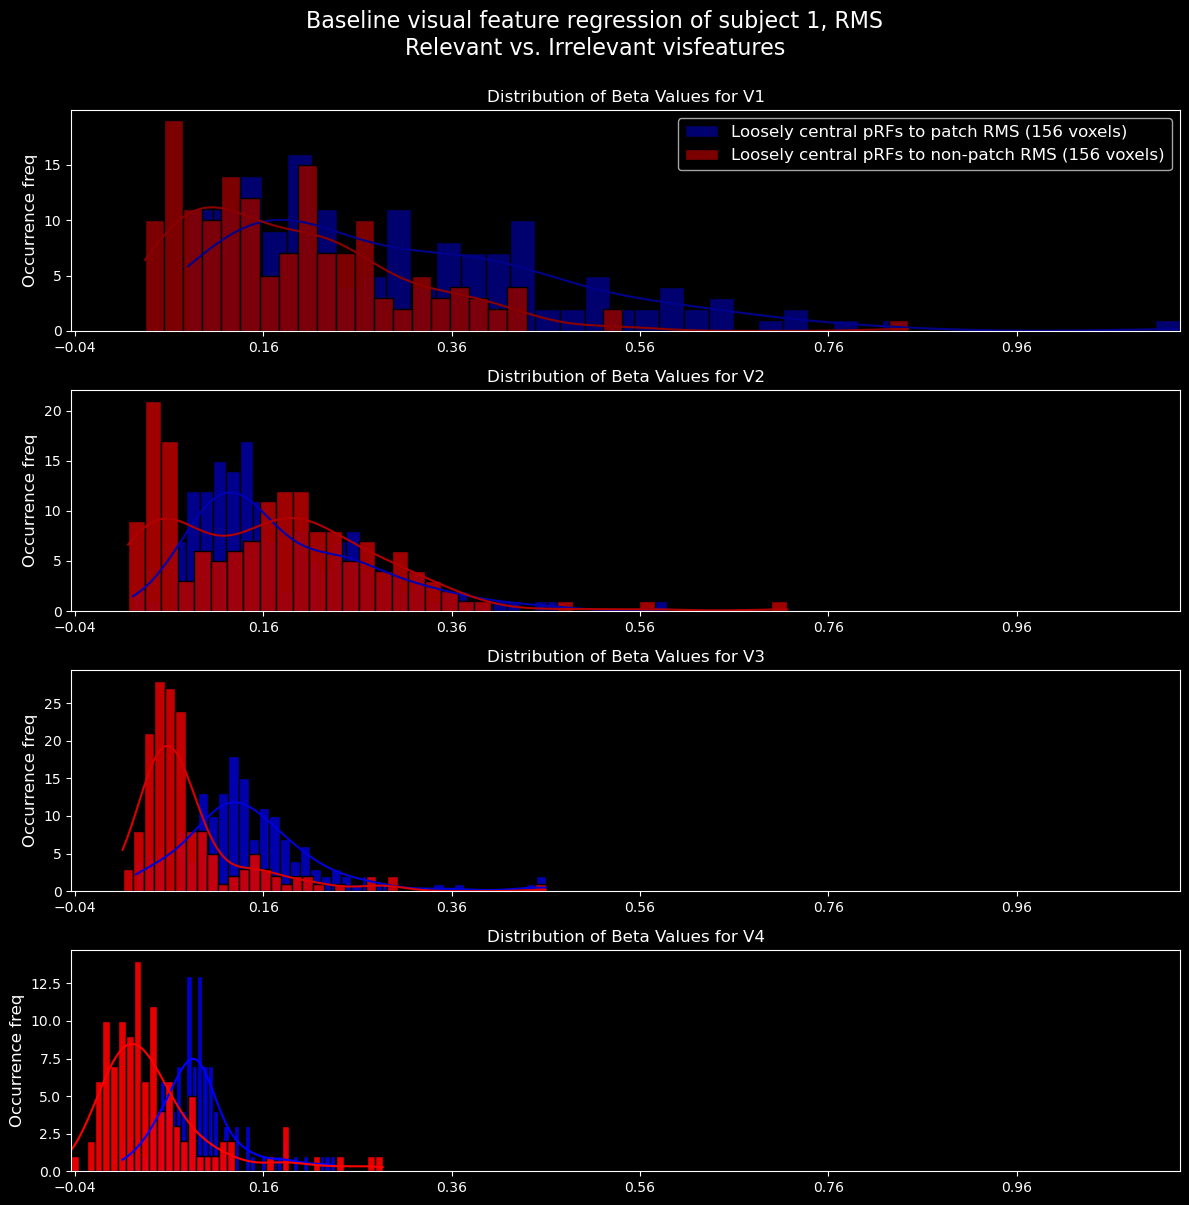

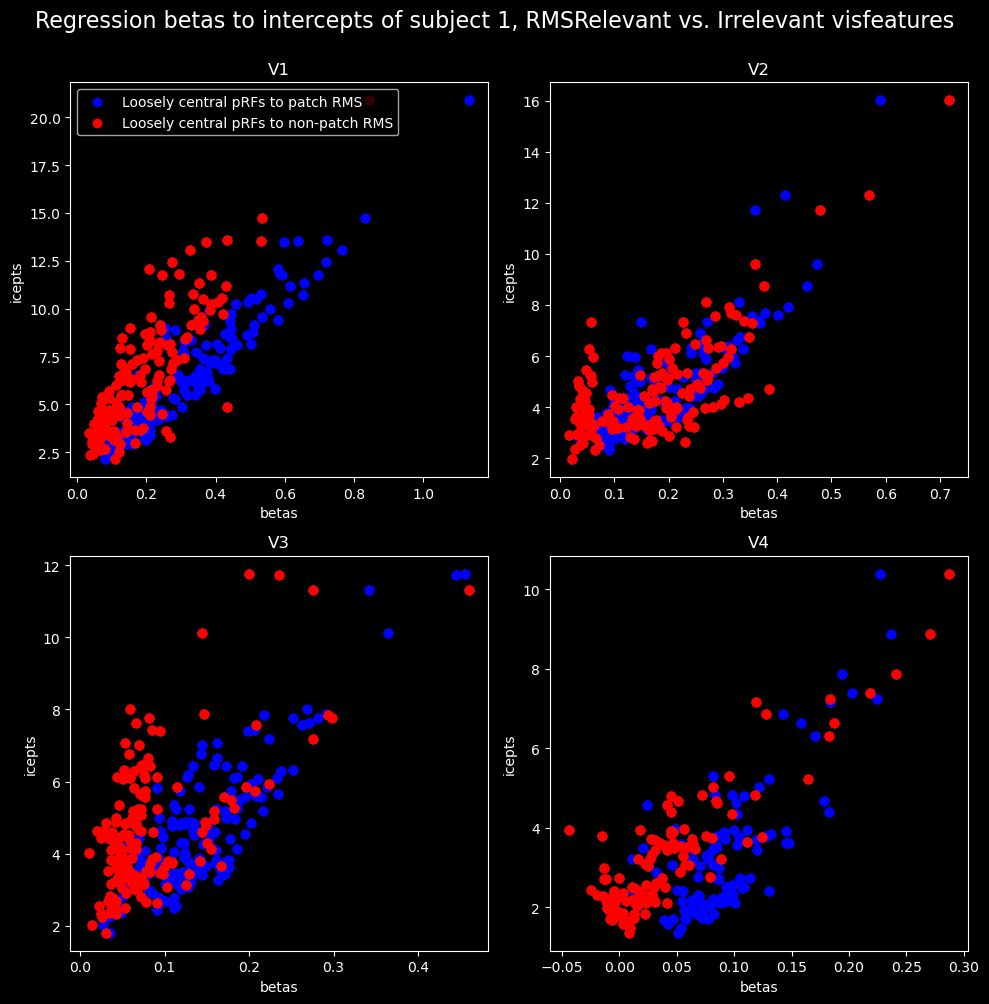

In [23]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['centralprfs']['loose']['irrel'], 
                           dictdescrip2 = 'Loosely central pRFs to non-patch RMS', beta_hist = True, beta_icept = True)

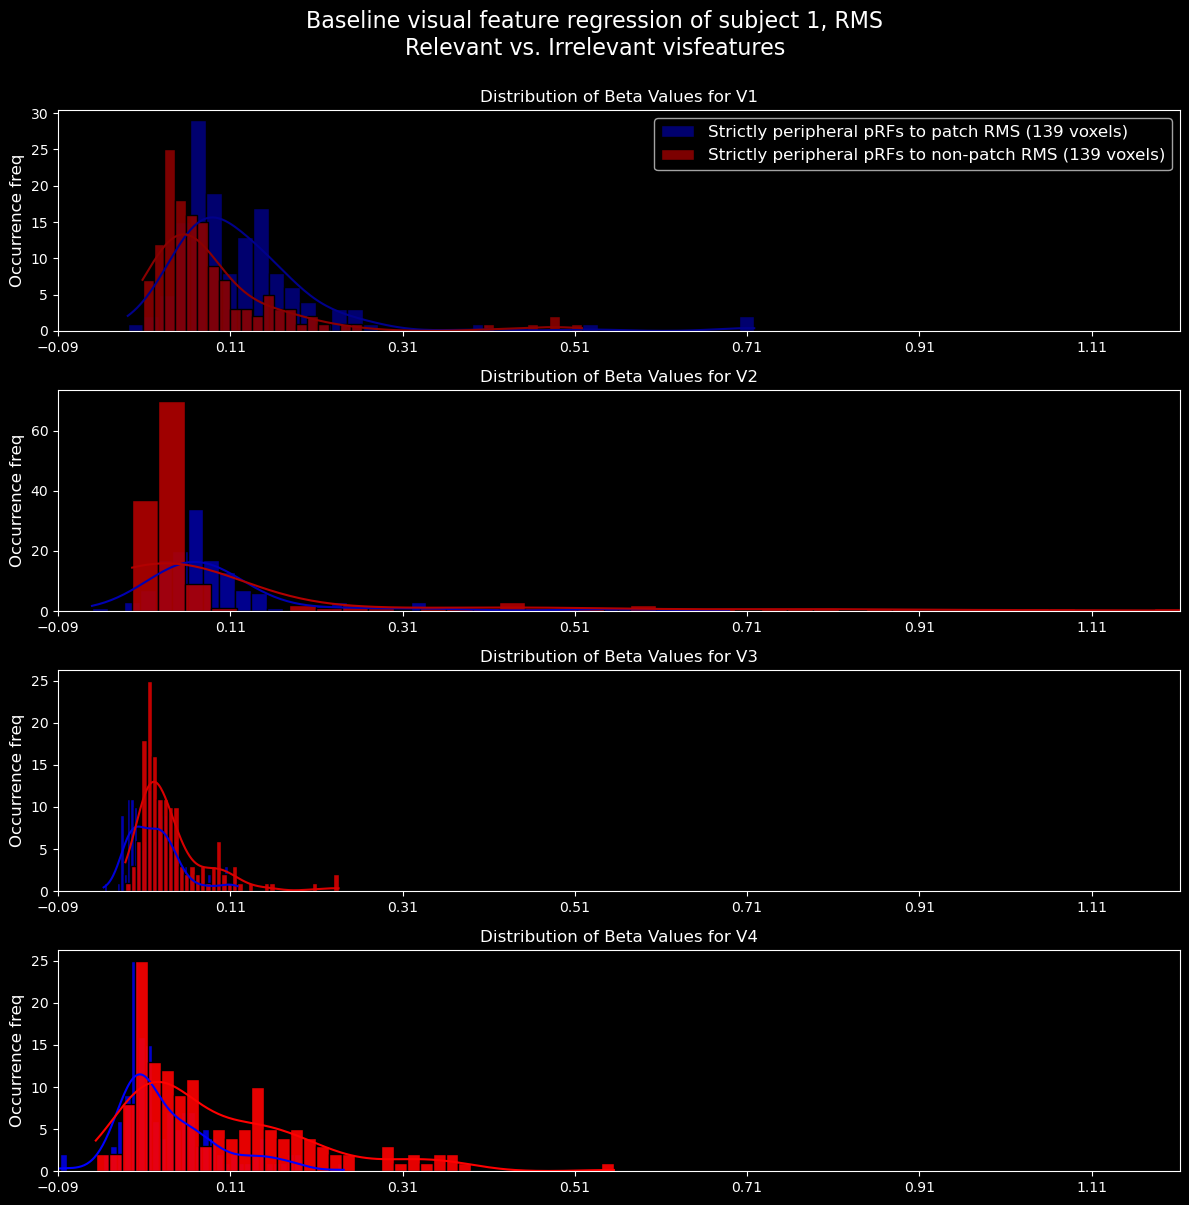

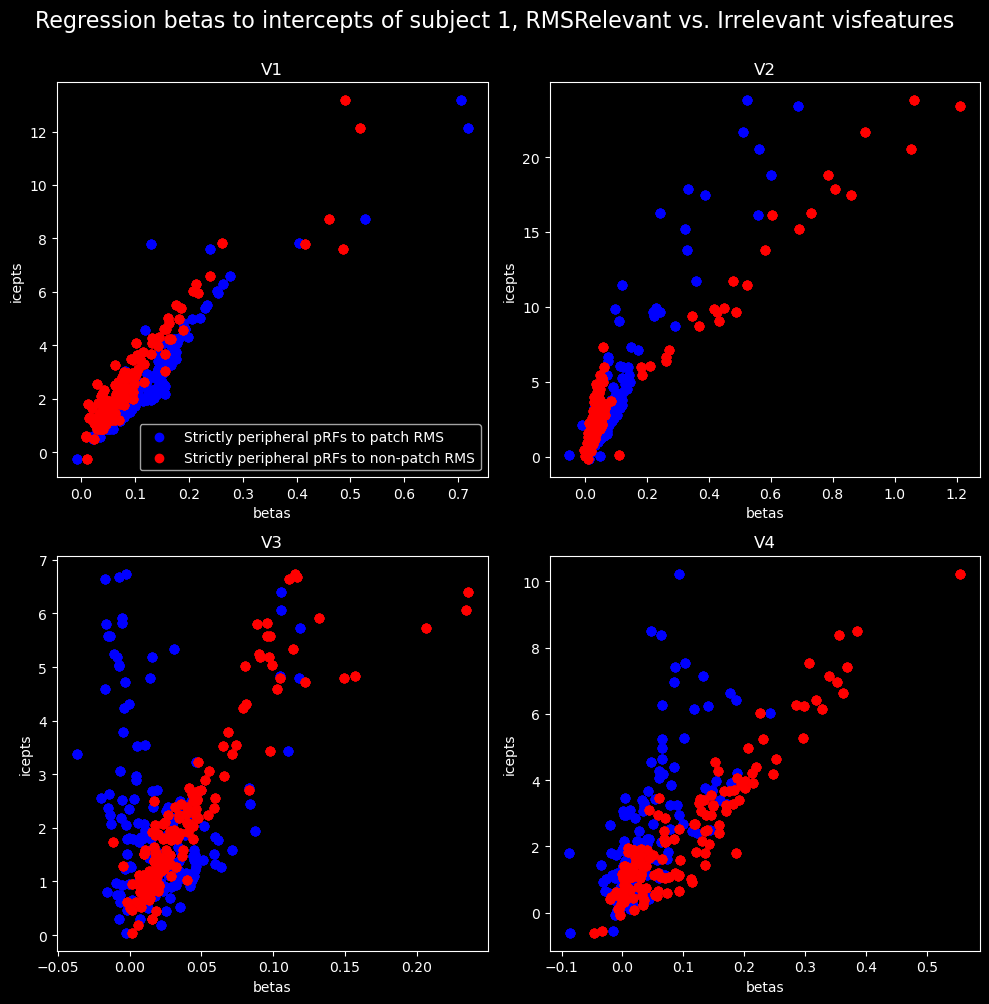

In [22]:

reg_plots(regstash['peripheralprfs']['tight']['rel'], dictdescrip1 = 'Strictly peripheral pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to non-patch RMS', beta_hist = True, beta_icept = True)

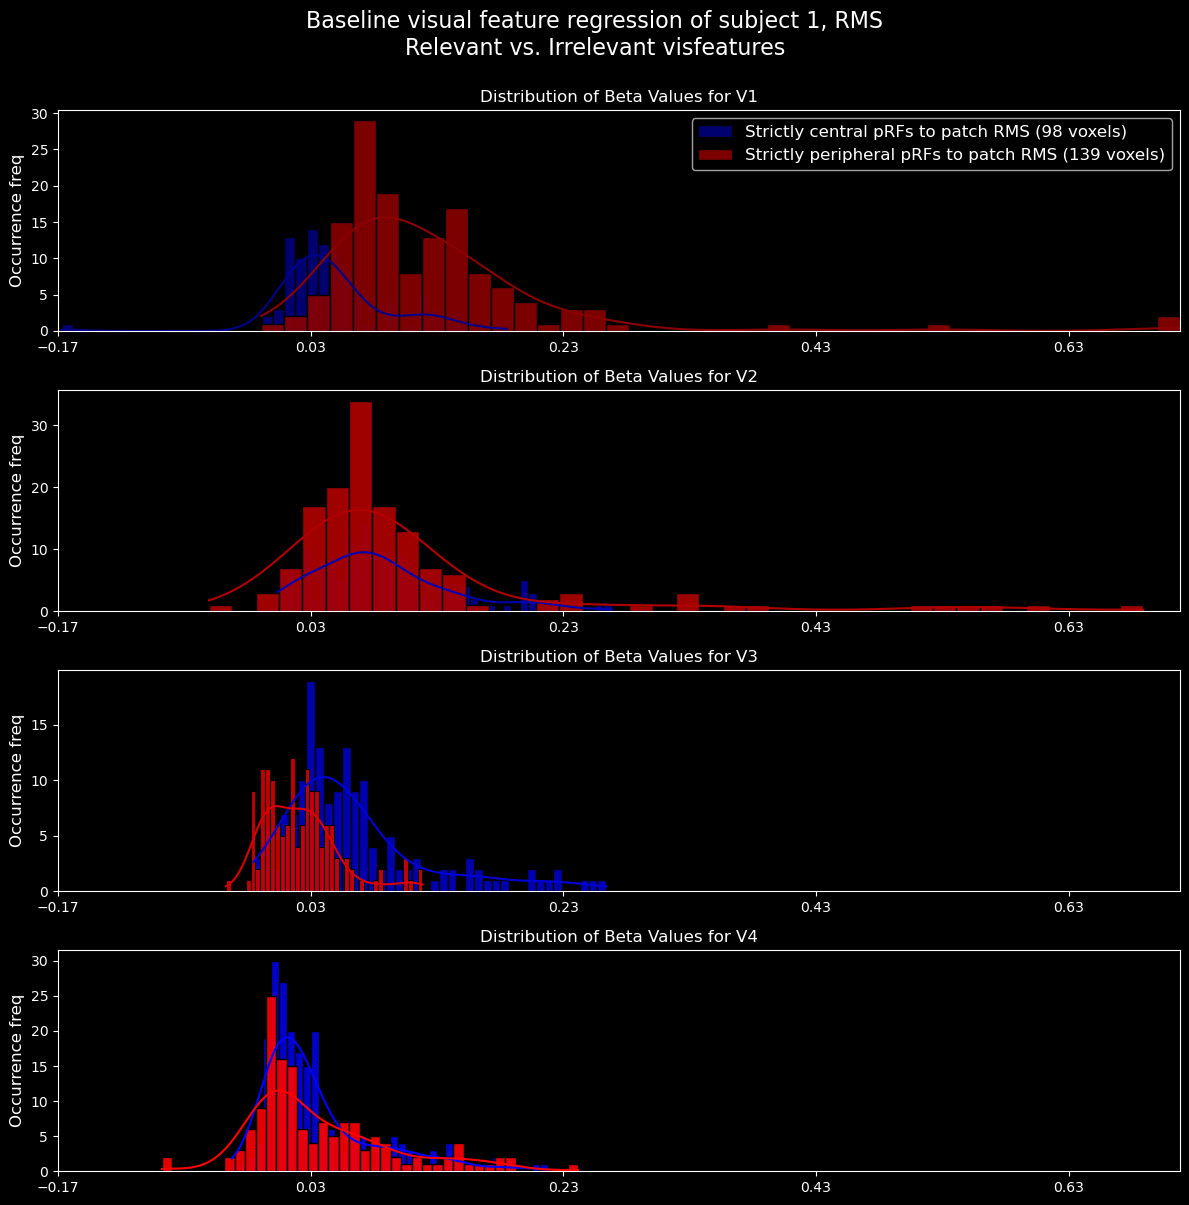

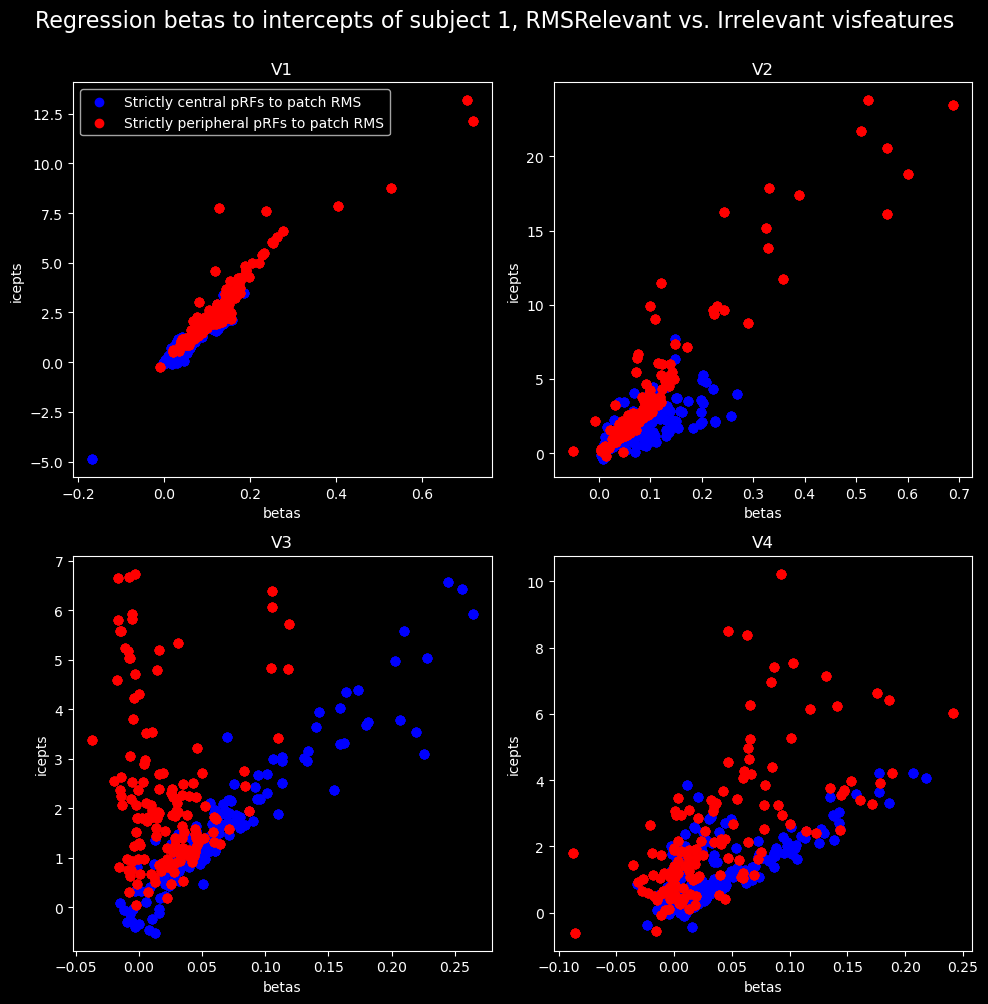

In [27]:

reg_plots(regstash['centralprfs']['tight']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

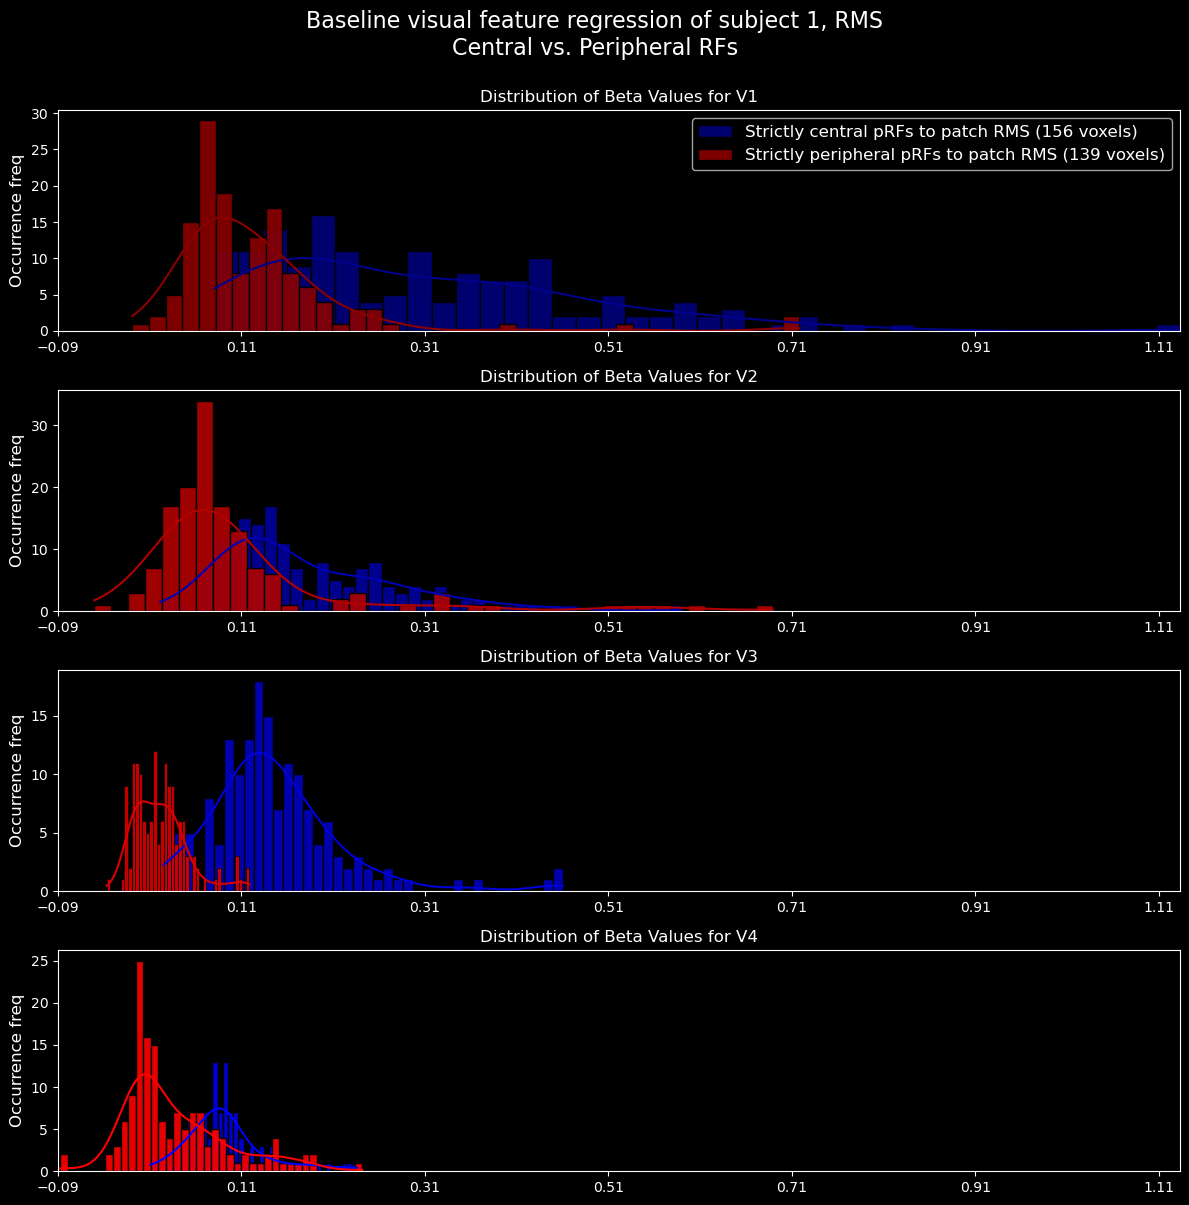

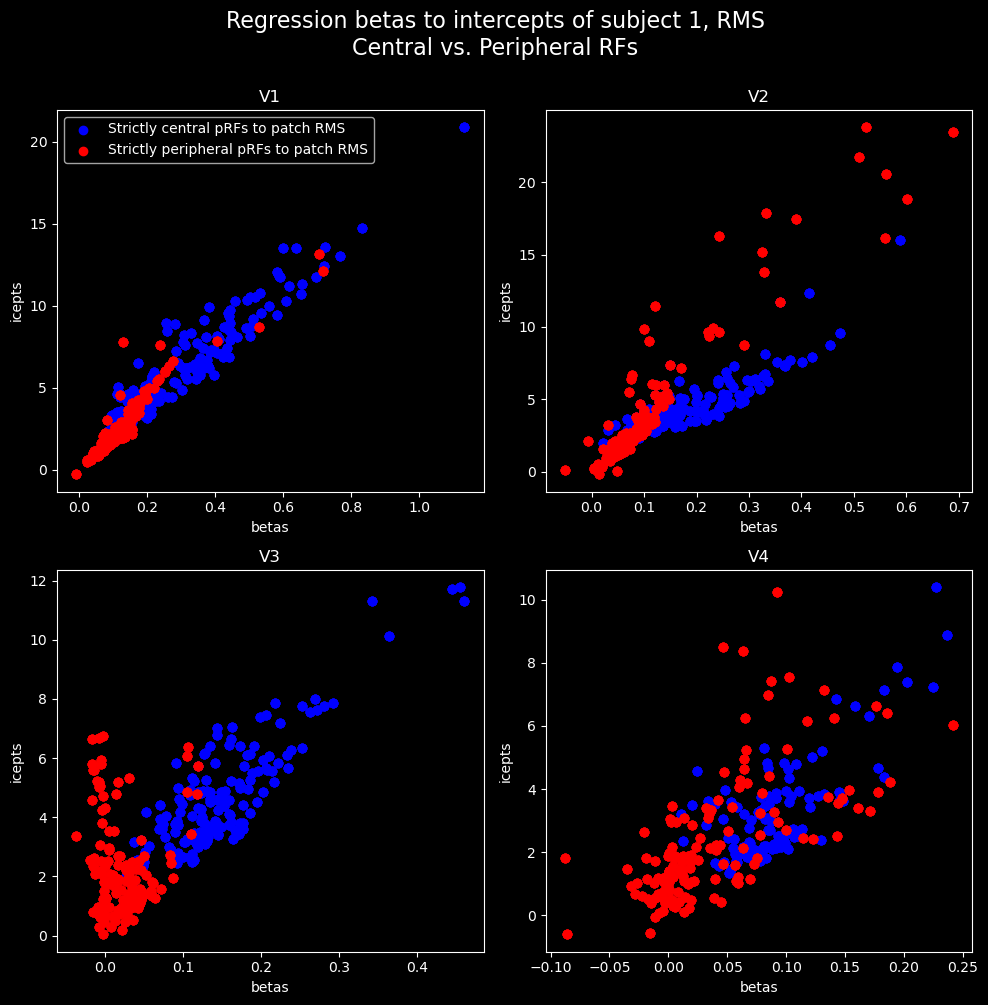

In [26]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

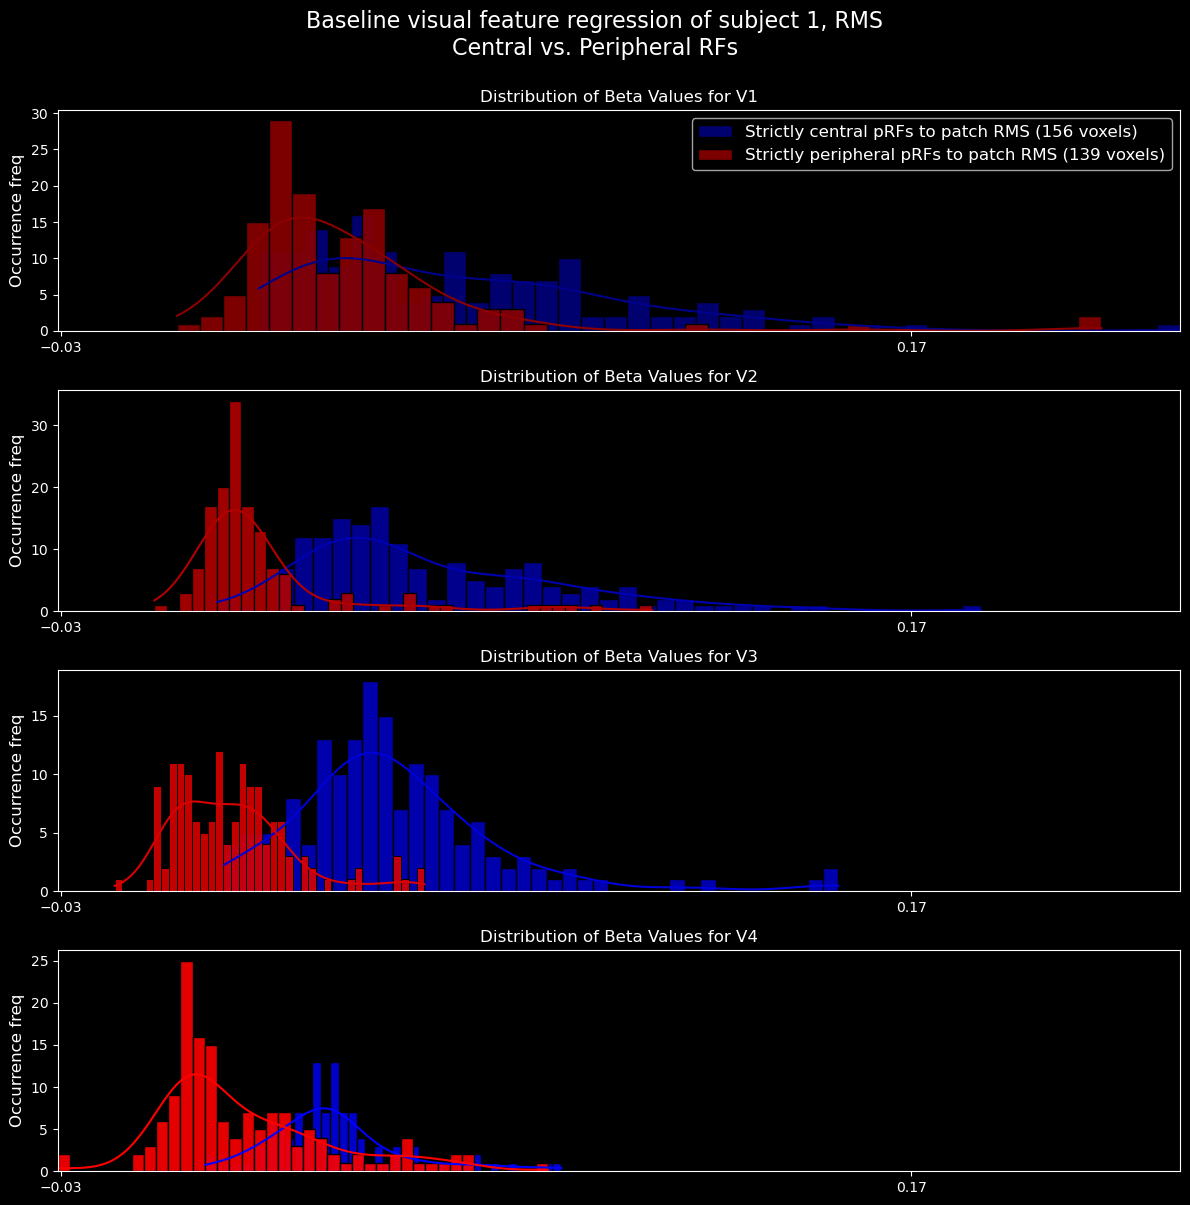

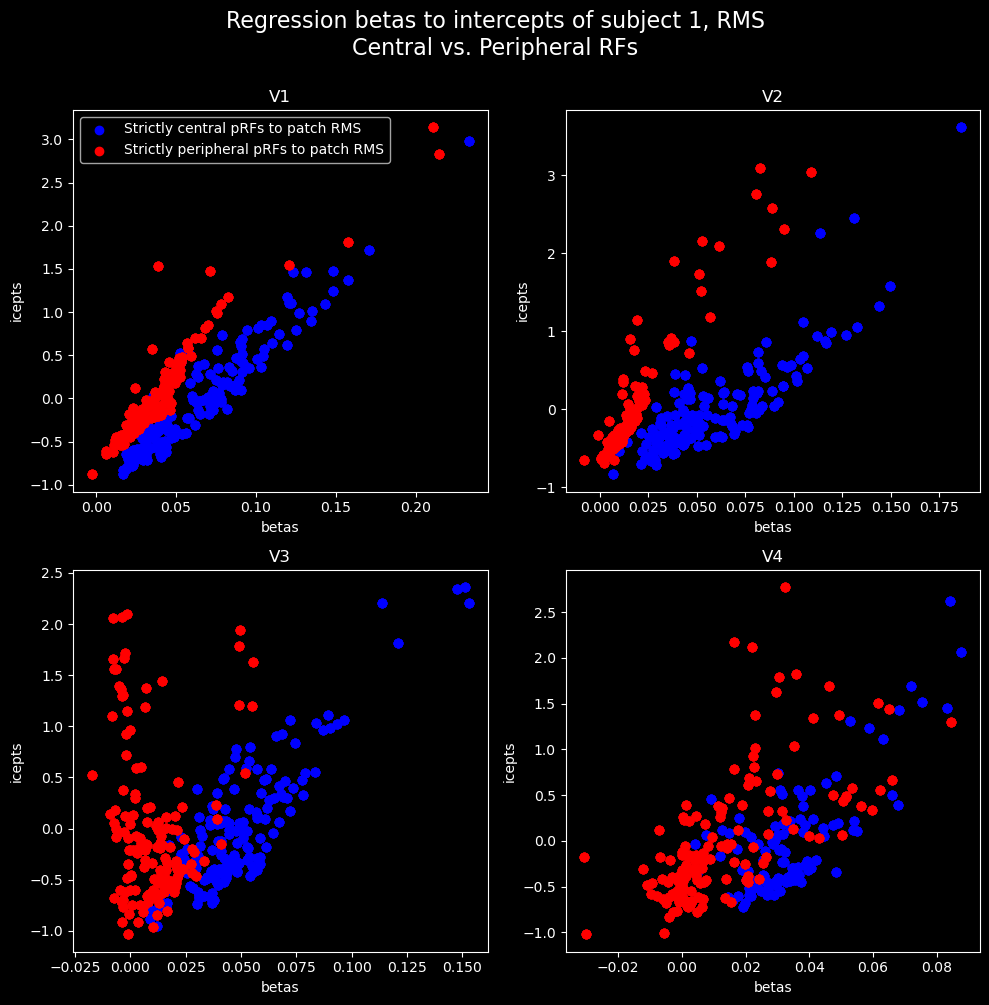

In [27]:

reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

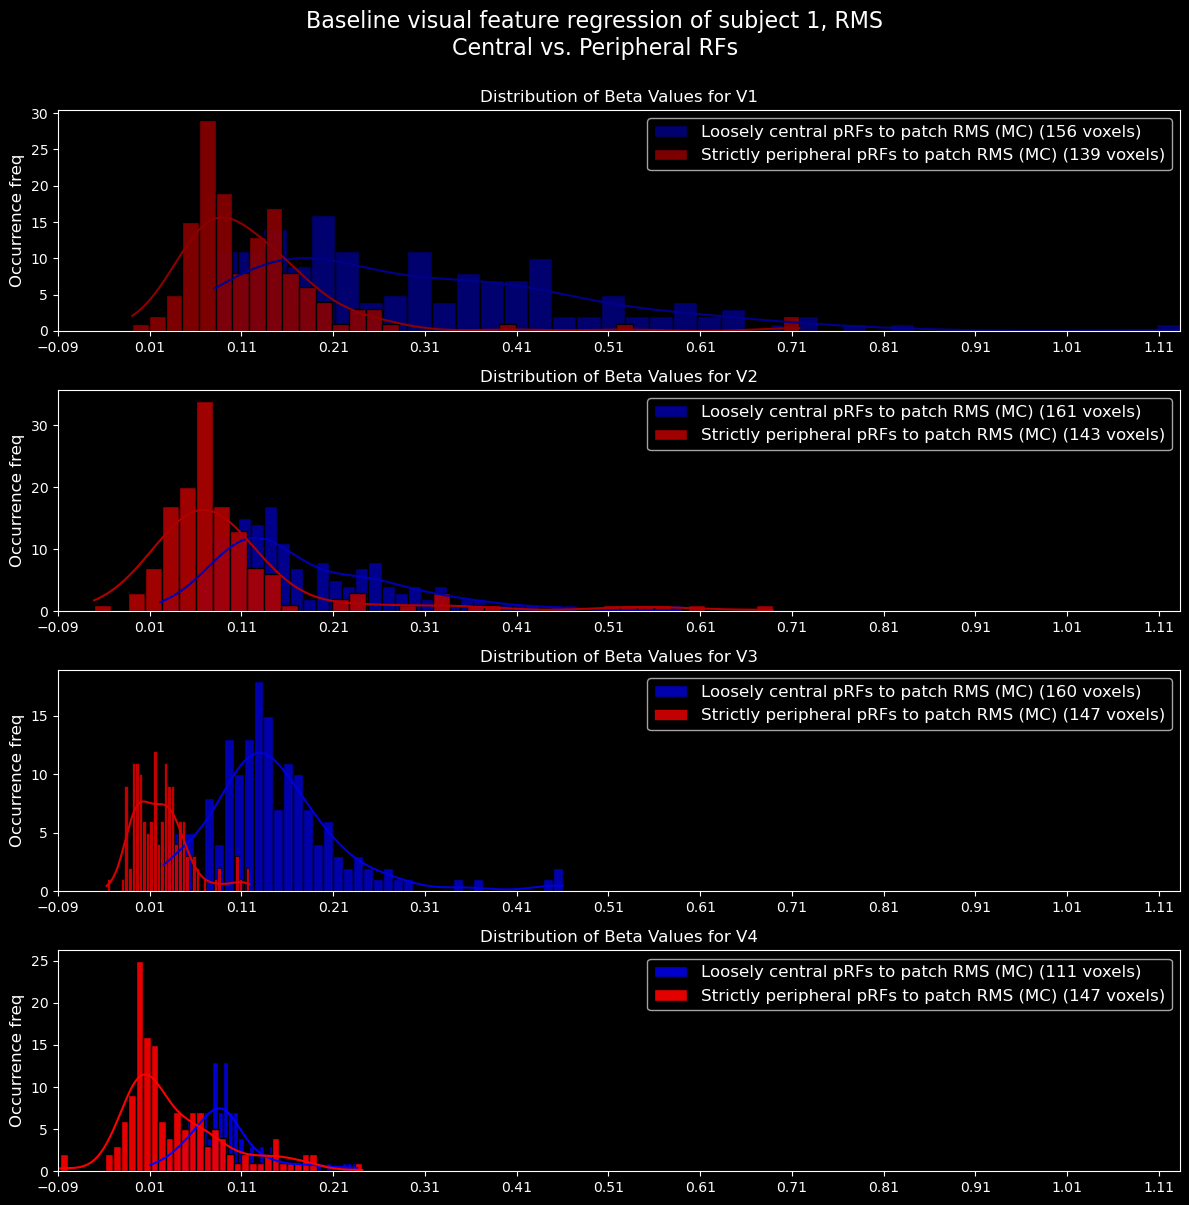

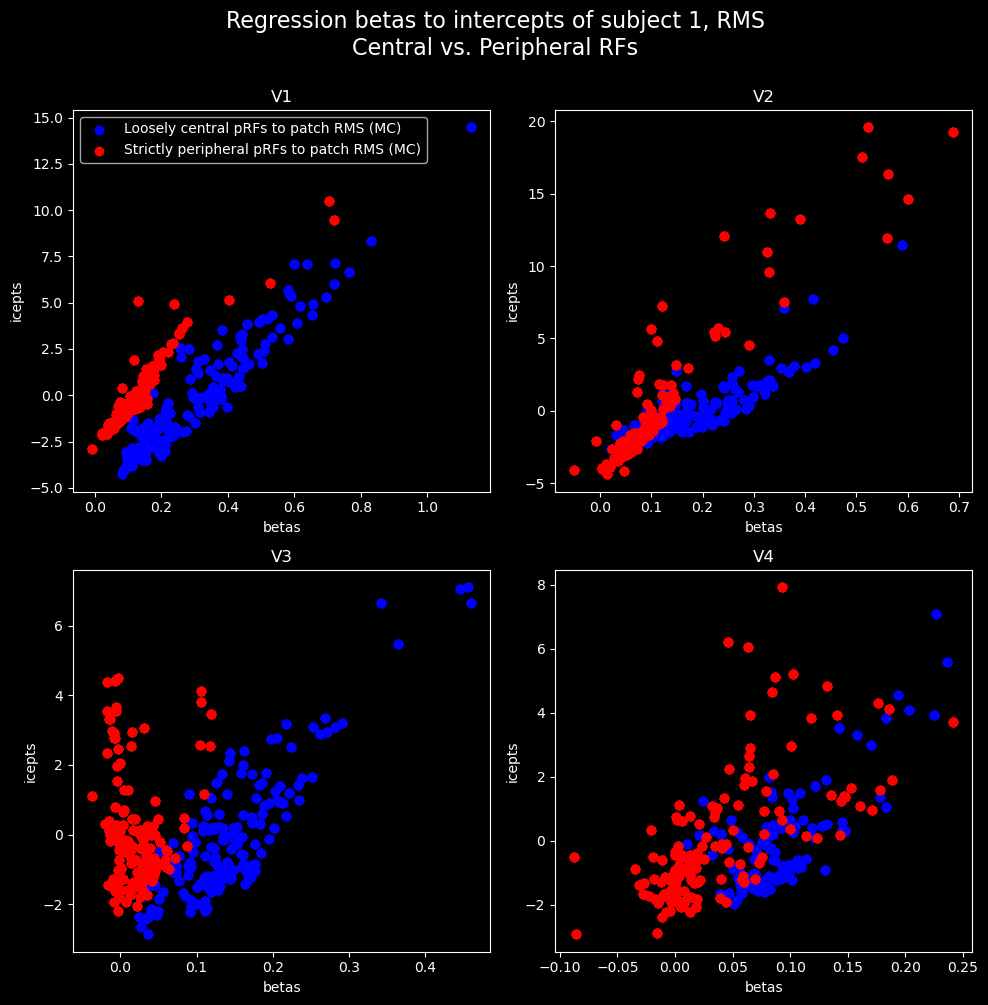

In [17]:

reg_plots(regstash_mc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MC)', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)

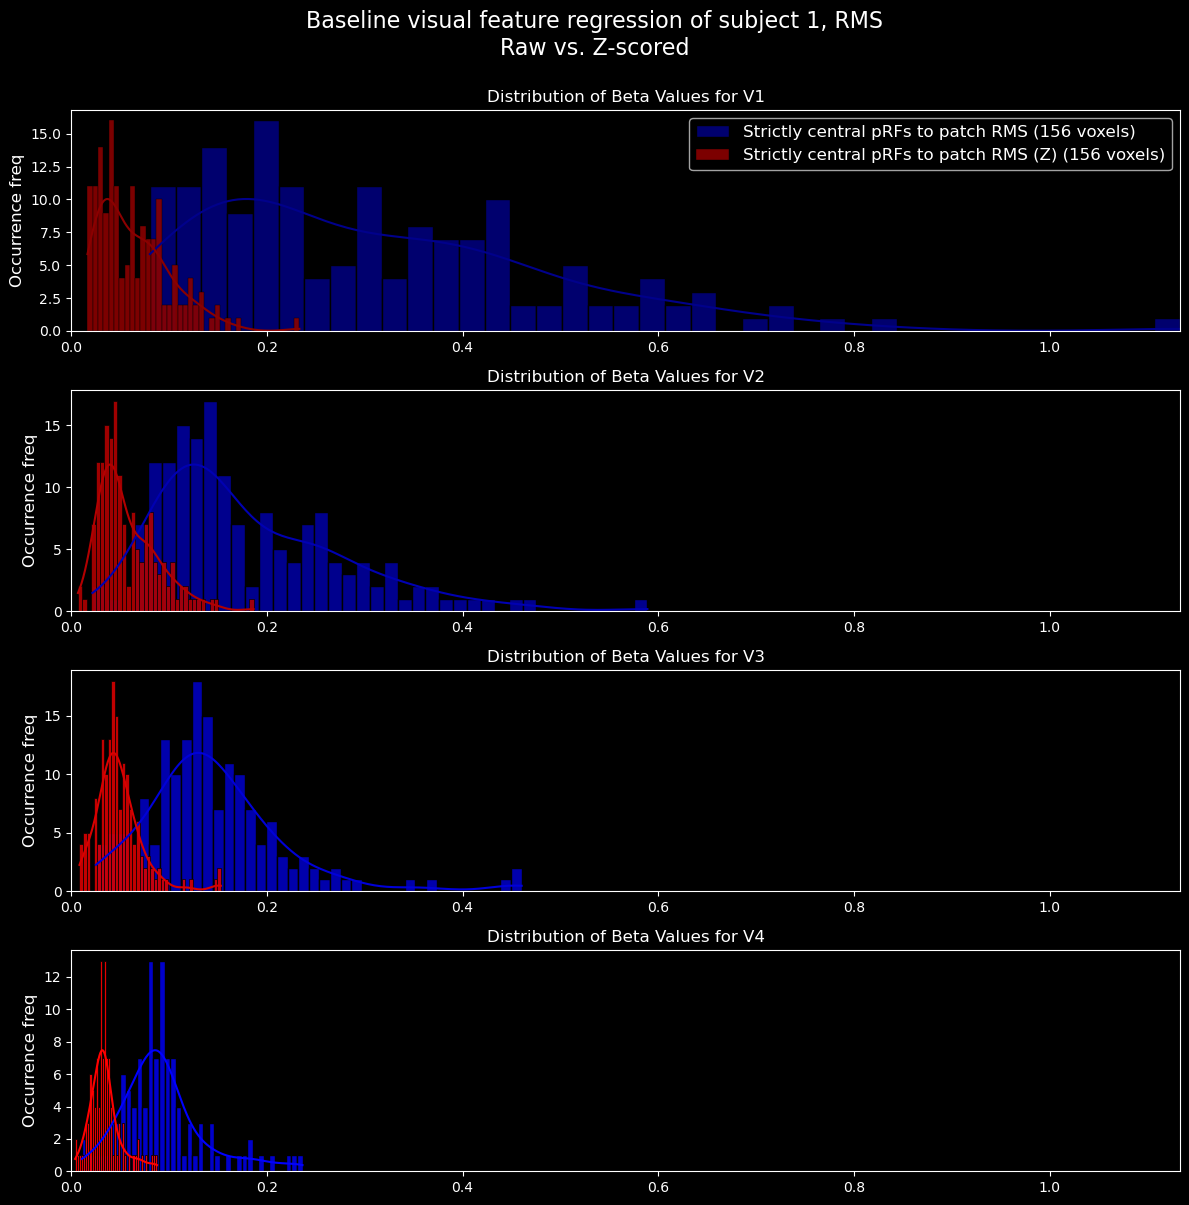

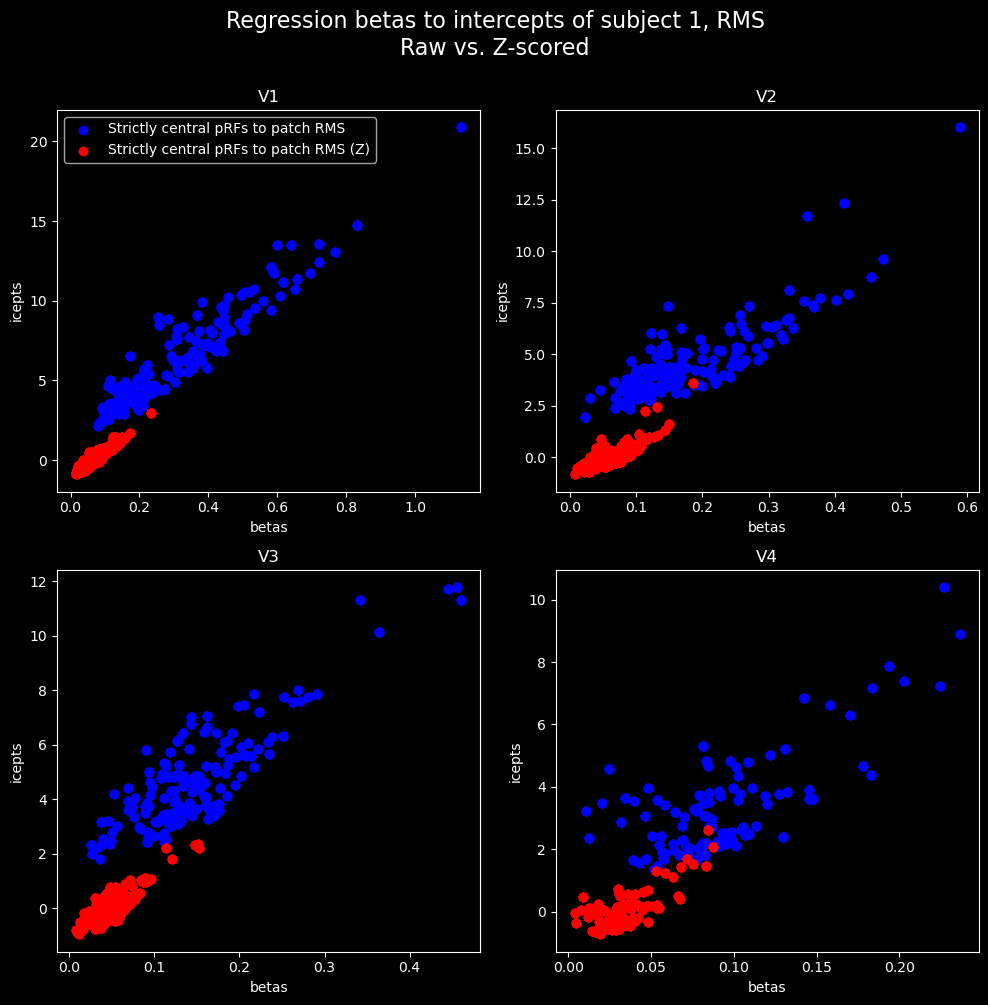

In [18]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Raw vs. Z-scored',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['loose']['rel'], 
                           dictdescrip2 = 'Strictly central pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

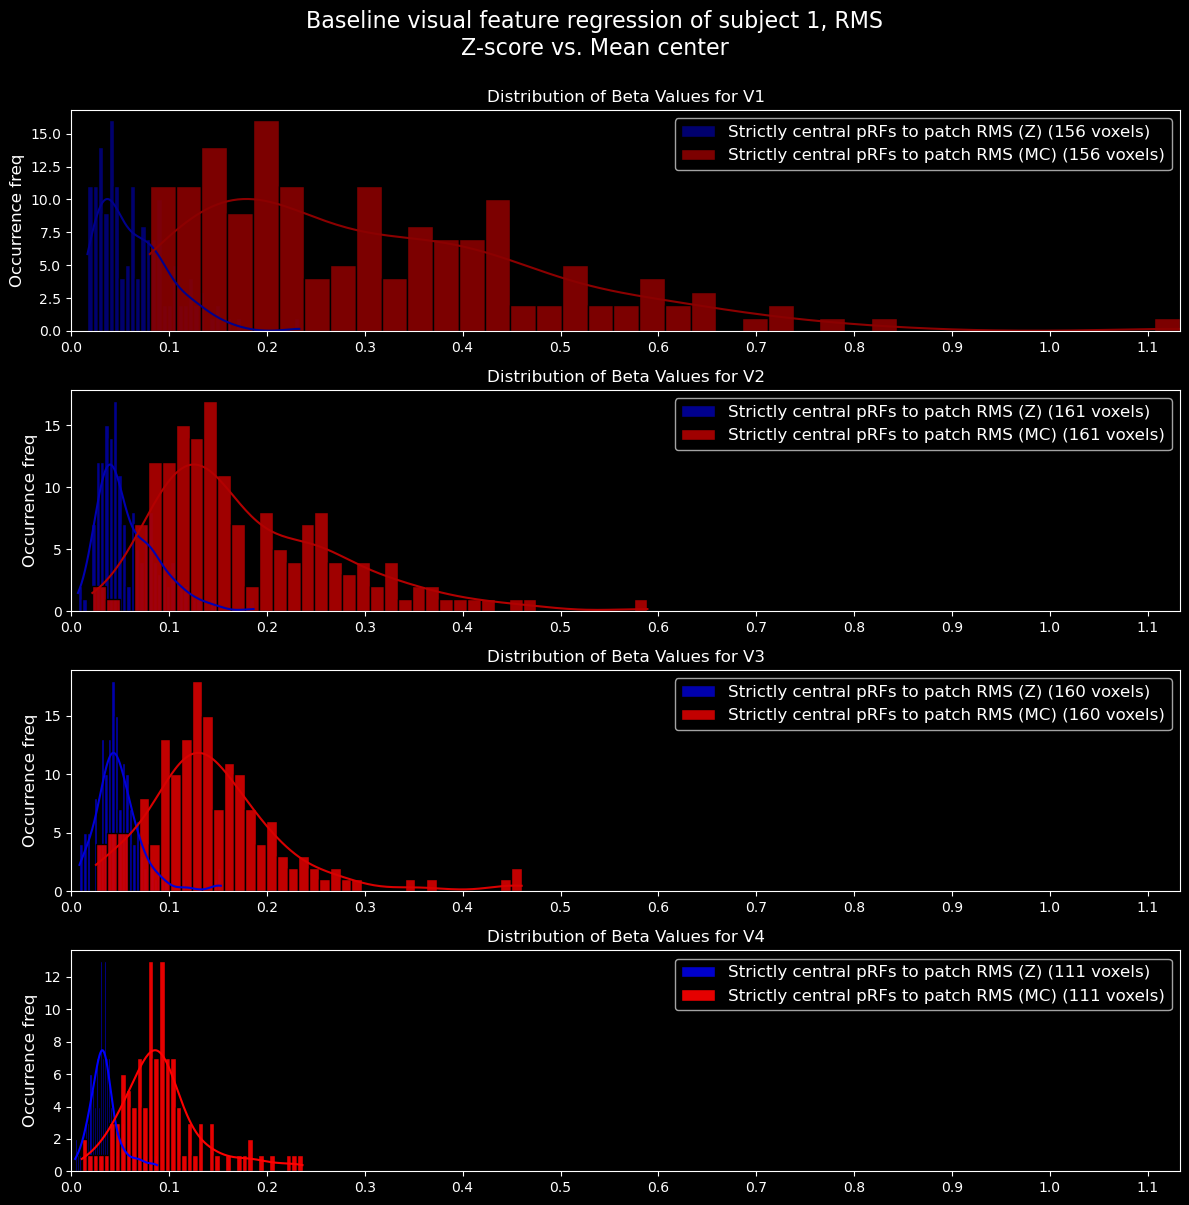

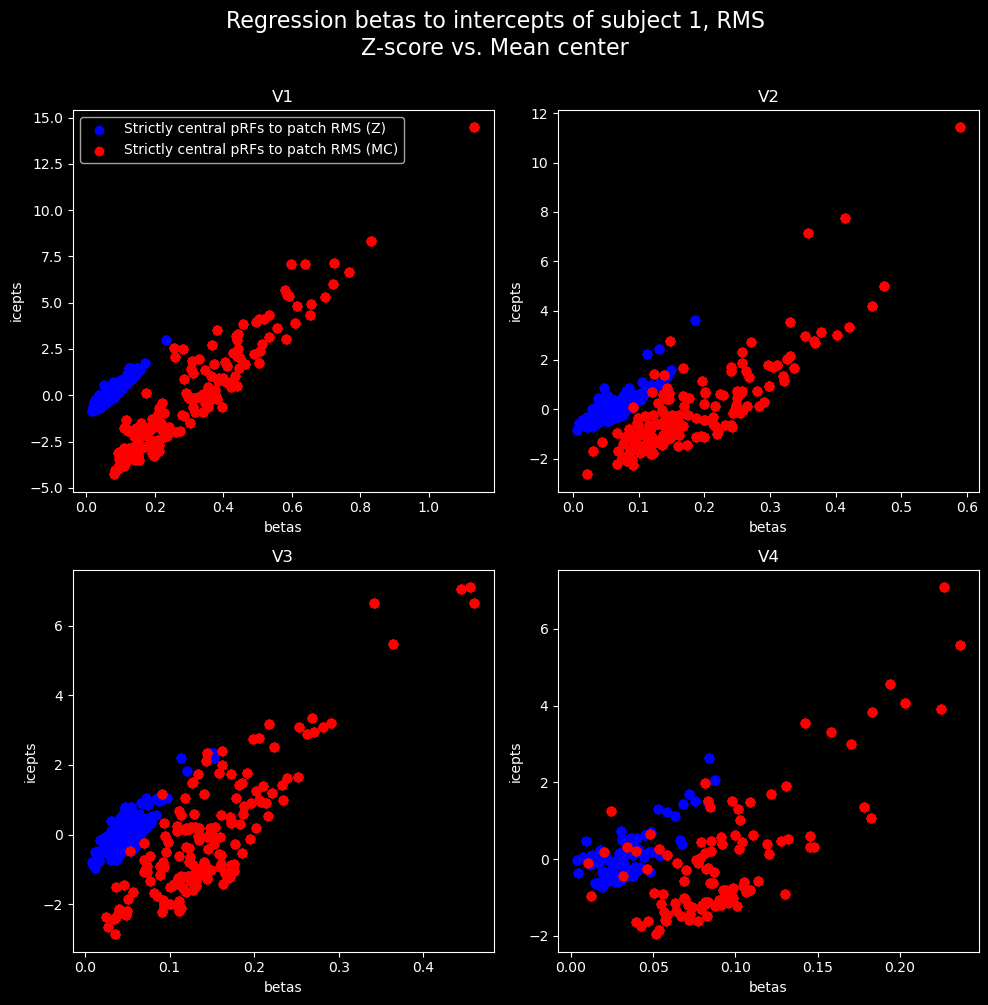

In [18]:

reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS (Z)', comptype = 'Z-score vs. Mean center',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['centralprfs']['loose']['rel'], 
                           dictdescrip2 = 'Strictly central pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)

In [152]:
import importlib
import funcs.imgproc
import funcs.rf_tools
import funcs.utility
import funcs.analyses
import notebooks.alien_nbs.lgnpy.lgnpy.CEandSC

# Reload the modules
importlib.reload(funcs.imgproc)
importlib.reload(funcs.rf_tools)
importlib.reload(funcs.utility)
importlib.reload(funcs.analyses)
importlib.reload(notebooks.alien_nbs.lgnpy.lgnpy.CEandSC)

# Re-import the functions
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots, univariate_regression, multivariate_regression
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

### These two blocks are for checking what the impact is on the R2 values if you actually do add an intercept. Exploratory, not very important

In [121]:
# This one is for the separate X matrices I guess, but perhaps not even that important apart from having the separate regdicts from specific comparisons

subj = 'subj01'


# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_z, X_rms_rel = regression_dict_multivariate(subj, 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior[subj]['rms'], fit_intercept = True, n_imgs=30000, z_scorey = True)

regdict_prfc_tight_rmsirrel_z, X_rms_irrel = regression_dict_multivariate(subj, 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior[subj]['rms_irrelevant'], fit_intercept = True, n_imgs=30000, z_scorey = True)

# Spatial Coherence 1 degree

regdict_prfc_tight_screl_z, X_sc_rel = regression_dict_multivariate(subj, 'sc_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce'].replace([np.nan, np.NINF], 0.000000001), fit_intercept = True, n_imgs=30000, z_scorey = True)

regdict_prfc_tight_scirrel_z, X_sc_irrel = regression_dict_multivariate(subj, 'sc_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'].replace([np.nan, np.NINF], 0.000000001), fit_intercept = True, n_imgs=30000, z_scorey = True)


# Contrast energy 1 degree

regdict_prfc_tight_cerel_z, X_ce_rel = regression_dict_multivariate(subj, 'ce_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce'], fit_intercept = True, n_imgs=30000, z_scorey = True)

regdict_prfc_tight_ceirrel_z, X_ce_irrel = regression_dict_multivariate(subj, 'ce_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'], fit_intercept = True, n_imgs=30000, z_scorey = True)

# Spatial Coherence 2.8 degrees

regdict_prfc_tight_screl_large_z, X_sc_large_rel = regression_dict_multivariate(subj, 'sc_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce'].replace([np.nan, np.NINF], 0.000000001), fit_intercept = True, n_imgs=30000, z_scorey = True)

regdict_prfc_tight_scirrel_large_z, X_sc_large_irrel = regression_dict_multivariate(subj, 'sc_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce_irrelevant'].replace([np.nan, np.NINF], 0.000000001), fit_intercept = True, n_imgs=30000, z_scorey = True)


# Contrast energy 2.8 degrees

regdict_prfc_tight_cerel_large_z, X_ce_large_rel = regression_dict_multivariate(subj, 'ce_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce'], fit_intercept = True, n_imgs=30000, z_scorey = True)

regdict_prfc_tight_ceirrel_large_z, X_ce_large_irrel = regression_dict_multivariate(subj, 'ce_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce_irrelevant'], fit_intercept = True, n_imgs=30000, z_scorey = True)



In [122]:
print('patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_rmsrel_z[f"V{i}_mask"]["rsquared"]}')
print('non-patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_rmsirrel_z[f"V{i}_mask"]["rsquared"]}')
print('\n')
print('patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_screl_z[f"V{i}_mask"]["rsquared"]}')
print('non-patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_scirrel_z[f"V{i}_mask"]["rsquared"]}')
print('\n')
print('patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_cerel_z[f"V{i}_mask"]["rsquared"]}')
print('non-patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_ceirrel_z[f"V{i}_mask"]["rsquared"]}')
print('\n')
print('patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_screl_large_z[f"V{i}_mask"]["rsquared"]}')
print('non-patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_scirrel_large_z[f"V{i}_mask"]["rsquared"]}')
print('\n')
print('patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_cerel_large_z[f"V{i}_mask"]["rsquared"]}')
print('non-patch:')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regdict_prfc_tight_ceirrel_large_z[f"V{i}_mask"]["rsquared"]}')
print('\n')


patch:
RMS V1: 0.00301146476206041
RMS V2: 0.003682259554106841
RMS V3: 0.0045435159423007875
RMS V4: 0.0026503273676068825
non-patch:
RMS V1: 0.00023716117211362698
RMS V2: 0.00011471877071603922
RMS V3: 0.00025022069993797834
RMS V4: 0.00014982417019290817


patch:
RMS V1: 0.00019874282104835944
RMS V2: 0.00041068350383626835
RMS V3: 0.00041100473015921827
RMS V4: 0.0001228047880992912
non-patch:
RMS V1: 0.000135930133807477
RMS V2: 0.00016465895797037857
RMS V3: 0.00017122512544085047
RMS V4: 6.465214312087032e-05


patch:
RMS V1: 0.006687738363586763
RMS V2: 0.012195975247192976
RMS V3: 0.011831771004481512
RMS V4: 0.0063725066412727805
non-patch:
RMS V1: 0.0005154275617012649
RMS V2: 0.0004749733665513456
RMS V3: 0.00040739681110076124
RMS V4: 8.355716424462422e-05


patch:
RMS V1: 0.0004924047513077956
RMS V2: 0.000536355617903748
RMS V3: 0.0004503831343535047
RMS V4: 7.476526416871293e-05
non-patch:
RMS V1: 0.00011515722349836765
RMS V2: 0.00013288941937768158
RMS V3: 0.00012184

### More neat workout of the crucial comparisons, all three current visual contrast features: Root Mean Square (RMS), Contrast Energy (CE), and Spatial Coherence (SC)

In [123]:
# This one is for the separate X matrices I guess, but perhaps not even that important apart from having the separate regdicts from specific comparisons

subj = 'subj01'


# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_z, X_rms_rel = regression_dict_multivariate(subj, 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior[subj]['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_rmsirrel_z, X_rms_irrel = regression_dict_multivariate(subj, 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms_crop_prior[subj]['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Spatial Coherence 1 degree

regdict_prfc_tight_screl_z, X_sc_rel = regression_dict_multivariate(subj, 'sc_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)

regdict_prfc_tight_scirrel_z, X_sc_irrel = regression_dict_multivariate(subj, 'sc_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)


# Contrast energy 1 degree

regdict_prfc_tight_cerel_z, X_ce_rel = regression_dict_multivariate(subj, 'ce_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_ceirrel_z, X_ce_irrel = regression_dict_multivariate(subj, 'ce_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce[subj]['scce_irrelevant'], n_imgs=30000, z_scorey = True)

# Spatial Coherence 2.8 degrees

regdict_prfc_tight_screl_large_z, X_sc_large_rel = regression_dict_multivariate(subj, 'sc_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)

regdict_prfc_tight_scirrel_large_z, X_sc_large_irrel = regression_dict_multivariate(subj, 'sc_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce_irrelevant'].replace([np.nan, np.NINF], 0.000000001), n_imgs=30000, z_scorey = True)


# Contrast energy 2.8 degrees

regdict_prfc_tight_cerel_large_z, X_ce_large_rel = regression_dict_multivariate(subj, 'ce_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_ceirrel_large_z, X_ce_large_irrel = regression_dict_multivariate(subj, 'ce_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_scce_large[subj]['scce_irrelevant'], n_imgs=30000, z_scorey = True)



In [124]:
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'RMS V{i}: {regstash_z_crop_prior_subj2["centralprfs"]["tight"]["irrel"][f"V{i}_mask"]["rsquared"]}')
print('\n')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'CE 1 deg V{i}: {regstash_ce_z["centralprfs"]["tight"]["irrel"][f"V{i}_mask"]["rsquared"]}') 
print('\n')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'CE 2.8 deg V{i}: {regstash_ce_large_z["centralprfs"]["tight"]["irrel"][f"V{i}_mask"]["rsquared"]}')
print('\n')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'SC 1 deg V{i}: {regstash_sc_z["centralprfs"]["tight"]["irrel"][f"V{i}_mask"]["rsquared"]}') 
print('\n')
for i in range(1, 4+1):  # replace n with the number of elements in your series
    print(f'SC 2.8 deg V{i}: {regstash_sc_large_z["centralprfs"]["tight"]["irrel"][f"V{i}_mask"]["rsquared"]}')

RMS V1: -0.17133155802792405
RMS V2: -0.39408531367630123
RMS V3: -1.0273269263456002
RMS V4: -0.6106860346214606


CE 1 deg V1: -0.3370032693264164
CE 1 deg V2: -0.4877700341627488
CE 1 deg V3: -0.5825221163414832
CE 1 deg V4: -0.41517110331548795


CE 2.8 deg V1: -0.3366930374372716
CE 2.8 deg V2: -0.48737942595892636
CE 2.8 deg V3: -0.5821633217088195
CE 2.8 deg V4: -0.4150431873318316


SC 1 deg V1: -0.3373227033857076
SC 1 deg V2: -0.48815020798510067
SC 1 deg V3: -0.5828116594765506
SC 1 deg V4: -0.4151980815714465


SC 2.8 deg V1: -0.33733985539389
SC 2.8 deg V2: -0.48818069684946447
SC 2.8 deg V3: -0.5828584238590857
SC 2.8 deg V4: -0.4151824252282681


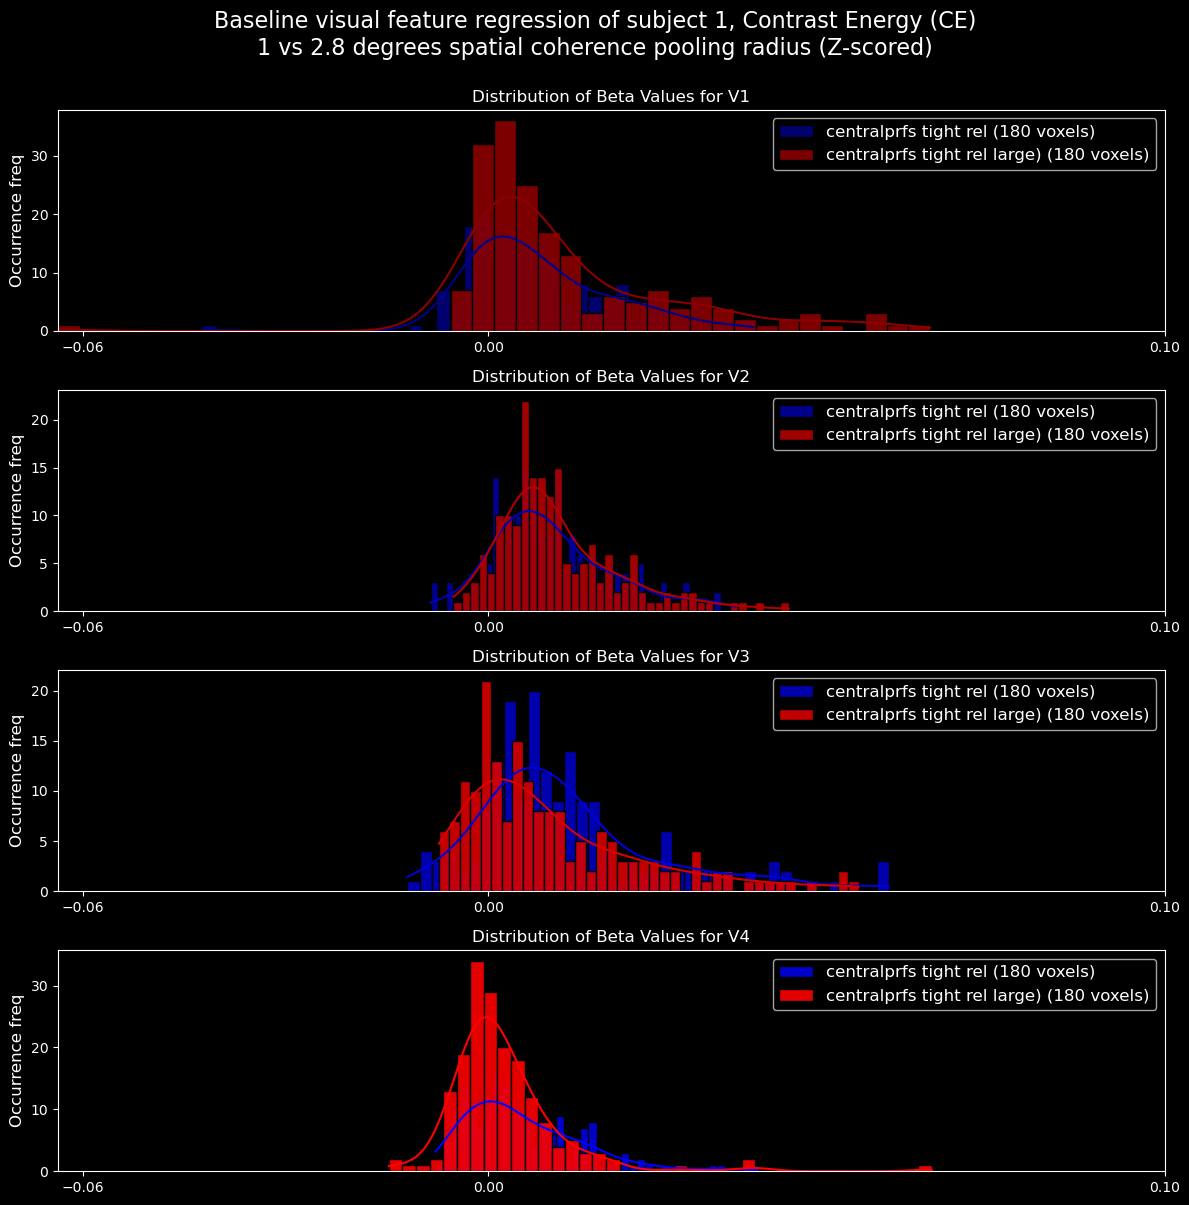

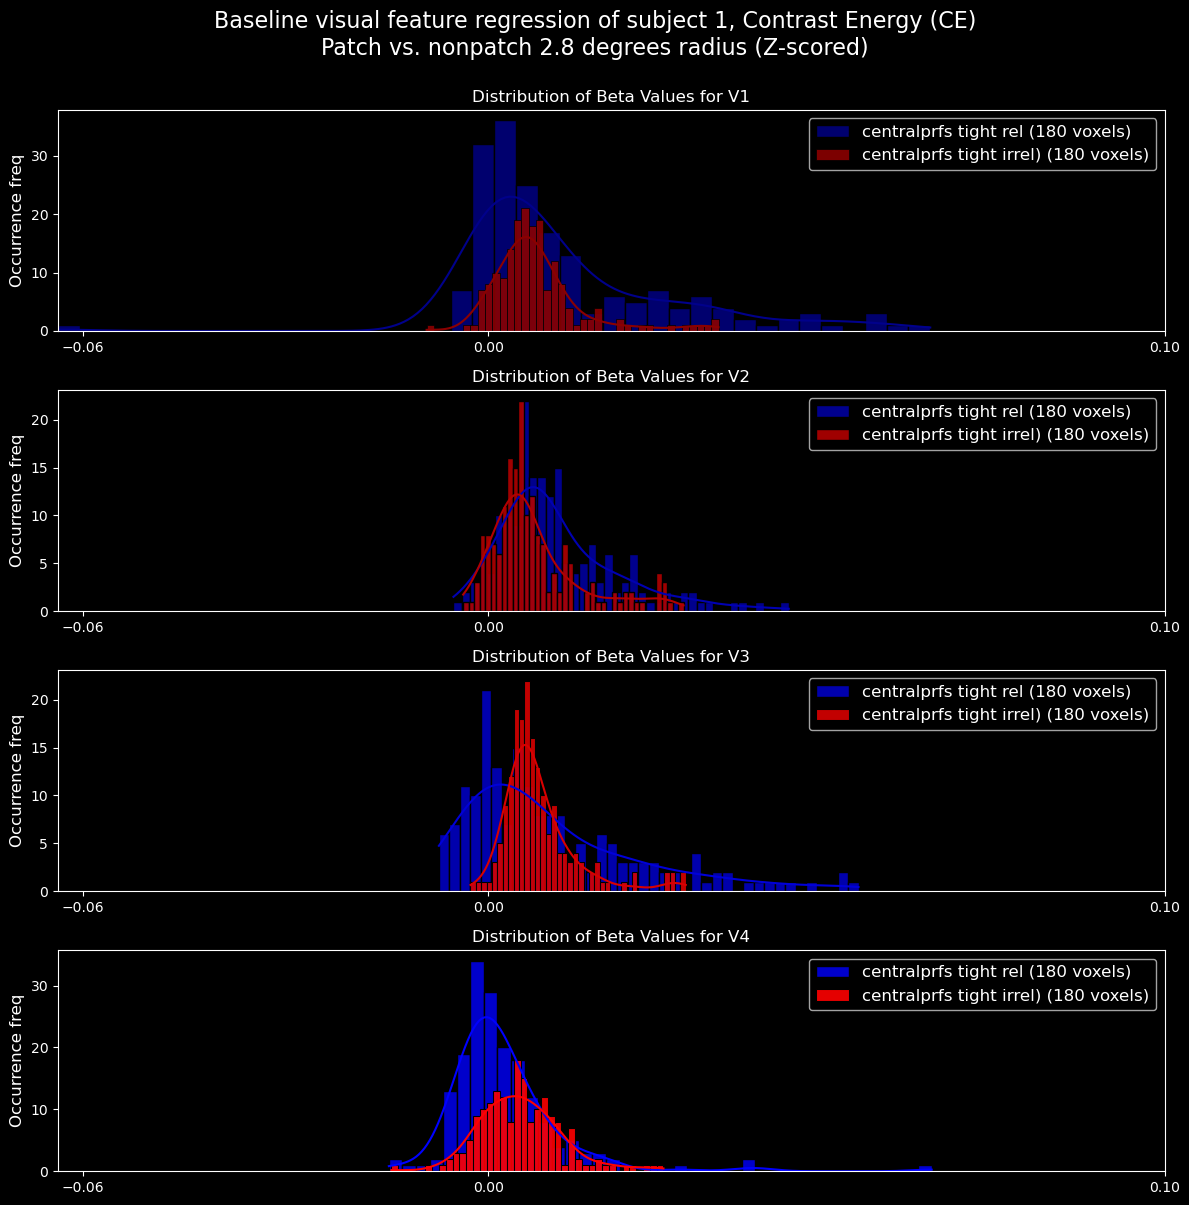

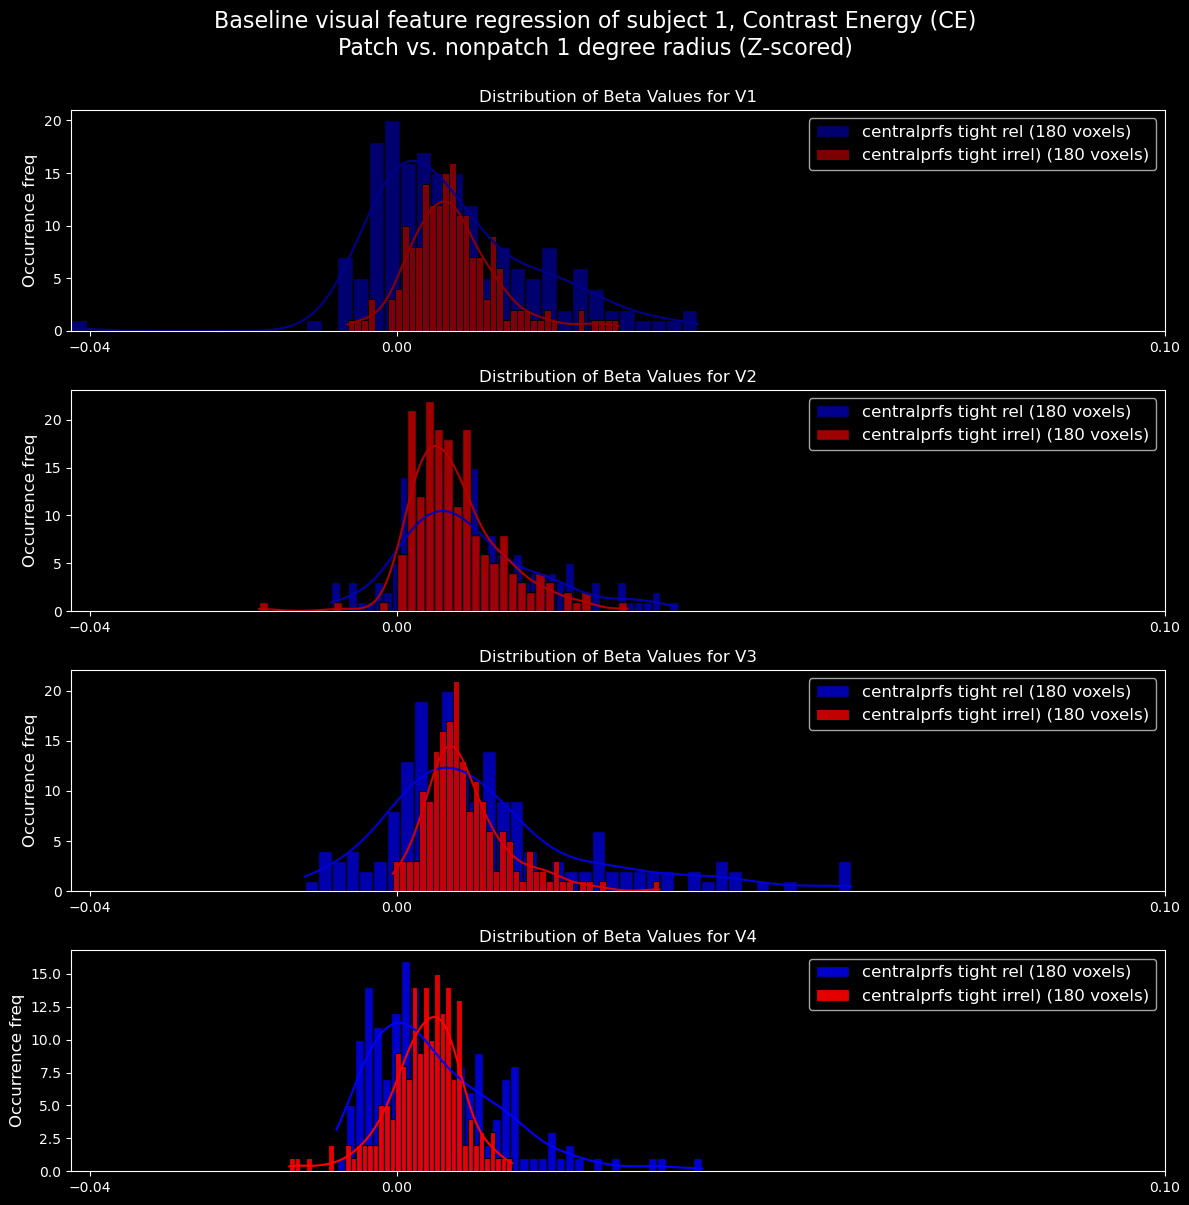

In [125]:
reg_plots(regstash_sc_z['centralprfs']['tight']['rel'], dictdescrip1 = 'centralprfs tight rel', comptype = '1 vs 2.8 degrees spatial coherence pooling radius (Z-scored)',
                           icept_correct = 'n', feat_type = 'Contrast Energy (CE)', comparison_reg_dict = regstash_sc_large_z['centralprfs']['tight']['rel'], 
                           dictdescrip2 = 'centralprfs tight rel large)', beta_hist = True, beta_icept = False)

reg_plots(regstash_sc_large_z['centralprfs']['tight']['rel'], dictdescrip1 = 'centralprfs tight rel', comptype = 'Patch vs. nonpatch 2.8 degrees radius (Z-scored)',
                           icept_correct = 'n', feat_type = 'Contrast Energy (CE)', comparison_reg_dict = regstash_sc_large_z['centralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'centralprfs tight irrel)', beta_hist = True, beta_icept = False)

reg_plots(regstash_sc_z['centralprfs']['tight']['rel'], dictdescrip1 = 'centralprfs tight rel', comptype = 'Patch vs. nonpatch 1 degree radius (Z-scored)',
                           icept_correct = 'n', feat_type = 'Contrast Energy (CE)', comparison_reg_dict = regstash_sc_z['centralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'centralprfs tight irrel)', beta_hist = True, beta_icept = False)

TypeError: reload() missing 1 required positional argument: 'module'

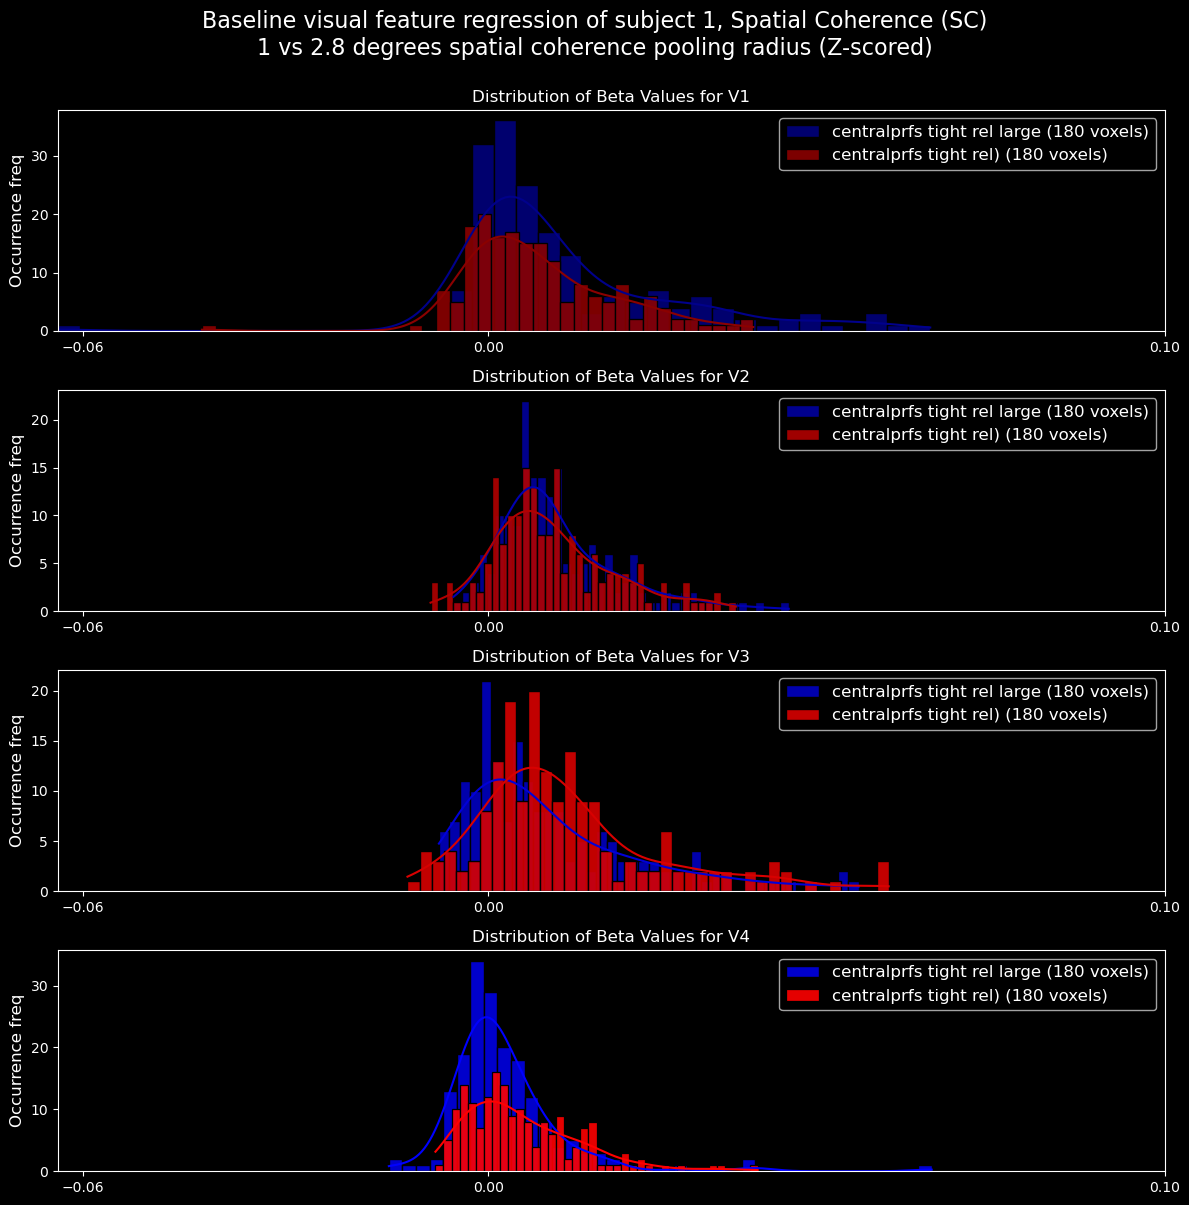

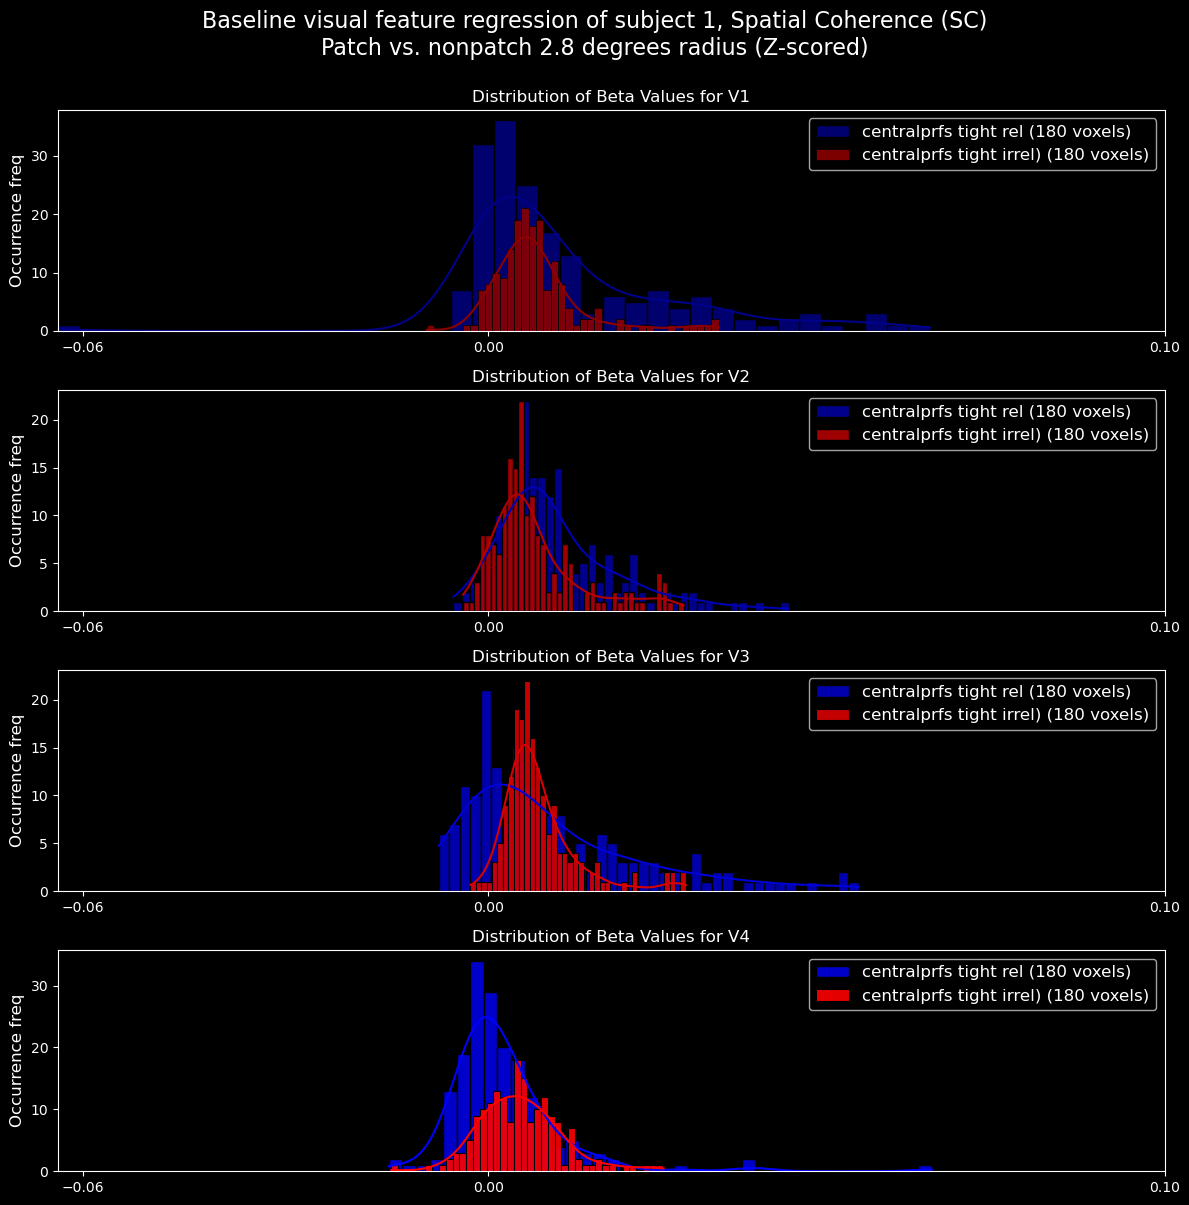

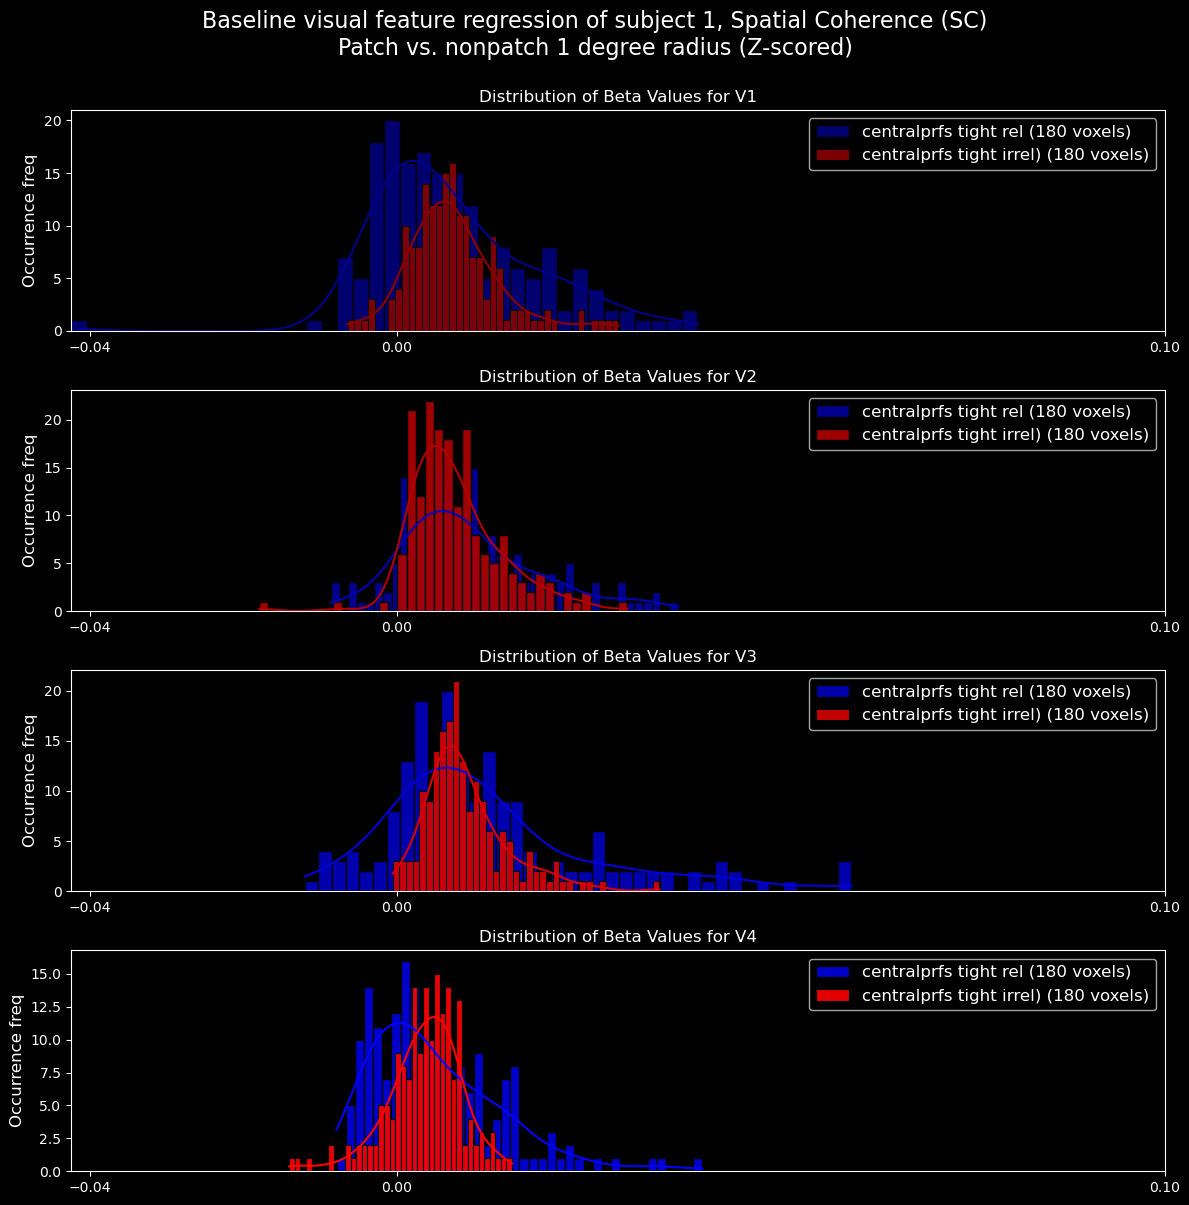

In [166]:
reg_plots(regstash_sc_large_z['centralprfs']['tight']['rel'], dictdescrip1 = 'centralprfs tight rel large', comptype = '1 vs 2.8 degrees spatial coherence pooling radius (Z-scored)',
                           icept_correct = 'n', feat_type = 'Spatial Coherence (SC)', comparison_reg_dict = regstash_sc_z['centralprfs']['tight']['rel'], 
                           dictdescrip2 = 'centralprfs tight rel)', beta_hist = True, beta_icept = False)

reg_plots(regstash_sc_large_z['centralprfs']['tight']['rel'], dictdescrip1 = 'centralprfs tight rel', comptype = 'Patch vs. nonpatch 2.8 degrees radius (Z-scored)',
                           icept_correct = 'n', feat_type = 'Spatial Coherence (SC)', comparison_reg_dict = regstash_sc_large_z['centralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'centralprfs tight irrel)', beta_hist = True, beta_icept = False)

reg_plots(regstash_sc_z['centralprfs']['tight']['rel'], dictdescrip1 = 'centralprfs tight rel', comptype = 'Patch vs. nonpatch 1 degree radius (Z-scored)',
                           icept_correct = 'n', feat_type = 'Spatial Coherence (SC)', comparison_reg_dict = regstash_sc_z['centralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'centralprfs tight irrel)', beta_hist = True, beta_icept = False)

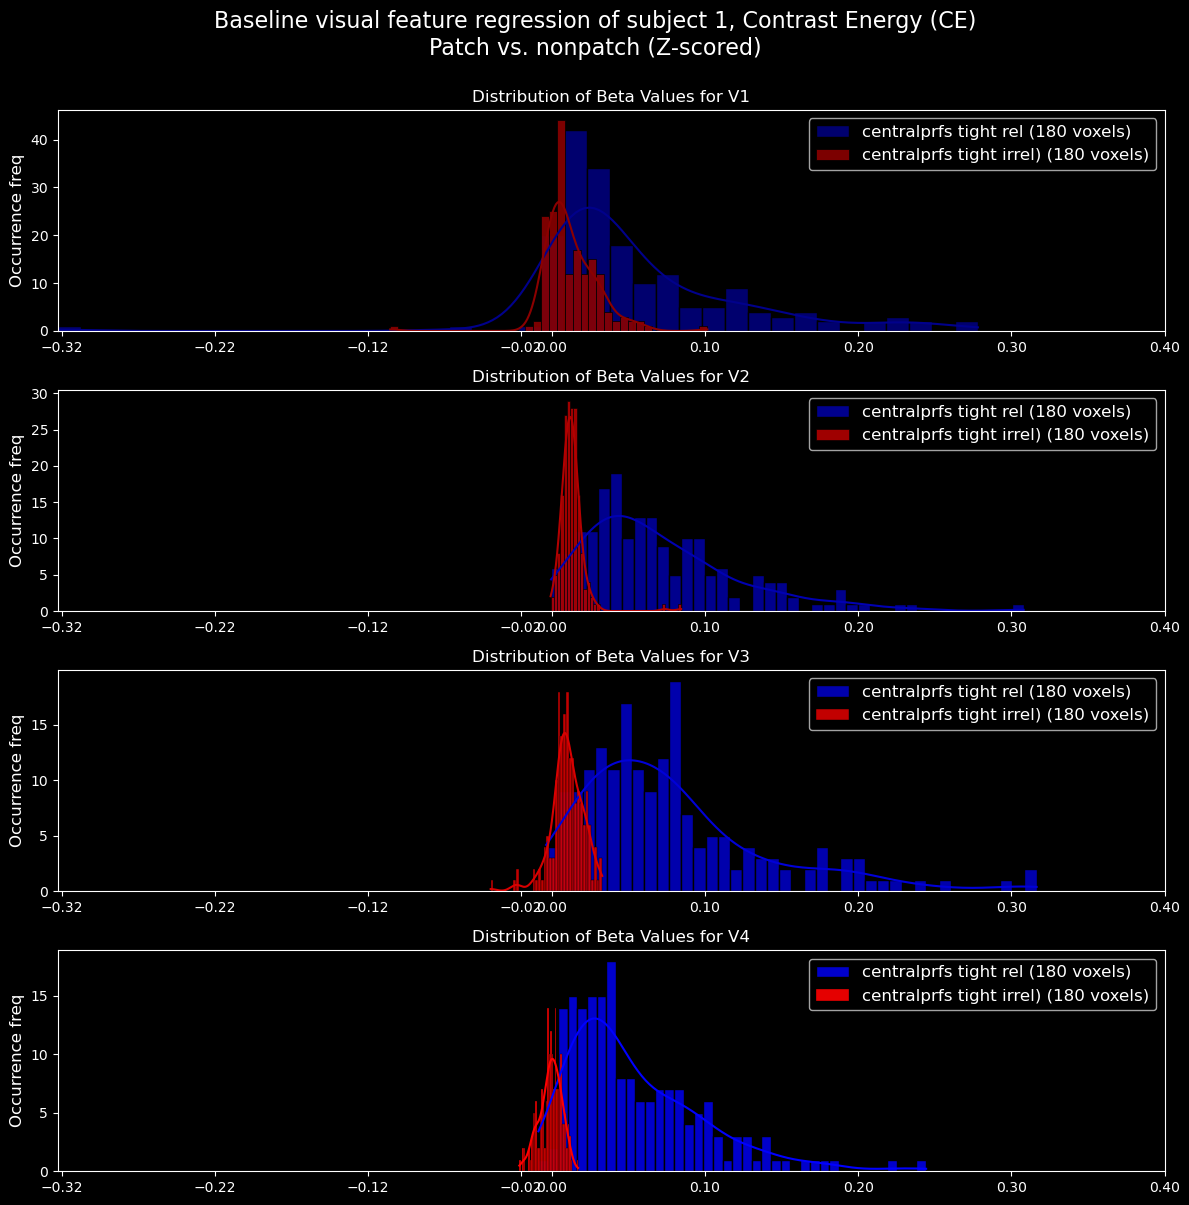

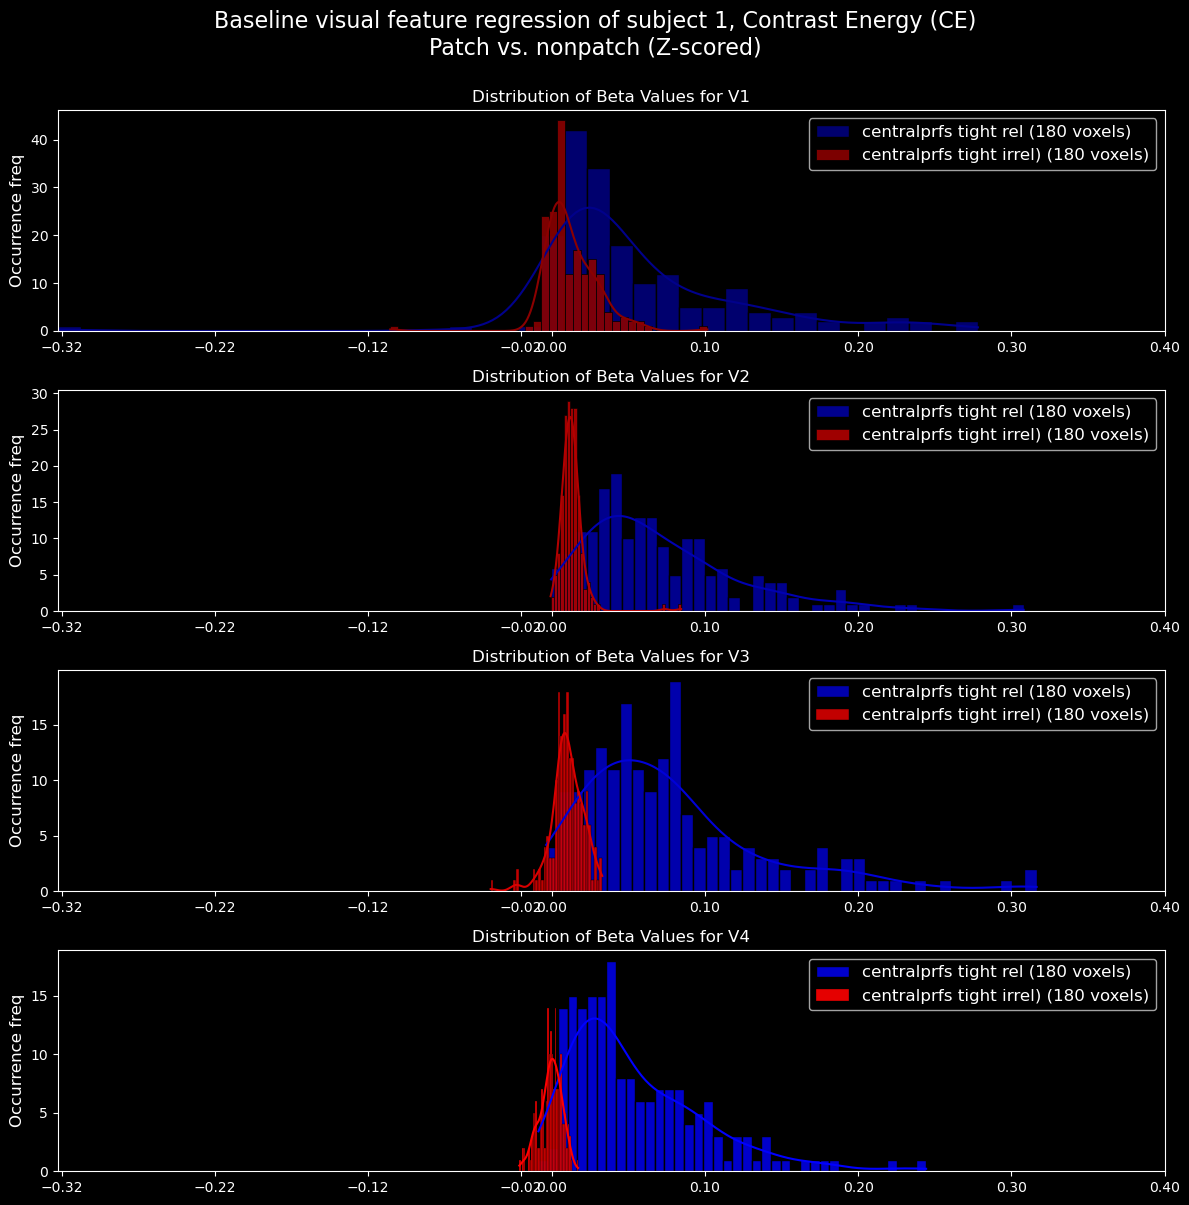

In [127]:
reg_plots(regstash_ce_z['centralprfs']['tight']['rel'], dictdescrip1 = 'centralprfs tight rel', comptype = 'Patch vs. nonpatch (Z-scored)',
                           icept_correct = 'n', feat_type = 'Contrast Energy (CE)', comparison_reg_dict = regstash_ce_z['centralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'centralprfs tight irrel)', beta_hist = True, beta_icept = False)

# Just to check whether they're the same, whihc they are.
reg_plots(regdict_prfc_tight_cerel_z, dictdescrip1 = 'centralprfs tight rel', comptype = 'Patch vs. nonpatch (Z-scored)',
                           icept_correct = 'n', feat_type = 'Contrast Energy (CE)', comparison_reg_dict = regdict_prfc_tight_ceirrel_z, 
                           dictdescrip2 = 'centralprfs tight irrel)', beta_hist = True, beta_icept = False)

In [164]:
from numpy import True_


subj = 'subj01'

mfeat_reg_rel, X = regression_dict_multivariate(subj, 'rms', voxmask_tight, hrf_dict_tight, visfeats_scce[subj]['scce'], n_imgs='all', 
                                 z_scorey = True, non_patch = False,
                                 multi_feats = True, rms = True, sc = True, ce = True)

mfeat_reg_rel_large, X = regression_dict_multivariate(subj, 'rms', voxmask_tight, hrf_dict_tight, visfeats_scce[subj]['scce'], n_imgs='all', 
                                 z_scorey = True, non_patch = False,
                                 multi_feats = True, rms = True, sc = True, ce = True_, sc_large = True)
    
mfeat_reg_irrel, X = regression_dict_multivariate(subj, 'rms', voxmask_tight, hrf_dict_tight, visfeats_scce[subj]['scce'], n_imgs='all', 
                                z_scorey = True, non_patch = True,
                                multi_feats = True, rms = True, sc = True, ce = True)

mfeat_reg_irrel_large, X = regression_dict_multivariate(subj, 'rms', voxmask_tight, hrf_dict_tight, visfeats_scce[subj]['scce'], n_imgs='all', 
                                z_scorey = True, non_patch = True,
                                multi_feats = True, rms = True, sc = True, ce = True, sc_large = True)

In [ ]:
visfeats_scce_large['subj01']['scce_irrelevant']['']

In [38]:
print(X)
print(X_ce_irrel)

[[ 0.47179]
 [-0.81307]
 [ 1.68124]
 ...
 [-0.70475]
 [-0.74173]
 [-0.81761]]
[[ 0.47179]
 [-0.81307]
 [ 1.68124]
 ...
 [-0.70475]
 [-0.74173]
 [-0.81761]]


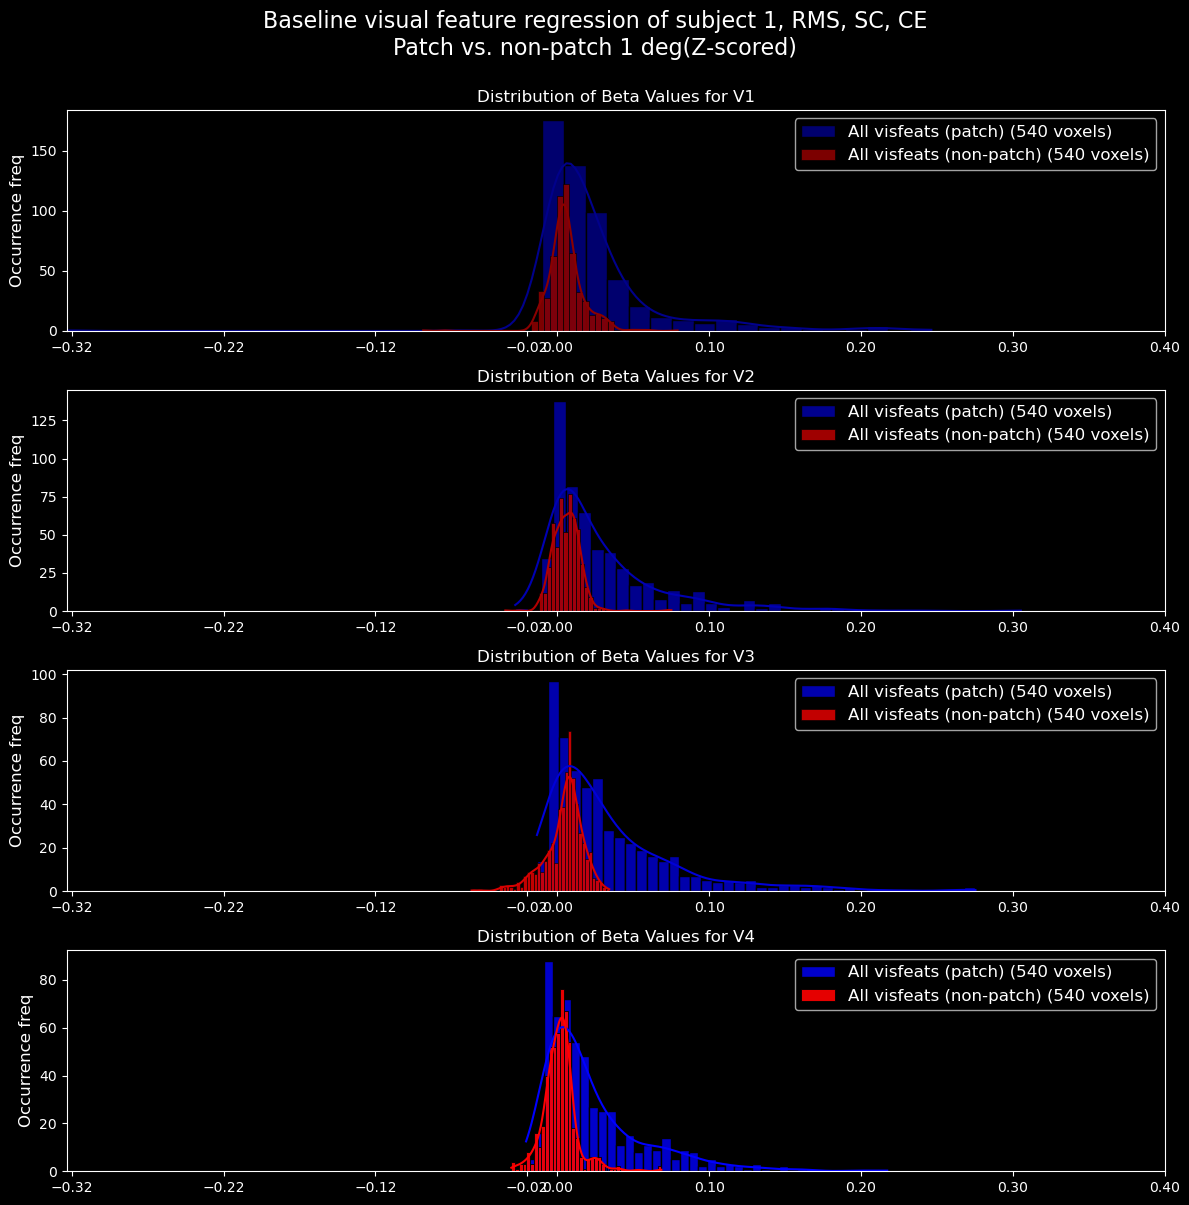

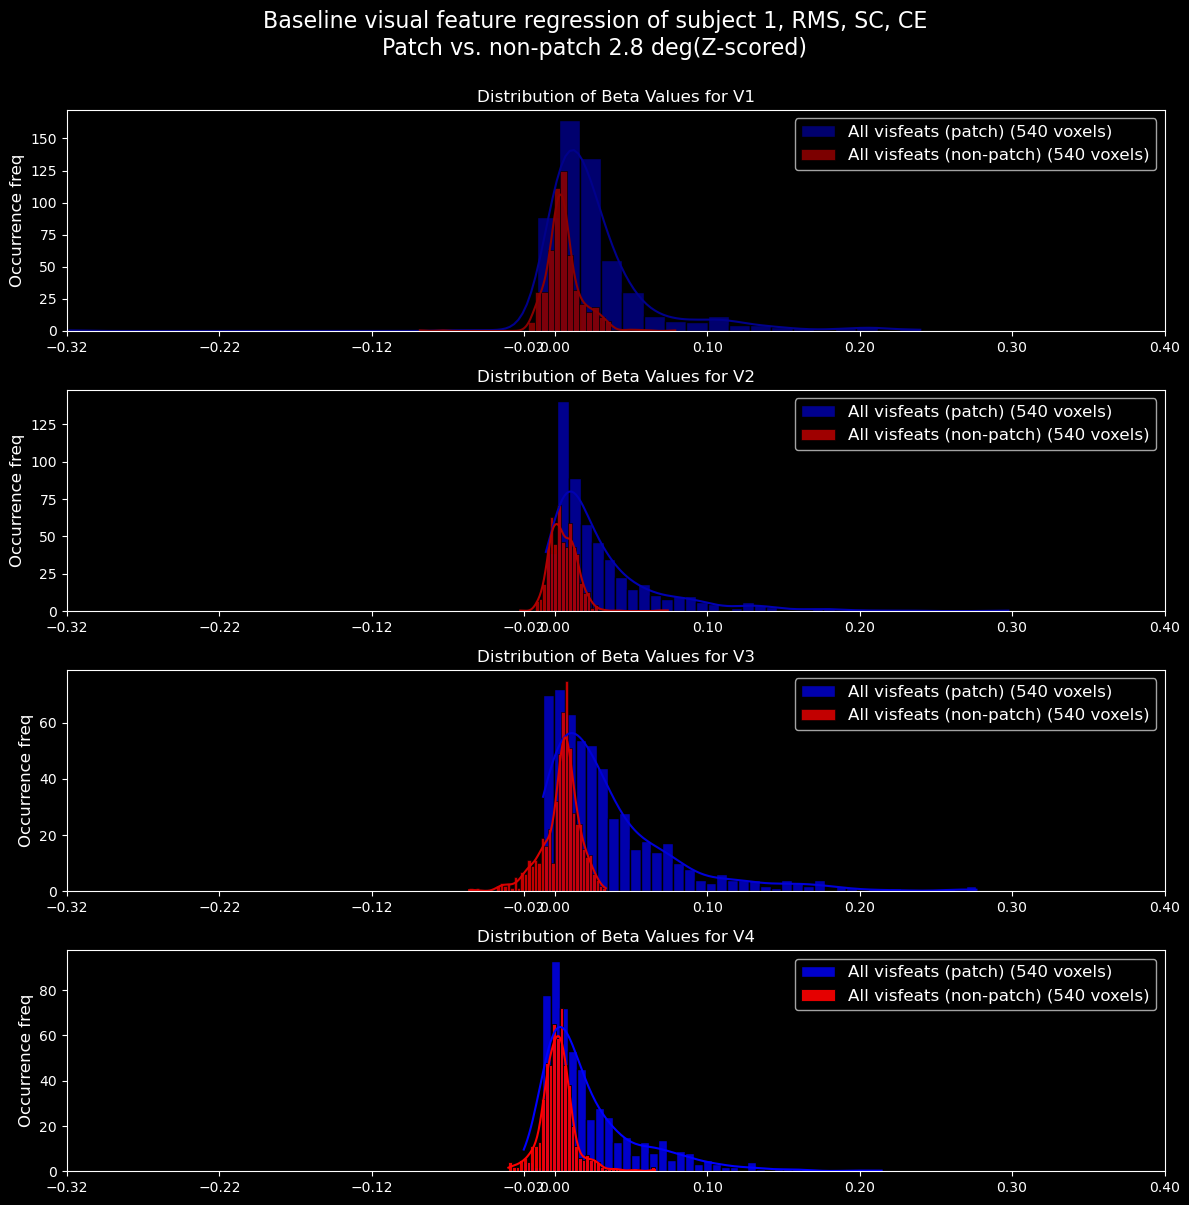

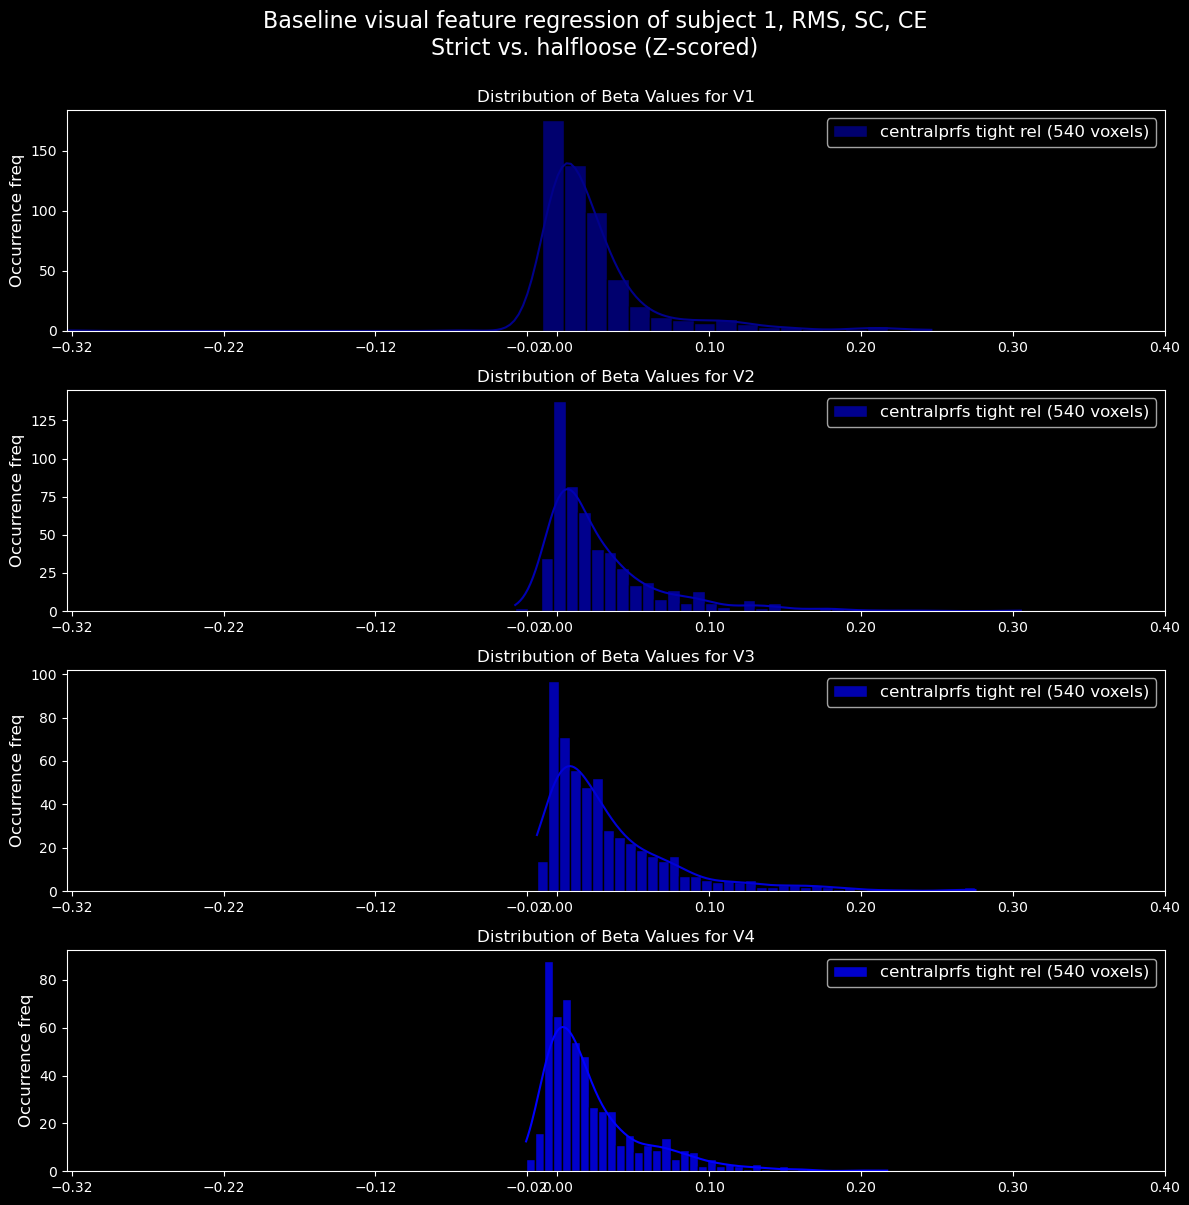

In [165]:
reg_plots(mfeat_reg_rel, 
          dictdescrip1 = 'All visfeats (patch)', 
          comptype = 'Patch vs. non-patch 1 deg(Z-scored)',
          icept_correct = 'n', 
          feat_type = 'RMS, SC, CE', 
          comparison_reg_dict = mfeat_reg_irrel, 
          dictdescrip2 = 'All visfeats (non-patch)', 
          beta_hist = True, 
          beta_icept = False)

reg_plots(mfeat_reg_rel_large, 
          dictdescrip1 = 'All visfeats (patch)', 
          comptype = 'Patch vs. non-patch 2.8 deg(Z-scored)',
          icept_correct = 'n', 
          feat_type = 'RMS, SC, CE', 
          comparison_reg_dict = mfeat_reg_irrel_large, 
          dictdescrip2 = 'All visfeats (non-patch)', 
          beta_hist = True, 
          beta_icept = False)


reg_plots(mfeat_reg_rel, 
          dictdescrip1 = 'centralprfs tight rel', 
          comptype = 'Strict vs. halfloose (Z-scored)',
          icept_correct = 'n', 
          feat_type = 'RMS, SC, CE',
          beta_hist = True, 
          beta_icept = False)

In [18]:
regstash_z_crop_prior_subj2

{'centralprfs': {'tight': {'rel': {'V1_mask': {'voxels': {'vox0': {'xyz': [59,
        8,
        62],
       'beta': array([0.029]),
       'icept': array([0.])},
      'vox1': {'xyz': [60, 7, 62],
       'beta': array([0.04793]),
       'icept': array([0.])},
      'vox2': {'xyz': [60, 8, 62],
       'beta': array([0.00995]),
       'icept': array([0.])},
      'vox3': {'xyz': [60, 9, 62],
       'beta': array([0.07087]),
       'icept': array([0.])},
      'vox4': {'xyz': [61, 8, 60],
       'beta': array([0.04558]),
       'icept': array([0.])},
      'vox5': {'xyz': [62, 10, 61],
       'beta': array([0.01453]),
       'icept': array([0.])},
      'vox6': {'xyz': [64, 6, 63],
       'beta': array([0.00563]),
       'icept': array([0.])},
      'vox7': {'xyz': [64, 13, 60],
       'beta': array([0.01153]),
       'icept': array([0.])},
      'vox8': {'xyz': [65, 5, 72],
       'beta': array([0.02656]),
       'icept': array([0.])},
      'vox9': {'xyz': [65, 16, 62],
       'beta':